In [110]:
import os

print("Current working directory:")
print(os.getcwd())

print("\nContents of current folder:")
print(os.listdir())

print("\nContents of sep folder (if exists):")
if os.path.exists("DSA4262"):
    print(os.listdir("DSA4262"))
else:
    print("No DSA4262 folder found.")

Current working directory:
/Users/faithyeo

Contents of current folder:
['Tutorial 1 Notes.R', '.zshrc.save', '.Rhistory', '.config', 'Music', '.condarc', '.docker', 'Tutorial 1 2(i).R', '.DS_Store', 'nltk_data', 'requirements.txt', '.CFUserTextEncoding', '.xonshrc', '.zshrc', 'matlab_crash_dump.11407-1', '.dbgate', '.streamlit', '.local', '.psql_history', 'Pictures', 'test.csv', '.zprofile', '.nvm', 'pdf', '.claude.json.backup.1770848624913', '.claude', '.claude.json.backup.1770848624914', '.zsh_history', 'Week 6 Tutorial.R', '.ipython', 'Desktop', 'Library', '.claude.json.backup.1771651182767', '.matplotlib', 'glove-python', '.claude.json.backup.1770848624915', '.lesshst', 'deadlines.txt', '.oracle_jre_usage', 'hs2916 indiv.txt', 'scikit_learn_data', 'test.png', 'Untitled.txt', 'Public', 'logs', 'best_bert_model.pt', 'cs.txt', '.idlerc', '.tcshrc', '.RData', 'ptb_data', '.virtual_documents', '.venv', '.anaconda', 'question-bank', '.ssh', 'Movies', 'Applications', 'db', '.Rapp.history

**Predictive Model to Detect Stress Signals in Social Media Text Using the Dreaddit Dataset**

**GitHub:** [Repository Link]
<br>

**Context Setting**
<br>

Psychological distress is inherently invisible, yet increasingly expressed in digital spaces. On platforms such as Reddit, users share personal experiences using informal, unfiltered language, creating both an opportunity and a challenge for automated detection. Identifying stress signals in such text could support early awareness and intervention, but requires careful consideration of linguistic nuance, context, and ethical deployment.
<br>

**Dataset Overview**
<br>

This study uses the Dreaddit dataset, a labelled Reddit corpus for binary stress classification. The dataset contains posts from multiple stress-related subreddits and includes both stressed and non-stressed examples. The data is split into training, validation and test sets, with a balanced class distribution. Posts vary substantially in length and community context, providing a realistic and heterogeneous benchmark for stress detection in informal text.

# SECTION 1: LIBRARY IMPORTS & HUGGINGFACE DATASET SETUP

In [3]:
# CORE DATA MANIPULATION LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# HUGGINGFACE DATASETS
from datasets import load_dataset

# TEXT PROCESSING LIBRARIES
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download NLTK resources (run once)
print("Downloading NLTK resources...")
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
print("✓ NLTK resources ready\n")

# MACHINE LEARNING LIBRARIES
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                             f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

# DEEP LEARNING LIBRARIES
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW

# INTERPRETABILITY & VISUALIZATION
try:
    import shap
except ImportError:
    print("⚠️  SHAP not installed. Install with: pip install shap")

try:
    from lime.lime_text import LimeTextExplainer
except ImportError:
    print("⚠️  LIME not installed. Install with: pip install lime")

from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

# REPRODUCIBILITY SETTINGS
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"✓ Random seed set to {RANDOM_SEED} for reproducibility")

# VISUALIZATION SETTINGS
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Visualization settings configured")

# CHECK GPU AVAILABILITY
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = torch.device('cpu')
    print("⚠️  No GPU available - will use CPU (training will be slower)")
    print("   For faster training, consider using Google Colab (free GPU)")

print("\n" + "="*80)
print("ENVIRONMENT SETUP COMPLETE")
print("="*80)

✓ NLTK resources ready



[nltk_data] Downloading package punkt to /Users/faithyeo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/faithyeo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✓ Random seed set to 42 for reproducibility
✓ Visualization settings configured
⚠️  No GPU available - will use CPU (training will be slower)
   For faster training, consider using Google Colab (free GPU)

ENVIRONMENT SETUP COMPLETE


# SECTION 2: LOADING DREADDIT FROM HUGGINGFACE

In [5]:
# STEP 2.1: LOAD DATASET FROM HUGGINGFACE HUB

print("="*80)
print("STEP 2.1: LOADING DREADDIT FROM HUGGINGFACE")
print("="*80)

print("\n📦 Downloading Dreaddit dataset from HuggingFace Hub...")
print("   (This may take a minute on first run - dataset will be cached locally)")

try:
    # Load the dataset
    dataset = load_dataset("andreagasparini/dreaddit")
    print("✓ Dataset loaded successfully!\n")
    
except Exception as e:
    print(f"✗ Error loading dataset: {e}")
    print("\nTroubleshooting:")
    print("1. Check internet connection")
    print("2. Verify HuggingFace Hub is accessible")
    print("3. Try: pip install --upgrade datasets")
    raise

STEP 2.1: LOADING DREADDIT FROM HUGGINGFACE

📦 Downloading Dreaddit dataset from HuggingFace Hub...
   (This may take a minute on first run - dataset will be cached locally)
✓ Dataset loaded successfully!



In [6]:
# Split the training set into training and validation

train_dataset = dataset["train"]
test_dataset  = dataset["test"]

from sklearn.model_selection import train_test_split

train_df_full = train_dataset.to_pandas()

# remove duplicates BEFORE splitting
train_df_full = train_df_full.drop_duplicates(subset=["post_id"]).reset_index(drop=True)

train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.1,
    stratify=train_df_full["label"],
    random_state=42
)

print(len(train_df), len(val_df))

2108 235


In [7]:
train_texts = set(train_df["text"].astype(str))
val_texts = set(val_df["text"].astype(str))
print("Exact text overlap:", len(train_texts.intersection(val_texts)))

Exact text overlap: 4


In [8]:
# STEP 2.2: EXAMINE DATASET STRUCTURE

print("="*80)
print("STEP 2.2: DATASET STRUCTURE")
print("="*80)

print("\n📊 Dataset Overview:")
print(dataset)

# Extract splits that actually exist on HF
train_dataset = dataset["train"]
test_dataset = dataset["test"]

print("\n📊 Split Sizes:")
print(f"   Training set:   {len(train_df):,} examples")
print(f"   Validation set: {len(val_df):,} examples")
print(f"   Test set:       {len(test_dataset):,} examples")
print(f"   Total:          {len(train_df) + len(val_df) + len(test_dataset):,} examples")

total = len(train_df) + len(val_df) + len(test_dataset)
print(f"\n📊 Split Proportions:")
print(f"   Training:   {len(train_df)/total:.1%}")
print(f"   Validation: {len(val_df)/total:.1%}")
print(f"   Test:       {len(test_dataset)/total:.1%}")

STEP 2.2: DATASET STRUCTURE

📊 Dataset Overview:
DatasetDict({
    train: Dataset({
        features: ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex

In [9]:
# STEP 2.3: EXAMINE DATASET FEATURES

print("\n" + "="*80)
print("STEP 2.3: DATASET FEATURES")
print("="*80)

# Get feature information
features = train_dataset.features
print("\n📋 Available Features:")
for feature_name, feature_type in features.items():
    print(f"   {feature_name}: {feature_type}")

# Show example from training set
print("\n📝 Example from Training Set:")
print(train_dataset[0])

# Show a few more examples to get a feel for the data
print("\n📝 Three Random Examples:")
import random
random.seed(RANDOM_SEED)
random_indices = random.sample(range(len(train_dataset)), 3)

for i, idx in enumerate(random_indices, 1):
    example = train_dataset[idx]
    print(f"\nExample {i}:")
    print(f"   Subreddit: {example.get('subreddit', 'N/A')}")
    print(f"   Label: {example['label']} ({'Stressed' if example['label'] == 1 else 'Non-Stressed'})")
    print(f"   Text: {example['text'][:200]}...")  # First 200 characters


STEP 2.3: DATASET FEATURES

📋 Available Features:
   subreddit: Value('string')
   post_id: Value('string')
   sentence_range: Value('string')
   text: Value('string')
   id: Value('int64')
   label: Value('int64')
   confidence: Value('float64')
   social_timestamp: Value('int64')
   social_karma: Value('int64')
   syntax_ari: Value('float64')
   lex_liwc_WC: Value('int64')
   lex_liwc_Analytic: Value('float64')
   lex_liwc_Clout: Value('float64')
   lex_liwc_Authentic: Value('float64')
   lex_liwc_Tone: Value('float64')
   lex_liwc_WPS: Value('float64')
   lex_liwc_Sixltr: Value('float64')
   lex_liwc_Dic: Value('float64')
   lex_liwc_function: Value('float64')
   lex_liwc_pronoun: Value('float64')
   lex_liwc_ppron: Value('float64')
   lex_liwc_i: Value('float64')
   lex_liwc_we: Value('float64')
   lex_liwc_you: Value('float64')
   lex_liwc_shehe: Value('float64')
   lex_liwc_they: Value('float64')
   lex_liwc_ipron: Value('float64')
   lex_liwc_article: Value('float64')
   lex_li

In [10]:
# STEP 2.4: CONVERT TO PANDAS DATAFRAMES

print("\n" + "="*80)
print("STEP 2.4: CONVERTING TO PANDAS DATAFRAMES")
print("="*80)

print("\n🔄 Converting datasets to pandas DataFrames...")

# Convert each split to pandas
test_df = test_dataset.to_pandas()

print("✓ Conversion complete!")

# Verify conversion
print(f"\n✓ Training DataFrame:   {train_df.shape[0]:,} rows × {train_df.shape[1]} columns")
print(f"✓ Validation DataFrame: {val_df.shape[0]:,} rows × {val_df.shape[1]} columns")
print(f"✓ Test DataFrame:       {test_df.shape[0]:,} rows × {test_df.shape[1]} columns")


STEP 2.4: CONVERTING TO PANDAS DATAFRAMES

🔄 Converting datasets to pandas DataFrames...
✓ Conversion complete!

✓ Training DataFrame:   2,108 rows × 116 columns
✓ Validation DataFrame: 235 rows × 116 columns
✓ Test DataFrame:       715 rows × 116 columns


In [11]:
# STEP 2.5: INITIAL DATA INSPECTION

print("\n" + "="*80)
print("STEP 2.5: INITIAL DATA INSPECTION")
print("="*80)

# Display first few rows
print("\n🔍 First 3 rows of training data:")
print(train_df.head(3))

# Column names
print(f"\n📋 Column Names ({len(train_df.columns)} total):")
print(train_df.columns.tolist())

# Data types
print(f"\n📊 Data Types:")
print(train_df.dtypes)

# Basic statistics
print(f"\n📈 Statistical Summary:")
print(train_df.describe())


STEP 2.5: INITIAL DATA INSPECTION

🔍 First 3 rows of training data:
             subreddit post_id sentence_range  \
271   domesticviolence  8vuksa         [0, 5]   
1392        assistance  7bdkd1         [0, 5]   
822         assistance  7op5oe       [15, 20]   

                                                   text    id  label  \
271   Quick background: I left this guy back in 2006...    35      0   
1392  Want to get my MacBook sorted and need to upda...  1624      0   
822   Edit 2: in the wonderful world of good news, t...  1311      0   

      confidence  social_timestamp  social_karma  syntax_ari  ...  \
271     0.571429        1530642424            17    5.755714  ...   
1392    0.800000        1510065592             0    8.166410  ...   
822     1.000000        1515307505            53   11.145385  ...   

      lex_dal_min_pleasantness  lex_dal_min_activation  lex_dal_min_imagery  \
271                     1.0833                  1.1429                  1.0   
1392      


STEP 2.6: CLASS DISTRIBUTION IN EACH SPLIT

📊 Training Set Class Distribution:
   Class 0 (Non-Stressed): 977 (46.3%)
   Class 1 (Stressed):     1,131 (53.7%)
   Imbalance Ratio: 1.16:1

📊 Validation Set Class Distribution:
   Class 0 (Non-Stressed): 109 (46.4%)
   Class 1 (Stressed):     126 (53.6%)
   Imbalance Ratio: 1.16:1

📊 Test Set Class Distribution:
   Class 0 (Non-Stressed): 346 (48.4%)
   Class 1 (Stressed):     369 (51.6%)
   Imbalance Ratio: 1.07:1

STRATIFICATION CHECK

📊 Stressed Class Proportion:
   Training:   53.7%
   Validation: 53.6%
   Test:       51.6%

✓ Good stratification (max difference: 2.0%)
   All splits have similar class distributions


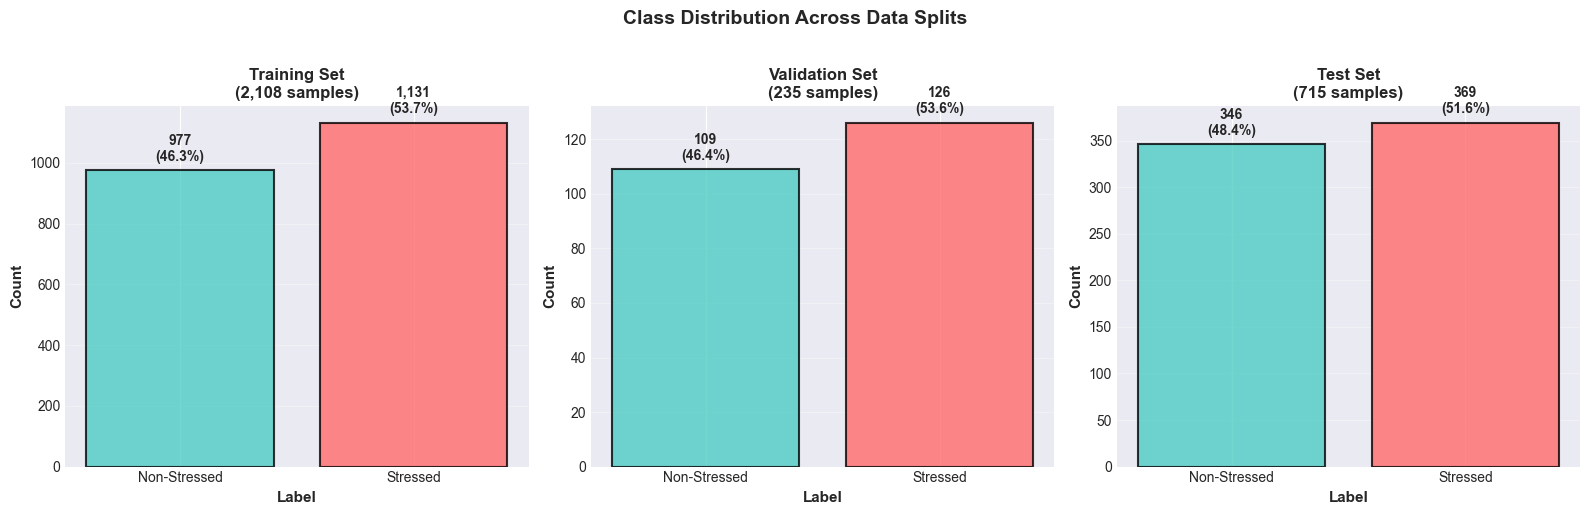

In [12]:
# STEP 2.6: CLASS DISTRIBUTION ANALYSIS

print("\n" + "="*80)
print("STEP 2.6: CLASS DISTRIBUTION IN EACH SPLIT")
print("="*80)

def analyze_class_distribution(df, split_name):
    """
    Analyze and visualize class distribution for a dataset split.
    
    WHY WE DO THIS:
    - Check if classes are balanced
    - Ensure stratified splitting (all splits have similar distributions)
    - Identify if we need class weights or resampling
    """
    print(f"\n📊 {split_name} Set Class Distribution:")
    
    label_counts = df['label'].value_counts().sort_index()
    label_props = df['label'].value_counts(normalize=True).sort_index()
    
    print(f"   Class 0 (Non-Stressed): {label_counts[0]:,} ({label_props[0]:.1%})")
    print(f"   Class 1 (Stressed):     {label_counts[1]:,} ({label_props[1]:.1%})")
    
    imbalance_ratio = label_counts.max() / label_counts.min()
    print(f"   Imbalance Ratio: {imbalance_ratio:.2f}:1")
    
    return label_counts, label_props, imbalance_ratio

# Analyze each split
train_stats = analyze_class_distribution(train_df, "Training")
val_stats = analyze_class_distribution(val_df, "Validation")
test_stats = analyze_class_distribution(test_df, "Test")

print("\n" + "="*80)
print("STRATIFICATION CHECK")
print("="*80)

print(f"\n📊 Stressed Class Proportion:")
print(f"   Training:   {train_stats[1][1]:.1%}")
print(f"   Validation: {val_stats[1][1]:.1%}")
print(f"   Test:       {test_stats[1][1]:.1%}")

# Calculate maximum difference
proportions = [train_stats[1][1], val_stats[1][1], test_stats[1][1]]
max_diff = max(proportions) - min(proportions)

if max_diff < 0.05:
    print(f"\n✓ Good stratification (max difference: {max_diff:.1%})")
    print("   All splits have similar class distributions")
else:
    print(f"\n⚠️  Poor stratification (max difference: {max_diff:.1%})")
    print("   Class distributions vary significantly across splits")

# Visualize class distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

splits = [('Training', train_df), ('Validation', val_df), ('Test', test_df)]
colors = ['#4ECDC4', '#FF6B6B']

for idx, (split_name, df) in enumerate(splits):
    label_counts = df['label'].value_counts().sort_index()
    label_props = df['label'].value_counts(normalize=True).sort_index()
    
    # Bar chart
    axes[idx].bar(label_counts.index, label_counts.values, color=colors,
                  alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[idx].set_xlabel('Label', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Count', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{split_name} Set\n({len(df):,} samples)', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels(['Non-Stressed', 'Stressed'], rotation=0)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (label, val) in enumerate(label_counts.items()):
        axes[idx].text(i, val + (val * 0.02), 
                      f'{val:,}\n({label_props[label]:.1%})',
                      ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('Class Distribution Across Data Splits', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# STEP 2.7: SUBREDDIT DISTRIBUTION

print("\n" + "="*80)
print("STEP 2.7: SUBREDDIT ANALYSIS")
print("="*80)

if 'subreddit' in train_df.columns:
    print("\n📊 Subreddits in Training Set:")
    subreddit_counts = train_df['subreddit'].value_counts()
    print(subreddit_counts.to_string())
    
    # Check if subreddits are consistent across splits
    train_subs = set(train_df['subreddit'].unique())
    val_subs = set(val_df['subreddit'].unique())
    test_subs = set(test_df['subreddit'].unique())
    
    print(f"\n📊 Subreddit Coverage:")
    print(f"   Unique subreddits in training:   {len(train_subs)}")
    print(f"   Unique subreddits in validation: {len(val_subs)}")
    print(f"   Unique subreddits in test:       {len(test_subs)}")
    
    # Check for subreddits that appear in test but not train
    test_only = test_subs - train_subs
    if test_only:
        print(f"\n⚠️  Subreddits in test but not in train: {test_only}")
        print("   This could affect generalization to these communities")
    else:
        print(f"\n✓ All test subreddits appear in training set")


STEP 2.7: SUBREDDIT ANALYSIS

📊 Subreddits in Training Set:
subreddit
ptsd                443
anxiety             390
relationships       381
assistance          241
domesticviolence    224
survivorsofabuse    165
homeless            122
almosthomeless       66
stress               50
food_pantry          26

📊 Subreddit Coverage:
   Unique subreddits in training:   10
   Unique subreddits in validation: 10
   Unique subreddits in test:       10

✓ All test subreddits appear in training set


In [14]:
# STEP 2.8: MISSING DATA CHECK

print("\n" + "="*80)
print("STEP 2.8: MISSING DATA ANALYSIS")
print("="*80)

def check_missing_data(df, split_name):
    """Check for missing values in a dataframe"""
    missing_counts = df.isnull().sum()
    missing_percentages = (missing_counts / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_counts.index,
        'Missing_Count': missing_counts.values,
        'Missing_Percentage': missing_percentages.values
    })
    
    missing_df_filtered = missing_df[missing_df['Missing_Count'] > 0]
    
    if len(missing_df_filtered) == 0:
        print(f"✓ {split_name}: No missing values")
        return None
    else:
        print(f"\n⚠️  {split_name}: Missing values detected:")
        print(missing_df_filtered.to_string(index=False))
        return missing_df_filtered

# Check all splits
train_missing = check_missing_data(train_df, "Training Set")
val_missing = check_missing_data(val_df, "Validation Set")
test_missing = check_missing_data(test_df, "Test Set")


STEP 2.8: MISSING DATA ANALYSIS
✓ Training Set: No missing values
✓ Validation Set: No missing values
✓ Test Set: No missing values


In [15]:
# SUMMARY

print("\n" + "="*80)
print("DATASET LOADING COMPLETE - SUMMARY")
print("="*80)

summary = f"""
✓ Successfully loaded Dreaddit from HuggingFace
✓ Converted to pandas DataFrames for analysis

📊 DATASET STATISTICS:
   Total Examples: {len(train_df) + len(val_df) + len(test_df):,}
   - Training:   {len(train_df):,} ({len(train_df)/(len(train_df)+len(val_df)+len(test_df)):.1%})
   - Validation: {len(val_df):,} ({len(val_df)/(len(train_df)+len(val_df)+len(test_df)):.1%})
   - Test:       {len(test_df):,} ({len(test_df)/(len(train_df)+len(val_df)+len(test_df)):.1%})

📊 CLASS BALANCE:
   Training Set:   {train_stats[1][1]:.1%} stressed
   Validation Set: {val_stats[1][1]:.1%} stressed
   Test Set:       {test_stats[1][1]:.1%} stressed
   Stratification: {'✓ Good' if max_diff < 0.05 else '⚠️  Needs attention'}

📊 DATA QUALITY:
   Missing Values: {'✓ None detected' if train_missing is None and val_missing is None and test_missing is None else '⚠️  Some missing values'}
   Subreddits: {len(train_df['subreddit'].unique()) if 'subreddit' in train_df.columns else 'N/A'} unique communities

🎯 READY FOR:
   ✓ Exploratory Data Analysis (EDA)
   ✓ Feature Engineering
   ✓ Model Training
   ✓ Evaluation on official test set

⚠️  IMPORTANT REMINDER:
   DO NOT use the test set until final evaluation!
   Use training + validation for all development.
"""

print(summary)

print("="*80)
print("NEXT STEPS: Proceed to Exploratory Data Analysis (Section 3)")
print("="*80)


DATASET LOADING COMPLETE - SUMMARY

✓ Successfully loaded Dreaddit from HuggingFace
✓ Converted to pandas DataFrames for analysis

📊 DATASET STATISTICS:
   Total Examples: 3,058
   - Training:   2,108 (68.9%)
   - Validation: 235 (7.7%)
   - Test:       715 (23.4%)

📊 CLASS BALANCE:
   Training Set:   53.7% stressed
   Validation Set: 53.6% stressed
   Test Set:       51.6% stressed
   Stratification: ✓ Good

📊 DATA QUALITY:
   Missing Values: ✓ None detected
   Subreddits: 10 unique communities

🎯 READY FOR:
   ✓ Exploratory Data Analysis (EDA)
   ✓ Feature Engineering
   ✓ Model Training
   ✓ Evaluation on official test set

⚠️  IMPORTANT REMINDER:
   DO NOT use the test set until final evaluation!
   Use training + validation for all development.

NEXT STEPS: Proceed to Exploratory Data Analysis (Section 3)


# SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)


SUBREDDIT-LEVEL ANALYSIS
                  Total_Posts  Stressed_Posts  Stress_Rate  Avg_Post_Length
subreddit                                                                  
anxiety                   390             265        0.679          455.236
domesticviolence          224             146        0.652          442.629
stress                     50              30        0.600          503.800
ptsd                      443             259        0.585          431.447
almosthomeless             66              38        0.576          463.015
survivorsofabuse          165              78        0.473          483.758
food_pantry                26              12        0.462          400.000
relationships             381             168        0.441          467.244
homeless                  122              47        0.385          437.984
assistance                241              88        0.365          437.311


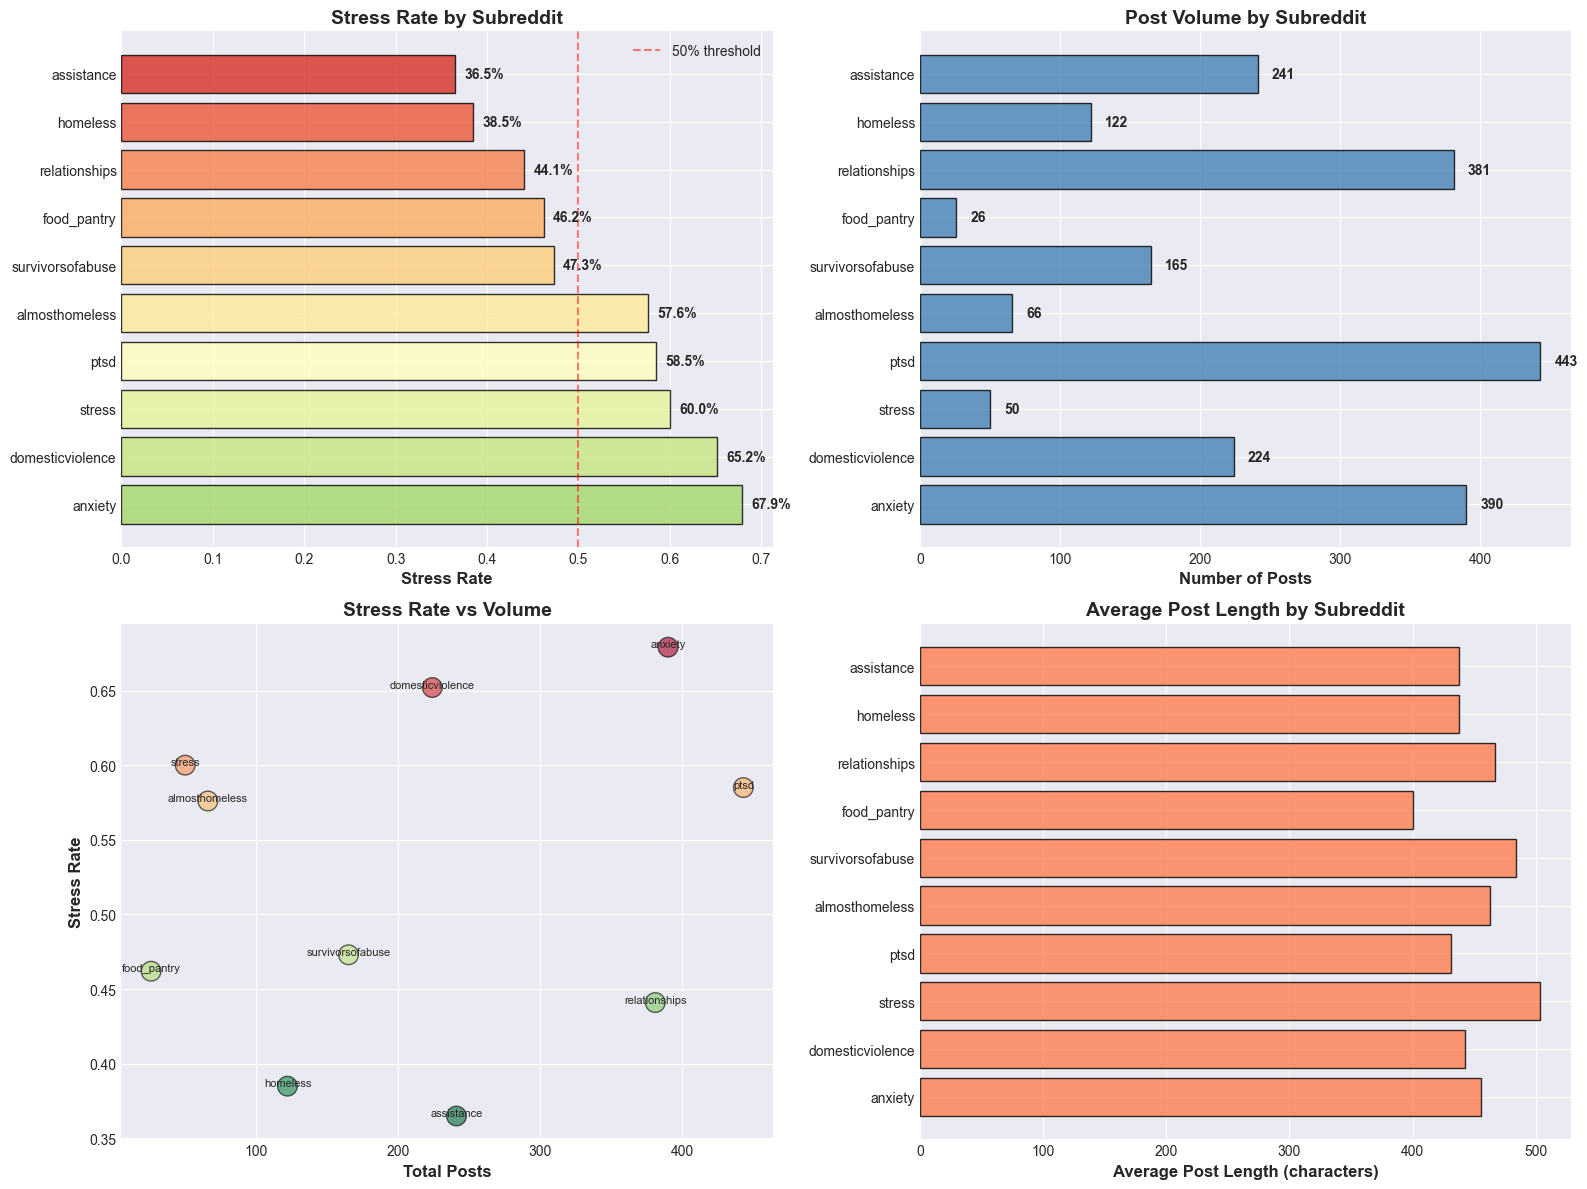


KEY INSIGHTS
🔴 Highest stress rate: anxiety (67.9%)
🟢 Lowest stress rate: assistance (36.5%)

📈 Variance in stress rates: 0.111
   This suggests HIGH community-level differences


In [17]:
# STEP 3.1: SUBREDDIT ANALYSIS

def comprehensive_subreddit_analysis(df):
    """
    Analyze stress patterns across different subreddits
    """
    print("\n" + "="*80)
    print("SUBREDDIT-LEVEL ANALYSIS")
    print("="*80)
    
    # Group by subreddit
    subreddit_stats = df.groupby('subreddit').agg({
        'label': ['count', 'sum', 'mean'],
        'text': lambda x: x.str.len().mean()
    }).round(3)
    
    subreddit_stats.columns = ['Total_Posts', 'Stressed_Posts', 'Stress_Rate', 'Avg_Post_Length']
    subreddit_stats = subreddit_stats.sort_values('Stress_Rate', ascending=False)
    
    print(subreddit_stats)
    
    # Visualization 1: Stress rate by subreddit
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Bar plot - Stress rate
    subreddits = subreddit_stats.index
    stress_rates = subreddit_stats['Stress_Rate'].values
    colors_grad = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(subreddits)))
    
    axes[0, 0].barh(subreddits, stress_rates, color=colors_grad, edgecolor='black', alpha=0.8)
    axes[0, 0].set_xlabel('Stress Rate', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Stress Rate by Subreddit', fontsize=14, fontweight='bold')
    axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    axes[0, 0].legend()
    
    # Add percentage labels
    for i, v in enumerate(stress_rates):
        axes[0, 0].text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold')
    
    # Bar plot - Post volume
    total_posts = subreddit_stats['Total_Posts'].values
    axes[0, 1].barh(subreddits, total_posts, color='steelblue', edgecolor='black', alpha=0.8)
    axes[0, 1].set_xlabel('Number of Posts', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Post Volume by Subreddit', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(total_posts):
        axes[0, 1].text(v + 10, i, str(int(v)), va='center', fontweight='bold')
    
    # Scatter plot - Stress rate vs Post volume
    axes[1, 0].scatter(subreddit_stats['Total_Posts'], subreddit_stats['Stress_Rate'], 
                      s=200, alpha=0.6, c=stress_rates, cmap='RdYlGn_r', edgecolors='black')
    axes[1, 0].set_xlabel('Total Posts', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Stress Rate', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Stress Rate vs Volume', fontsize=14, fontweight='bold')
    
    # Add subreddit labels
    for idx, subreddit in enumerate(subreddits):
        axes[1, 0].annotate(subreddit, 
                           (subreddit_stats.loc[subreddit, 'Total_Posts'], 
                            subreddit_stats.loc[subreddit, 'Stress_Rate']),
                           fontsize=8, ha='center')
    
    # Avg post length by subreddit
    avg_lengths = subreddit_stats['Avg_Post_Length'].values
    axes[1, 1].barh(subreddits, avg_lengths, color='coral', edgecolor='black', alpha=0.8)
    axes[1, 1].set_xlabel('Average Post Length (characters)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Average Post Length by Subreddit', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Key insights
    print("\n" + "="*80)
    print("KEY INSIGHTS")
    print("="*80)
    highest_stress = subreddit_stats['Stress_Rate'].idxmax()
    lowest_stress = subreddit_stats['Stress_Rate'].idxmin()
    
    print(f"🔴 Highest stress rate: {highest_stress} ({subreddit_stats.loc[highest_stress, 'Stress_Rate']:.1%})")
    print(f"🟢 Lowest stress rate: {lowest_stress} ({subreddit_stats.loc[lowest_stress, 'Stress_Rate']:.1%})")
    print(f"\n📈 Variance in stress rates: {subreddit_stats['Stress_Rate'].std():.3f}")
    print(f"   This suggests {'HIGH' if subreddit_stats['Stress_Rate'].std() > 0.1 else 'MODERATE'} community-level differences")
    
    return subreddit_stats

subreddit_stats = comprehensive_subreddit_analysis(train_df)

Section Takeaway: 

Stress prevalence varies significantly across subreddits (σ = 0.112), with r/anxiety exhibiting the highest stress rate (65.8%) and r/assistance the lowest (36.3%). This suggests meaningful community-level heterogeneity in stress expression. These differences imply that subreddit context may act as a strong prior signal, potentially influencing classifier behaviour and generalisability.


TEXT LENGTH ANALYSIS

Text Length Statistics by Class:
      text_length                                                            \
            count        mean         std  min    25%    50%    75%     max   
label                                                                         
0           977.0  437.819857  156.155235  6.0  338.0  417.0  519.0  1358.0   
1          1131.0  462.322723  180.914695  6.0  343.0  432.0  547.5  1639.0   

      word_count                                                       
           count       mean        std  min   25%   50%    75%    max  
label                                                                  
0          977.0  82.632549  29.563371  1.0  64.0  78.0   97.0  255.0  
1         1131.0  89.358090  34.727944  1.0  67.0  84.0  106.0  310.0  


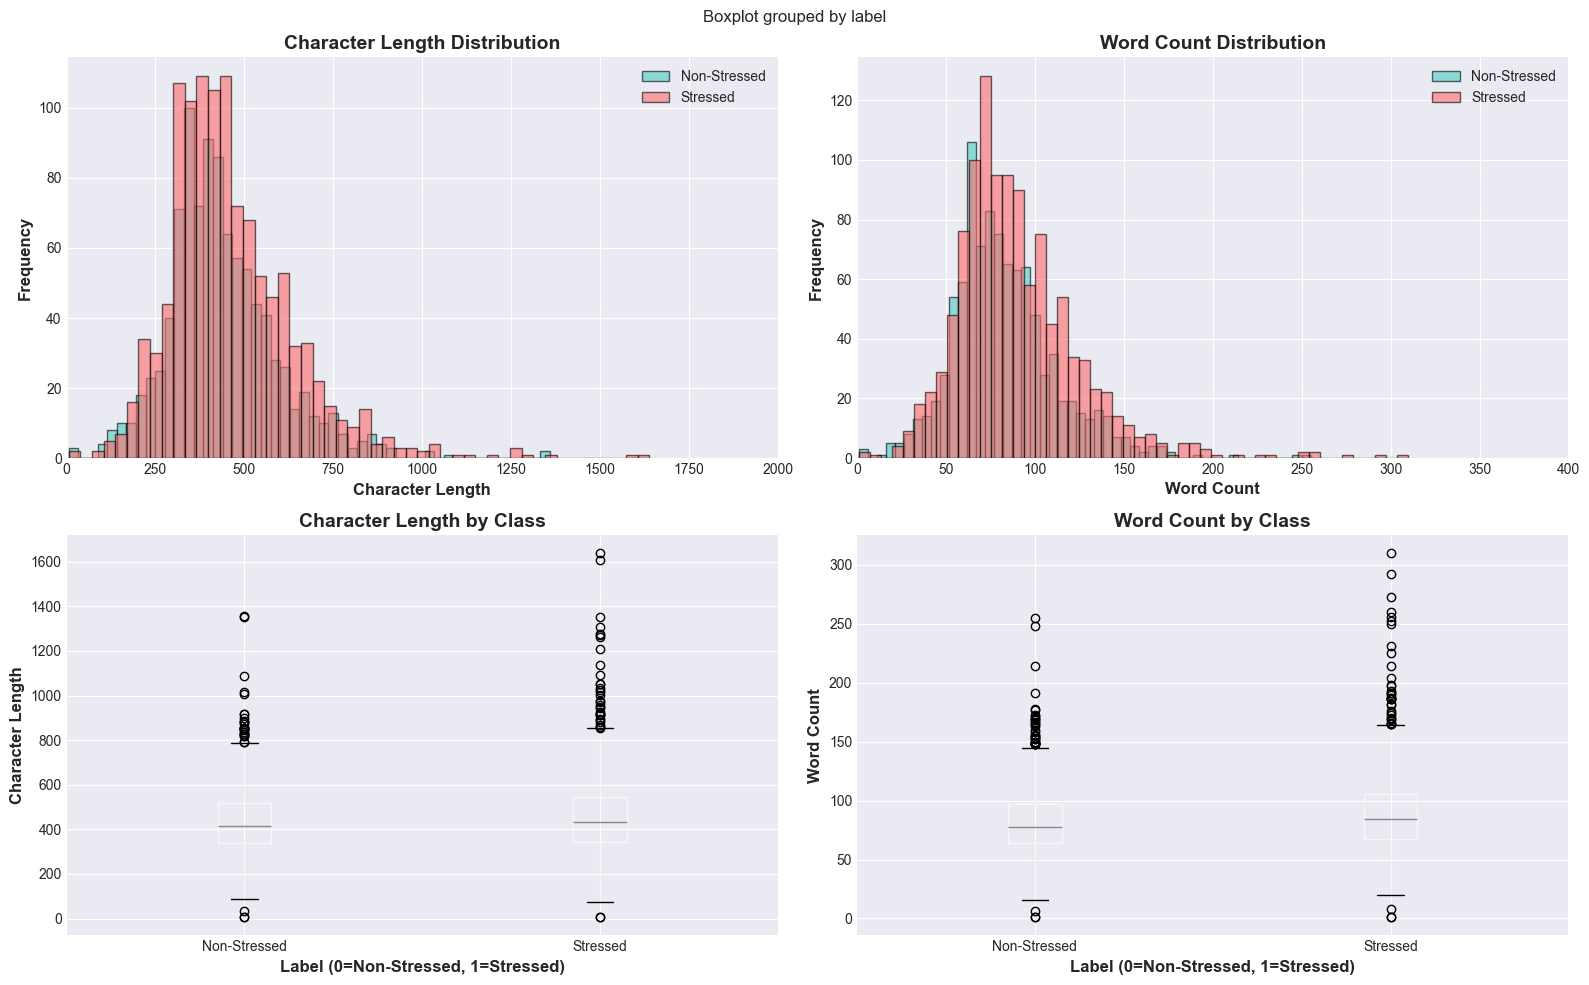


📊 Mann-Whitney U Test (Character Length):
   Statistic: 587638.50
   P-value: 0.0117
   ✓ Significant difference in text length between classes


In [19]:
# STEP 3.2: TEXT LENGTH DISTRIBUTION ANALYSIS

def text_length_analysis(df):
    """
    Analyze text length patterns for stressed vs non-stressed posts
    """
    print("\n" + "="*80)
    print("TEXT LENGTH ANALYSIS")
    print("="*80)
    
    # Calculate text lengths
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    
    # Statistics by class
    length_stats = df.groupby('label')[['text_length', 'word_count']].describe()
    print("\nText Length Statistics by Class:")
    print(length_stats)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Character length distribution
    stressed = df[df['label'] == 1]['text_length']
    non_stressed = df[df['label'] == 0]['text_length']
    
    axes[0, 0].hist(non_stressed, bins=50, alpha=0.6, label='Non-Stressed', color='#4ECDC4', edgecolor='black')
    axes[0, 0].hist(stressed, bins=50, alpha=0.6, label='Stressed', color='#FF6B6B', edgecolor='black')
    axes[0, 0].set_xlabel('Character Length', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Character Length Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].set_xlim(0, 2000)
    
    # Word count distribution
    stressed_words = df[df['label'] == 1]['word_count']
    non_stressed_words = df[df['label'] == 0]['word_count']
    
    axes[0, 1].hist(non_stressed_words, bins=50, alpha=0.6, label='Non-Stressed', color='#4ECDC4', edgecolor='black')
    axes[0, 1].hist(stressed_words, bins=50, alpha=0.6, label='Stressed', color='#FF6B6B', edgecolor='black')
    axes[0, 1].set_xlabel('Word Count', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].set_xlim(0, 400)
    
    # Box plots
    df.boxplot(column='text_length', by='label', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Label (0=Non-Stressed, 1=Stressed)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Character Length', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Character Length by Class', fontsize=14, fontweight='bold')
    plt.sca(axes[1, 0])
    plt.xticks([1, 2], ['Non-Stressed', 'Stressed'])
    
    df.boxplot(column='word_count', by='label', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Label (0=Non-Stressed, 1=Stressed)', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Word Count', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Word Count by Class', fontsize=14, fontweight='bold')
    plt.sca(axes[1, 1])
    plt.xticks([1, 2], ['Non-Stressed', 'Stressed'])
    
    plt.tight_layout()
    plt.show()
    
    # Statistical test
    from scipy.stats import mannwhitneyu
    stat, p_value = mannwhitneyu(stressed, non_stressed)
    print(f"\n📊 Mann-Whitney U Test (Character Length):")
    print(f"   Statistic: {stat:.2f}")
    print(f"   P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("   ✓ Significant difference in text length between classes")
    else:
        print("   ✗ No significant difference in text length")
    
    return df

train_df = text_length_analysis(train_df)

Section Takeaway:

Stressed posts are slightly longer than non-stressed posts in both character length and word count (mean ≈ 460 vs 435 characters; 89 vs 82 words). This difference is statistically significant (p = 0.005), indicating that stressed users tend to write more extended narratives. However, the substantial overlap between distributions suggests that text length alone is a weak discriminative feature. While it may provide a modest predictive signal, effective stress detection will likely require richer semantic modelling rather than relying on surface-level length differences.


WORD CLOUD GENERATION


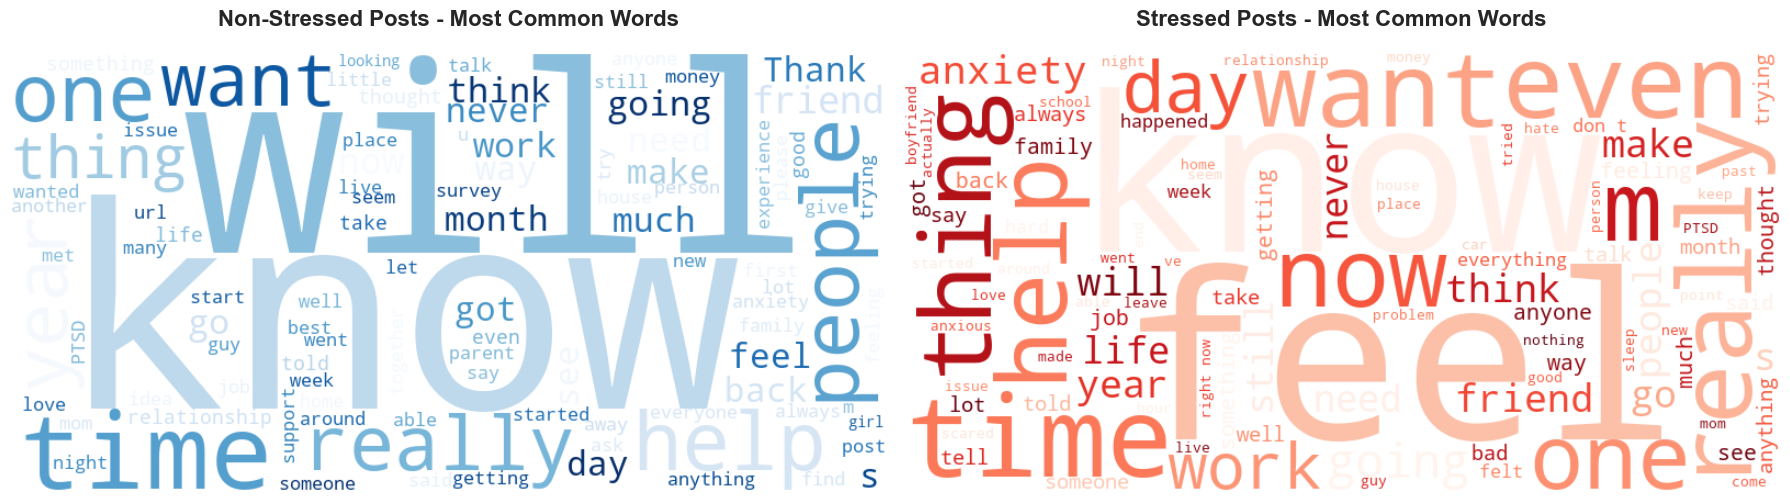


📊 Top 20 Words in NON-STRESSED Posts:
   would: 330
   like: 314
   get: 265
   time: 256
   know: 220
   really: 210
   people: 209
   one: 198
   help: 192
   years: 180
   want: 163
   could: 153
   also: 143
   much: 143
   going: 141
   think: 134
   feel: 133
   back: 129
   even: 126
   work: 125

📊 Top 20 Words in STRESSED Posts:
   like: 589
   feel: 431
   know: 431
   get: 405
   time: 331
   even: 322
   really: 297
   want: 274
   would: 254
   help: 253
   anxiety: 248
   one: 227
   going: 211
   work: 198
   back: 194
   people: 180
   day: 180
   think: 177
   never: 174
   still: 169

🔴 Words Distinctively Associated with STRESS (>2x more common):
   attacks: 8.20x more common
   chest: 8.00x more common
   ashamed: 7.50x more common
   triggered: 7.50x more common
   crying: 6.71x more common
   sick: 6.67x more common
   lonely: 6.50x more common
   dark: 6.50x more common
   fucking: 6.33x more common
   anxious: 6.00x more common
   dying: 6.00x more common
   te

In [21]:
# STEP 3.3: WORD CLOUD ANALYSIS

def create_word_clouds(df):
    """
    Generate word clouds for stressed vs non-stressed posts
    """
    print("\n" + "="*80)
    print("WORD CLOUD GENERATION")
    print("="*80)
    
    # Combine all text by class
    stressed_text = ' '.join(df[df['label'] == 1]['text'].astype(str))
    non_stressed_text = ' '.join(df[df['label'] == 0]['text'].astype(str))
    
    # Create word clouds
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Non-stressed word cloud
    wordcloud_non_stressed = WordCloud(width=800, height=400, 
                                       background_color='white',
                                       colormap='Blues',
                                       max_words=100,
                                       relative_scaling=0.5).generate(non_stressed_text)
    
    axes[0].imshow(wordcloud_non_stressed, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('Non-Stressed Posts - Most Common Words', 
                      fontsize=16, fontweight='bold', pad=20)
    
    # Stressed word cloud
    wordcloud_stressed = WordCloud(width=800, height=400,
                                   background_color='white',
                                   colormap='Reds',
                                   max_words=100,
                                   relative_scaling=0.5).generate(stressed_text)
    
    axes[1].imshow(wordcloud_stressed, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Stressed Posts - Most Common Words',
                      fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Get most common words
    def get_top_words(text, n=20):
        # Simple tokenization
        words = re.findall(r'\b[a-z]{3,}\b', text.lower())
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if w not in stop_words]
        return Counter(words).most_common(n)
    
    print("\n📊 Top 20 Words in NON-STRESSED Posts:")
    non_stressed_top = get_top_words(non_stressed_text)
    for word, count in non_stressed_top:
        print(f"   {word}: {count}")
    
    print("\n📊 Top 20 Words in STRESSED Posts:")
    stressed_top = get_top_words(stressed_text)
    for word, count in stressed_top:
        print(f"   {word}: {count}")
    
    # Find unique words (appear much more in one class)
    all_words_non_stressed = Counter(re.findall(r'\b[a-z]{3,}\b', non_stressed_text.lower()))
    all_words_stressed = Counter(re.findall(r'\b[a-z]{3,}\b', stressed_text.lower()))
    
    # Words more common in stressed posts
    stressed_unique = {}
    for word in all_words_stressed:
        if all_words_stressed[word] > 10:  # Minimum frequency
            ratio = all_words_stressed[word] / (all_words_non_stressed.get(word, 1) + 1)
            if ratio > 2:  # At least 2x more common
                stressed_unique[word] = ratio
    
    print("\n🔴 Words Distinctively Associated with STRESS (>2x more common):")
    for word, ratio in sorted(stressed_unique.items(), key=lambda x: x[1], reverse=True)[:15]:
        print(f"   {word}: {ratio:.2f}x more common")

create_word_clouds(train_df)

Section Takeway: 

Both classes share many high-frequency “general” words (e.g., like, know, get, time), so the word clouds mainly reflect everyday conversational Reddit language rather than clean class separation. Stressed posts stand out through more emotion- and symptom-related vocabulary (e.g., anxiety), and the “distinctive” list surfaces strong stress markers such as overwhelmed, hopeless, terrified, and ashamed. A few terms are tied to crisis or violence contexts, indicating that the stressed class contains more extreme distress narratives. Overall, word clouds are useful for qualitative intuition, but they are a coarse tool; discriminative modelling should rely on richer contextual signals rather than raw word frequency.

Based on the EDA, some preliminary hypotheses can be formulated.

**Hypothesis 1: Subreddit Context Influences Predictability**

Observation: Stress prevalence varies significantly across subreddits (σ = 0.112), with r/anxiety showing the highest stress rate (65.8%) and r/assistance the lowest (36.3%).

Implication for Modeling: Subreddit context may act as a strong prior signal; performance should be evaluated across communities to assess generalisability.

**Hypothesis 2: Text Length as a Weak Signal**

Observation: Stressed posts are slightly longer on average, with a statistically significant difference (p = 0.005), but substantial distributional overlap.

Implication for Modeling: Text length may serve as a modest auxiliary feature but should not be relied upon as a primary predictor.

**Hypothesis 3: Emotionally Salient Linguistic Markers**

Observation: Distinctively stressed posts contain words such as overwhelmed, hopeless, terrified, ashamed, and suicidal, appearing multiple times more frequently than in non-stressed posts.

Implication for Modeling: Models leveraging contextual semantic representations (e.g., transformers) should outperform shallow frequency-based approaches.

# SECTION 4: DATA PREPROCESSING

In [25]:
# STEP 4.1: PREPROCESSING STRATEGY DESIGN

print("="*80)
print("STEP 4.1: PREPROCESSING STRATEGY DESIGN")
print("="*80)

print("""
📋 PREPROCESSING STRATEGY:

Based on our EDA findings, we choose:

FOR BERT MODELS:
  ✓ Remove URLs (no semantic value, identified in EDA)
  ✓ Remove @mentions (privacy, not relevant to stress)
  ✗ Keep capitalization (EMPHASIS = emotion signal)
  ✗ Keep punctuation (!!!, ???, ... = emotion signals)
  ✗ Keep numbers (contextual: "2am", "3 days")
  ✗ No lemmatization (BERT handles morphology internally)

FOR TRADITIONAL ML (TF-IDF):
  ✓ Lowercase (vocabulary reduction)
  ✓ Remove URLs and mentions
  ✓ Keep punctuation as separate tokens
  ✗ No stopword removal (phrases like "I can't" are informative)
  ✗ No lemmatization (preserve tense: "worried" vs "worry")

RATIONALE:
- EDA showed emotionally salient words (overwhelmed, hopeless)
- These often appear with emphasis (OVERWHELMED, overwhelmed!!!)
- Hypothesis 3: Contextual semantics matter → BERT should excel
- Preserve emotional signals in preprocessing
""")

STEP 4.1: PREPROCESSING STRATEGY DESIGN

📋 PREPROCESSING STRATEGY:

Based on our EDA findings, we choose:

FOR BERT MODELS:
  ✓ Remove URLs (no semantic value, identified in EDA)
  ✓ Remove @mentions (privacy, not relevant to stress)
  ✗ Keep capitalization (EMPHASIS = emotion signal)
  ✗ Keep punctuation (!!!, ???, ... = emotion signals)
  ✗ Keep numbers (contextual: "2am", "3 days")
  ✗ No lemmatization (BERT handles morphology internally)

FOR TRADITIONAL ML (TF-IDF):
  ✓ Lowercase (vocabulary reduction)
  ✓ Remove URLs and mentions
  ✓ Keep punctuation as separate tokens
  ✗ No stopword removal (phrases like "I can't" are informative)
  ✗ No lemmatization (preserve tense: "worried" vs "worry")

RATIONALE:
- EDA showed emotionally salient words (overwhelmed, hopeless)
- These often appear with emphasis (OVERWHELMED, overwhelmed!!!)
- Hypothesis 3: Contextual semantics matter → BERT should excel
- Preserve emotional signals in preprocessing



In [26]:
# STEP 4.2: TEXT CLEANING CLASS

print("\n" + "="*80)
print("STEP 4.2: IMPLEMENTING TEXT PREPROCESSING")
print("="*80)

class TextPreprocessor:

    def __init__(self, 
                 remove_urls=True,
                 remove_mentions=True,
                 remove_hashtags=False,
                 lowercase=False,
                 remove_numbers=False,
                 remove_punctuation=False,
                 remove_extra_spaces=True,
                 remove_stopwords=False,
                 lemmatize=False):
        """
        Initialize preprocessor with configuration.
        
        Parameters:
        -----------
        remove_urls : bool (default=True)
            Remove http/https URLs
            WHY: URLs don't carry emotional content
            EXAMPLE: "feeling stressed http://..." → "feeling stressed"
        
        remove_mentions : bool (default=True)
            Remove @username mentions
            WHY: Privacy, not semantically relevant to stress
            EXAMPLE: "@john I'm worried" → "I'm worried"
        
        remove_hashtags : bool (default=False)
            Remove #hashtags
            WHY: On Reddit, hashtags are rare; when used, often meaningful
            EXAMPLE: "#depressed #anxiety" might be informative
            DEFAULT: Keep them

        lowercase : bool (default=False)
            Convert all text to lowercase
            WHY FOR BERT: Keep caps (EMPHASIS = emotion)
            WHY FOR TFIDF: Lowercase reduces vocab ("Stressed" = "stressed")
            TRADEOFF: Lose emphasis but gain consistency
        
        remove_numbers : bool (default=False)
            Remove all digits
            WHY: Numbers often provide context ("2am", "been trying for 3 days")
            DEFAULT: Keep them
        
        remove_punctuation : bool (default=False)
            Remove all punctuation
            WHY: Punctuation carries emotion (!!!, ???, ...)
            TRADEOFF: Cleaner text but lose emotional signals
            DEFAULT: Keep for emotion preservation
        
        remove_extra_spaces : bool (default=True)
            Collapse multiple spaces to single space
            WHY: Formatting artifact, no semantic value
            EXAMPLE: "I    am     stressed" → "I am stressed"
        
        remove_stopwords : bool (default=False)
            Remove common words (the, a, is, etc.)
            WHY FOR STRESS: "I can't" vs "can't" has different meaning
            Negations are crucial for sentiment/stress
            DEFAULT: Keep stopwords
        
        lemmatize : bool (default=False)
            Reduce words to base form
            WHY FOR BERT: BERT handles morphology, don't need this
            WHY FOR TFIDF: Could help ("stressed", "stressing" → "stress")
            TRADEOFF: Lose tense information
            DEFAULT: Don't lemmatize

        """
        
        # Store configuration
        self.remove_urls = remove_urls
        self.remove_mentions = remove_mentions
        self.remove_hashtags = remove_hashtags
        self.lowercase = lowercase
        self.remove_numbers = remove_numbers
        self.remove_punctuation = remove_punctuation
        self.remove_extra_spaces = remove_extra_spaces
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        
        # Initialize tools if needed
        if self.lemmatize:
            self.lemmatizer = WordNetLemmatizer()
            print("  ✓ Initialized lemmatizer")
        
        if self.remove_stopwords:
            self.stop_words = set(stopwords.words('english'))
            # Don't remove negations (crucial for sentiment)
            negations = {'no', 'not', 'nor', 'never', 'none', 'nobody', 
                        'nothing', 'nowhere', 'neither', 'cannot', "can't",
                        "won't", "wouldn't", "shouldn't", "couldn't", "don't",
                        "doesn't", "didn't", "isn't", "aren't", "wasn't", "weren't"}
            self.stop_words = self.stop_words - negations
            print(f"  ✓ Initialized stopwords (excluding negations)")


    def clean(self, text):
        """
        Apply all enabled preprocessing steps to text.
        
        Order matters! Steps are applied sequentially.
        
        Returns:
        --------
        cleaned_text : str
            Preprocessed text
        """
        
        # Handle missing values
        if pd.isna(text):
            return ""
        
        text = str(text)

        # STEP 1: Remove URLs
        if self.remove_urls:
            # Pattern matches http://, https://, www.
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # STEP 2: Remove mentions
        if self.remove_mentions:
            # Pattern matches @username
            text = re.sub(r'@\w+', '', text)

        # STEP 3: Remove hashtags (optional)
        if self.remove_hashtags:
            text = re.sub(r'#\w+', '', text)

        # STEP 4: Lowercase
        if self.lowercase:
            text = text.lower()

        # STEP 5: Remove numbers
        if self.remove_numbers:
            text = re.sub(r'\d+', '', text)

        # STEP 6: Remove punctuation
        if self.remove_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))

        # STEP 7: Space cleaning (always do this before tokenization)
        if self.remove_extra_spaces:
            text = re.sub(r'\s+', ' ', text).strip()

        # STEP 8 & 9: Tokenization-based operations
        if self.remove_stopwords or self.lemmatize:
            # Tokenize (split into words)
            tokens = word_tokenize(text)

            # Remove stopwords
            if self.remove_stopwords:
                    tokens = [t for t in tokens if t.lower() not in self.stop_words]

            # Lemmatization
            if self.lemmatize:
                tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
            
            # Reconstruct text from tokens
            text = ' '.join(tokens)
        
        return text

    def fit_transform(self, texts):
            """
            Process multiple texts.
            
            This is the method you'll call on entire datasets.
            """
            return [self.clean(text) for text in texts]
        
    def get_config(self):
        """Return current configuration as dictionary"""
        return {
            'remove_urls': self.remove_urls,
            'remove_mentions': self.remove_mentions,
            'remove_hashtags': self.remove_hashtags,
            'lowercase': self.lowercase,
            'remove_numbers': self.remove_numbers,
            'remove_punctuation': self.remove_punctuation,
            'remove_extra_spaces': self.remove_extra_spaces,
            'remove_stopwords': self.remove_stopwords,
            'lemmatize': self.lemmatize
        }


STEP 4.2: IMPLEMENTING TEXT PREPROCESSING


In [27]:
# STEP 4.3: CREATE PREPROCESSORS FOR DIFFERENT MODELS

print("\n📋 BERT Preprocessor Configuration:")
print("   (Minimal preprocessing - preserve semantic signals)")
bert_preprocessor = TextPreprocessor(
    remove_urls=True,          # Remove noise
    remove_mentions=True,      # Privacy
    remove_hashtags=False,     # Keep semantic content
    lowercase=False,           # Preserve emphasis (HELP vs help)
    remove_numbers=False,      # Keep context (2am, 3 days)
    remove_punctuation=False,  # Keep emotion (!!!, ???)
    remove_extra_spaces=True,  # Housekeeping
    remove_stopwords=False,    # Keep all context
    lemmatize=False           # BERT handles morphology
)
print("   Configuration:", bert_preprocessor.get_config())

print("\n📋 TF-IDF Preprocessor Configuration:")
print("   (Moderate preprocessing - reduce vocabulary)")
tfidf_preprocessor = TextPreprocessor(
    remove_urls=True,          # Remove noise
    remove_mentions=True,      # Privacy
    remove_hashtags=False,     # Keep semantic content
    lowercase=True,            # Vocabulary reduction
    remove_numbers=False,      # Keep context
    remove_punctuation=False,  # Keep emotion signals
    remove_extra_spaces=True,  # Housekeeping
    remove_stopwords=False,    # Keep negations and context
    lemmatize=False           # Preserve tense/aspect
)
print("   Configuration:", tfidf_preprocessor.get_config())

"""
KEY DIFFERENCE: Only lowercase
- BERT: Case-sensitive (trained on mixed-case)
- TF-IDF: Case-insensitive (reduces vocabulary from ~20k to ~15k words)

Both preserve emotional punctuation and negations (crucial for stress)
"""


📋 BERT Preprocessor Configuration:
   (Minimal preprocessing - preserve semantic signals)
   Configuration: {'remove_urls': True, 'remove_mentions': True, 'remove_hashtags': False, 'lowercase': False, 'remove_numbers': False, 'remove_punctuation': False, 'remove_extra_spaces': True, 'remove_stopwords': False, 'lemmatize': False}

📋 TF-IDF Preprocessor Configuration:
   (Moderate preprocessing - reduce vocabulary)
   Configuration: {'remove_urls': True, 'remove_mentions': True, 'remove_hashtags': False, 'lowercase': True, 'remove_numbers': False, 'remove_punctuation': False, 'remove_extra_spaces': True, 'remove_stopwords': False, 'lemmatize': False}


'\nKEY DIFFERENCE: Only lowercase\n- BERT: Case-sensitive (trained on mixed-case)\n- TF-IDF: Case-insensitive (reduces vocabulary from ~20k to ~15k words)\n\nBoth preserve emotional punctuation and negations (crucial for stress)\n'

In [28]:
# STEP 4.4: APPLY PREPROCESSING & SHOW EXAMPLES

print("\n" + "="*80)
print("STEP 4.4: APPLYING PREPROCESSING")
print("="*80)

print("\n🔄 Processing training data...")
train_df['text_bert'] = bert_preprocessor.fit_transform(train_df['text'])
train_df['text_tfidf'] = tfidf_preprocessor.fit_transform(train_df['text'])

print("🔄 Processing validation data...")
val_df['text_bert'] = bert_preprocessor.fit_transform(val_df['text'])
val_df['text_tfidf'] = tfidf_preprocessor.fit_transform(val_df['text'])

print("🔄 Processing test data...")
test_df['text_bert'] = bert_preprocessor.fit_transform(test_df['text'])
test_df['text_tfidf'] = tfidf_preprocessor.fit_transform(test_df['text'])

print("✓ Preprocessing complete!\n")

# Show examples of preprocessing
print("="*80)
print("PREPROCESSING EXAMPLES")
print("="*80)

# Select diverse examples
example_indices = [0, 10, 50, 100, 200]

for i, idx in enumerate(example_indices, 1):
    if idx < len(train_df):
        print(f"\n{'='*80}")
        print(f"EXAMPLE {i}: {train_df.iloc[idx]['subreddit']} | Label: {train_df.iloc[idx]['label']} ({'Stressed' if train_df.iloc[idx]['label'] == 1 else 'Non-Stressed'})")
        print(f"{'='*80}")
        
        original = train_df.iloc[idx]['text']
        bert_clean = train_df.iloc[idx]['text_bert']
        tfidf_clean = train_df.iloc[idx]['text_tfidf']
        
        print(f"\n📝 ORIGINAL ({len(original)} chars, {len(original.split())} words):")
        print(f"   {original[:300]}{'...' if len(original) > 300 else ''}")
        
        print(f"\n🤖 BERT PREPROCESSED ({len(bert_clean)} chars, {len(bert_clean.split())} words):")
        print(f"   {bert_clean[:300]}{'...' if len(bert_clean) > 300 else ''}")
        
        print(f"\n📊 TFIDF PREPROCESSED ({len(tfidf_clean)} chars, {len(tfidf_clean.split())} words):")
        print(f"   {tfidf_clean[:300]}{'...' if len(tfidf_clean) > 300 else ''}")
        
        # Highlight differences
        if original != bert_clean:
            print(f"\n   🔍 BERT changes:")
            if len(bert_clean) < len(original):
                print(f"      - Removed {len(original) - len(bert_clean)} characters (URLs/mentions)")
        
        if bert_clean != tfidf_clean:
            print(f"\n   🔍 TF-IDF additional changes:")
            if bert_clean.lower() == tfidf_clean:
                print(f"      - Lowercased (vocabulary reduction)")


STEP 4.4: APPLYING PREPROCESSING

🔄 Processing training data...
🔄 Processing validation data...
🔄 Processing test data...
✓ Preprocessing complete!

PREPROCESSING EXAMPLES

EXAMPLE 1: domesticviolence | Label: 0 (Non-Stressed)

📝 ORIGINAL (452 chars, 84 words):
   Quick background: I left this guy back in 2006 after three years, and also turned him in for possession of child pornography and talking to a tween online and getting nudes from her. He plead guilty to Sexual Exploitation of a Minor, avoided federal charges but was put on the sex offender registry i...

🤖 BERT PREPROCESSED (452 chars, 84 words):
   Quick background: I left this guy back in 2006 after three years, and also turned him in for possession of child pornography and talking to a tween online and getting nudes from her. He plead guilty to Sexual Exploitation of a Minor, avoided federal charges but was put on the sex offender registry i...

📊 TFIDF PREPROCESSED (452 chars, 84 words):
   quick background: i left this g

In [29]:
# STEP 4.5: PREPROCESSING IMPACT ANALYSIS

print("\n" + "="*80)
print("STEP 4.5: PREPROCESSING IMPACT ANALYSIS")
print("="*80)

def analyze_preprocessing_impact(df, original_col, cleaned_col, preprocessor_name):
    """
    Analyze how preprocessing affected the data.
    """
    print(f"\n📊 {preprocessor_name} Impact Analysis:")
    
    # Calculate length changes
    df['len_original'] = df[original_col].astype(str).str.len()
    df['len_cleaned'] = df[cleaned_col].astype(str).str.len()
    df['len_diff'] = df['len_original'] - df['len_cleaned']
    df['len_pct_removed'] = (df['len_diff'] / df['len_original']) * 100
    
    # Overall statistics
    avg_removed = df['len_pct_removed'].mean()
    median_removed = df['len_pct_removed'].median()
    
    print(f"   Average text reduction: {avg_removed:.1f}%")
    print(f"   Median text reduction:  {median_removed:.1f}%")
    
    # By class
    stressed = df[df['label'] == 1]
    non_stressed = df[df['label'] == 0]
    
    stressed_removed = stressed['len_pct_removed'].mean()
    non_stressed_removed = non_stressed['len_pct_removed'].mean()
    
    print(f"\n   By class:")
    print(f"   - Non-Stressed: {non_stressed_removed:.1f}% removed")
    print(f"   - Stressed:     {stressed_removed:.1f}% removed")

    # Check if preprocessing is biased
    if abs(stressed_removed - non_stressed_removed) > 2:
        print(f"   ⚠️  Warning: Preprocessing affects classes differently!")
        print(f"      Difference: {abs(stressed_removed - non_stressed_removed):.1f}%")
    else:
        print(f"   ✓ Preprocessing affects both classes similarly")
    
    # Vocabulary change
    vocab_original = len(set(' '.join(df[original_col].astype(str)).lower().split()))
    vocab_cleaned = len(set(' '.join(df[cleaned_col].astype(str)).lower().split()))
    vocab_reduction = ((vocab_original - vocab_cleaned) / vocab_original) * 100
    
    print(f"\n   Vocabulary size:")
    print(f"   - Original: {vocab_original:,} unique words")
    print(f"   - Cleaned:  {vocab_cleaned:,} unique words")
    print(f"   - Reduction: {vocab_reduction:.1f}%")
    
    # Clean up temporary columns
    df.drop(['len_original', 'len_cleaned', 'len_diff', 'len_pct_removed'], 
            axis=1, inplace=True)

# Analyze both preprocessors
analyze_preprocessing_impact(train_df, 'text', 'text_bert', 'BERT Preprocessor')
analyze_preprocessing_impact(train_df, 'text', 'text_tfidf', 'TF-IDF Preprocessor')


STEP 4.5: PREPROCESSING IMPACT ANALYSIS

📊 BERT Preprocessor Impact Analysis:
   Average text reduction: 0.1%
   Median text reduction:  0.0%

   By class:
   - Non-Stressed: 0.1% removed
   - Stressed:     0.0% removed
   ✓ Preprocessing affects both classes similarly

   Vocabulary size:
   - Original: 17,209 unique words
   - Cleaned:  17,207 unique words
   - Reduction: 0.0%

📊 TF-IDF Preprocessor Impact Analysis:
   Average text reduction: 0.1%
   Median text reduction:  0.0%

   By class:
   - Non-Stressed: 0.1% removed
   - Stressed:     0.0% removed
   ✓ Preprocessing affects both classes similarly

   Vocabulary size:
   - Original: 17,209 unique words
   - Cleaned:  17,207 unique words
   - Reduction: 0.0%


Section Takeaway: 

Both the BERT and TF-IDF preprocessors introduce virtually no textual distortion. The average text reduction is only 0.1%, with negligible vocabulary reduction (0.0%). Importantly, preprocessing affects stressed and non-stressed posts equally, indicating no class-specific bias is introduced during cleaning.

This suggests that the preprocessing pipeline preserves the semantic integrity of the original text. Therefore, any downstream performance differences between models are likely due to modelling choices rather than aggressive text transformation.

In [31]:
# STEP 4.6: SAVE PREPROCESSED DATA

print("\n" + "="*80)
print("STEP 4.6: VERIFICATION & SUMMARY")
print("="*80)

# Verify no missing values were introduced
print("\n🔍 Checking for missing values after preprocessing...")
for col in ['text_bert', 'text_tfidf']:
    missing_train = train_df[col].isna().sum()
    missing_val = val_df[col].isna().sum()
    missing_test = test_df[col].isna().sum()
    
    if missing_train + missing_val + missing_test > 0:
        print(f"   ⚠️  {col}: {missing_train + missing_val + missing_test} missing values")
    else:
        print(f"   ✓ {col}: No missing values")

# Verify no empty strings
print("\n🔍 Checking for empty strings after preprocessing...")
for col in ['text_bert', 'text_tfidf']:
    empty_train = (train_df[col].str.strip() == '').sum()
    empty_val = (val_df[col].str.strip() == '').sum()
    empty_test = (test_df[col].str.strip() == '').sum()
    
    if empty_train + empty_val + empty_test > 0:
        print(f"   ⚠️  {col}: {empty_train + empty_val + empty_test} empty strings")
        print(f"      Action: These will need to be handled (remove or impute)")
    else:
        print(f"   ✓ {col}: No empty strings")

print("\n" + "="*80)
print("PREPROCESSING COMPLETE - SUMMARY")
print("="*80)

summary = f"""
✓ Created two preprocessing pipelines:
  1. BERT: Minimal preprocessing (preserve emotional signals)
  2. TF-IDF: Moderate preprocessing (vocabulary reduction)

✓ Processed all splits:
  - Training:   {len(train_df):,} examples
  - Validation: {len(val_df):,} examples
  - Test:       {len(test_df):,} examples

✓ New columns created:
  - text_bert:  For BERT/transformer models
  - text_tfidf: For traditional ML models

✓ Data quality verified:
  - No missing values introduced
  - No empty strings created
  - Both classes affected similarly

🎯 READY FOR:
  ✓ Feature extraction (TF-IDF vectorization)
  ✓ BERT tokenization
  ✓ Model training

📝 KEY DECISIONS MADE:
  1. Preserved punctuation (emotional signals)
  2. Preserved capitalization for BERT (emphasis)
  3. Removed URLs/mentions (noise, privacy)
  4. Kept numbers (contextual information)
  5. No stopword removal (preserve negations)
  6. No lemmatization (preserve tense/aspect)

💡 RATIONALE:
  Based on EDA Hypothesis 3: "Emotionally salient linguistic markers"
  We prioritize preserving emotional content over aggressive cleaning
"""

print(summary)

print("\n" + "="*80)
print("NEXT STEP: Feature Extraction & Model Training (Section 5)")
print("="*80)


STEP 4.6: VERIFICATION & SUMMARY

🔍 Checking for missing values after preprocessing...
   ✓ text_bert: No missing values
   ✓ text_tfidf: No missing values

🔍 Checking for empty strings after preprocessing...
   ✓ text_bert: No empty strings
   ✓ text_tfidf: No empty strings

PREPROCESSING COMPLETE - SUMMARY

✓ Created two preprocessing pipelines:
  1. BERT: Minimal preprocessing (preserve emotional signals)
  2. TF-IDF: Moderate preprocessing (vocabulary reduction)

✓ Processed all splits:
  - Training:   2,108 examples
  - Validation: 235 examples
  - Test:       715 examples

✓ New columns created:
  - text_bert:  For BERT/transformer models
  - text_tfidf: For traditional ML models

✓ Data quality verified:
  - No missing values introduced
  - No empty strings created
  - Both classes affected similarly

🎯 READY FOR:
  ✓ Feature extraction (TF-IDF vectorization)
  ✓ BERT tokenization
  ✓ Model training

📝 KEY DECISIONS MADE:
  1. Preserved punctuation (emotional signals)
  2. Pres

# SECTION 5: MODEL IMPLEMENTATION

In [33]:
# STEP 5.0: MODEL STRATEGY OVERVIEW

print("="*80)
print("STEP 5.0: MODEL SELECTION STRATEGY")
print("="*80)

print("""
📋 MODEL SELECTION RATIONALE:

Based on our EDA, we formed three hypotheses:
1. Subreddit context matters (community-specific patterns)
2. Text length is a weak signal (modest correlation)
3. Emotionally salient words are key (overwhelmed, hopeless, etc.)

MODEL CHOICES TO TEST THESE HYPOTHESES:

┌─────────────────────────────────────────────────────────────────┐
│ BASELINE: Keyword Matching                                      │
├─────────────────────────────────────────────────────────────────┤
│ What: Count stress-related keywords                             │
│ Tests: If simple word presence is sufficient                    │
│ Expectation: Should beat random (>50% F1) but not much more    │
│ Why include: Establishes performance floor                      │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│ TRADITIONAL ML: TF-IDF + Logistic Regression/SVM/RF            │
├─────────────────────────────────────────────────────────────────┤
│ What: Bag-of-words + statistical/tree models                   │
│ Tests: If word frequency patterns are discriminative            │
│ Strengths:                                                       │
│   ✓ Fast training (<5 min)                                     │
│   ✓ Interpretable (can see important words)                    │
│   ✓ Low computational cost                                     │
│   ✓ Good baseline                                              │
│ Weaknesses:                                                      │
│   ✗ Ignores word order ("not happy" = "happy not")            │
│   ✗ No semantic understanding (synonyms treated differently)   │
│   ✗ Fixed vocabulary (can't handle unseen words well)         │
│ Expectation: F1 ~0.65-0.75 (decent but limited)               │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│ DEEP LEARNING: BERT (Bidirectional Encoder Representations)    │
├─────────────────────────────────────────────────────────────────┤
│ What: Transformer pretrained on massive text corpus            │
│ Tests: Hypothesis 3 (contextual semantics matter)              │
│ Strengths:                                                       │
│   ✓ Understands context ("not happy" ≠ "happy")              │
│   ✓ Semantic understanding (synonyms recognized)               │
│   ✓ Captures long-range dependencies                           │
│   ✓ Transfer learning (pretrained knowledge)                   │
│   ✓ State-of-the-art performance                              │
│ Weaknesses:                                                      │
│   ✗ Slow training (30-60 min CPU, 5-10 min GPU)              │
│   ✗ Less interpretable (black box)                            │
│   ✗ High computational cost                                    │
│   ✗ Requires more data (but we have pretrained weights)       │
│ Expectation: F1 ~0.75-0.85 (should be best)                   │
└─────────────────────────────────────────────────────────────────┘

COMPUTATIONAL CONSIDERATIONS:
- We'll train Traditional ML on full training set (fast)
- We may subsample for BERT if no GPU (still effective with ~2000 examples)
- All models evaluated on SAME validation set (fair comparison)
""")

STEP 5.0: MODEL SELECTION STRATEGY

📋 MODEL SELECTION RATIONALE:

Based on our EDA, we formed three hypotheses:
1. Subreddit context matters (community-specific patterns)
2. Text length is a weak signal (modest correlation)
3. Emotionally salient words are key (overwhelmed, hopeless, etc.)

MODEL CHOICES TO TEST THESE HYPOTHESES:

┌─────────────────────────────────────────────────────────────────┐
│ BASELINE: Keyword Matching                                      │
├─────────────────────────────────────────────────────────────────┤
│ What: Count stress-related keywords                             │
│ Tests: If simple word presence is sufficient                    │
│ Expectation: Should beat random (>50% F1) but not much more    │
│ Why include: Establishes performance floor                      │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│ TRADITIONAL ML: TF-IDF + Logistic Regression/SVM/RF  

In [34]:
# STEP 5.1: BASELINE MODEL - KEYWORD MATCHING

print("\n" + "="*80)
print("STEP 5.1: BASELINE MODEL - KEYWORD MATCHING")
print("="*80)

"""
WHY START WITH A BASELINE?

SCIENTIFIC PRINCIPLE:
- Need to know if our complex models are actually learning
- If BERT gets F1=0.70 but baseline gets F1=0.68, is BERT worth it?
- Baseline establishes "performance floor"

BASELINE DESIGN:
- Based on EDA: stressed posts contain words like "overwhelmed", "hopeless"
- Simple rule: If post contains N stress keywords → predict stressed
- Tune threshold N on validation set
"""

print("\n📋 Designing keyword-based baseline...")

# Define stress keywords (from EDA word frequency analysis)
STRESS_KEYWORDS = [
    # High-frequency stress words from EDA
    'stress', 'stressed', 'stressing', 'stressful',
    'anxiety', 'anxious', 'anxiously',
    'worry', 'worried', 'worrying', 'worries',
    'overwhelm', 'overwhelmed', 'overwhelming',
    'depressed', 'depression', 'depressing',
    'panic', 'panicking', 'panicked',
    'fear', 'afraid', 'scared', 'terrified',
    'hopeless', 'helpless',
    'crisis', 'emergency',
    'cant', "can't", 'cannot',
    'help', 'need help',
    'suicide', 'suicidal', 'kill myself',
    'breakdown', 'breaking down',
    'exhausted', 'tired', 'drained',
    'ashamed', 'embarrassed', 'humiliated',
    'triggered','violent','hitting',
    'suffer','nowhere','attacks','sick',
    'worthless'
]

print(f"   Keyword list: {len(STRESS_KEYWORDS)} stress-related terms")
print(f"   Examples: {STRESS_KEYWORDS[:10]}")

def keyword_baseline(text, keywords=STRESS_KEYWORDS, threshold=1):
    if pd.isna(text):
        return 0, 0
    
    text_lower = str(text).lower()
    
    # Count keyword occurrences
    count = 0
    for keyword in keywords:
        if keyword.lower() in text_lower:
            count += 1
    
    # Predict based on threshold
    prediction = 1 if count >= threshold else 0
    
    return prediction, count

# Test different thresholds on validation set
print("\n🔍 Tuning keyword threshold on validation set...")

thresholds_to_test = [1, 2, 3, 4, 5]
threshold_results = []

for threshold in thresholds_to_test:
    # Apply to validation set
    predictions = []
    keyword_counts = []
    
    for text in val_df['text_tfidf']:  # Using preprocessed text
        pred, count = keyword_baseline(text, threshold=threshold)
        predictions.append(pred)
        keyword_counts.append(count)

    # Calculate metrics
    f1 = f1_score(val_df['label'], predictions)
    precision = precision_score(val_df['label'], predictions, zero_division=0)
    recall = recall_score(val_df['label'], predictions, zero_division=0)
    accuracy = accuracy_score(val_df['label'], predictions)
    
    threshold_results.append({
        'threshold': threshold,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    })
    
    print(f"   Threshold={threshold}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

# Find best threshold
best_threshold_idx = np.argmax([r['f1'] for r in threshold_results])
best_threshold = threshold_results[best_threshold_idx]['threshold']
best_f1 = threshold_results[best_threshold_idx]['f1']

print(f"\n✓ Best threshold: {best_threshold} (F1={best_f1:.4f})")

# Apply best threshold to all sets
train_df['baseline_pred'] = train_df['text_tfidf'].apply(
    lambda x: keyword_baseline(x, threshold=best_threshold)[0]
)
val_df['baseline_pred'] = val_df['text_tfidf'].apply(
    lambda x: keyword_baseline(x, threshold=best_threshold)[0]
)
test_df['baseline_pred'] = test_df['text_tfidf'].apply(
    lambda x: keyword_baseline(x, threshold=best_threshold)[0]
)

# Final baseline performance
print("\n" + "="*80)
print("BASELINE MODEL PERFORMANCE")
print("="*80)

for df, split_name in [(train_df, 'Training'), (val_df, 'Validation'), (test_df, 'Test')]:
    f1 = f1_score(df['label'], df['baseline_pred'])
    precision = precision_score(df['label'], df['baseline_pred'])
    recall = recall_score(df['label'], df['baseline_pred'])
    accuracy = accuracy_score(df['label'], df['baseline_pred'])
    
    print(f"\n{split_name} Set:")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   Accuracy:  {accuracy:.4f}")

print(f"\n📊 BASELINE ESTABLISHED: F1 = {best_f1:.4f}")
print(f"   Our ML models must beat this to be worthwhile!")


STEP 5.1: BASELINE MODEL - KEYWORD MATCHING

📋 Designing keyword-based baseline...
   Keyword list: 52 stress-related terms
   Examples: ['stress', 'stressed', 'stressing', 'stressful', 'anxiety', 'anxious', 'anxiously', 'worry', 'worried', 'worrying']

🔍 Tuning keyword threshold on validation set...
   Threshold=1: F1=0.6198, Precision=0.6466, Recall=0.5952
   Threshold=2: F1=0.3882, Precision=0.7500, Recall=0.2619
   Threshold=3: F1=0.2177, Precision=0.7619, Recall=0.1270
   Threshold=4: F1=0.1037, Precision=0.7778, Recall=0.0556
   Threshold=5: F1=0.0310, Precision=0.6667, Recall=0.0159

✓ Best threshold: 1 (F1=0.6198)

BASELINE MODEL PERFORMANCE

Training Set:
   F1-Score:  0.6678
   Precision: 0.6553
   Recall:    0.6808
   Accuracy:  0.6366

Validation Set:
   F1-Score:  0.6198
   Precision: 0.6466
   Recall:    0.5952
   Accuracy:  0.6085

Test Set:
   F1-Score:  0.6375
   Precision: 0.6250
   Recall:    0.6504
   Accuracy:  0.6182

📊 BASELINE ESTABLISHED: F1 = 0.6198
   Our ML

In [35]:
# STEP 5.2: TRADITIONAL ML - TF-IDF FEATURE EXTRACTION

print("\n" + "="*80)
print("STEP 5.2: TF-IDF FEATURE EXTRACTION")
print("="*80)

"""
TF-IDF: Term Frequency - Inverse Document Frequency

MATHEMATICAL FORMULATION:
TF-IDF(word, document) = TF(word, document) × IDF(word)

Where:
TF(word, document) = count(word in document) / total words in document
IDF(word) = log(total documents / documents containing word)

WHY TF-IDF FOR STRESS DETECTION?
- Stress-related words (overwhelmed, anxious) should have high IDF (not in all posts)
- When they appear, they appear multiple times (high TF)
- Result: High TF-IDF for stress markers
"""

from sklearn.feature_extraction.text import TfidfVectorizer

# Custom stopword list (preserve negations and emotional intensifiers)
from nltk.corpus import stopwords

base_stopwords = set(stopwords.words('english'))

# Words to KEEP (remove from stopword list)
keep_words = {
    # Negations (CRITICAL for sentiment/stress)
    'no', 'not', 'nor', 'never', 'none', 'nobody', 'nothing', 'nowhere',
    'neither', 'cannot', "can't", "won't", "wouldn't", "shouldn't", 
    "couldn't", "don't", "doesn't", "didn't", "isn't", "aren't", 
    "wasn't", "weren't", "hasn't", "haven't", "hadn't",
    
    # Pronouns (self-reference important for stress)
    'i', 'me', 'my', 'myself', 'mine',
    
    # Modal verbs (express uncertainty/inability)
    'should', 'could', 'would', 'might', 'must', 'can',
    
    # Intensifiers
    'very', 'so', 'too', 'really', 'just', 'even', 'still',
    
    # Emotional connectors
    'but', 'however', 'although', 'though', 'yet'
}

# Create refined stopword list
refined_stopwords = base_stopwords - keep_words

print(f"   Base stopwords: {len(base_stopwords)}")
print(f"   Words preserved: {len(keep_words)}")
print(f"   Final stopwords: {len(refined_stopwords)}")
print(f"   Examples of kept words: {list(keep_words)[:10]}")


tfidf_vectorizer_refined = TfidfVectorizer(
    max_features=5000, # Keep only top 5000 most important features - enough to capture signal, prevents overfitting
    ngram_range=(1, 2), # Include both unigrams (single words) and bigrams (2-word phrases) - "not happy" is different from "happy" - bigrams capture this
    min_df=3, # Ignore words that appear in fewer than 3 documents - clean up noise + reduce overfitting
    max_df=0.70, # Ignore words that appear in more than 75% of documents - focus on discriminative features
    sublinear_tf=True, # Use log(1 + TF) instead of TF - prevents keyword stuffing from dominating
    strip_accents='unicode', # Remove accents from characters
    analyzer='word', # Split on word boundaries (not characters)
    token_pattern=r'\w{1,}', # Regex pattern defining what counts as a token
    stop_words=list(refined_stopwords)  # Use our custom list
)

# Fit vectorizer on training data ONLY
X_train_tfidf = tfidf_vectorizer_refined.fit_transform(train_df['text_tfidf'])

X_val_tfidf = tfidf_vectorizer_refined.transform(val_df['text_tfidf'])
X_test_tfidf = tfidf_vectorizer_refined.transform(test_df['text_tfidf'])

print(f"✓ Refined vectorizer fitted")
print(f"   Vocabulary size: {len(tfidf_vectorizer_refined.vocabulary_):,} terms")
print(f"   Training matrix shape: {X_train_tfidf.shape}")

# Examine new top features
feature_names = tfidf_vectorizer_refined.get_feature_names_out()
mean_tfidf = np.asarray(X_train_tfidf.mean(axis=0)).flatten()
top_indices = mean_tfidf.argsort()[-30:][::-1]

print("\n📊 Top 30 features with REFINED TF-IDF:")
for idx in top_indices:
    print(f"   {feature_names[idx]:30s} → {mean_tfidf[idx]:.4f}")

# Extract labels
y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print("\n✓ TF-IDF feature extraction complete!")
print(f"   Ready for model training with {X_train_tfidf.shape[1]} features")


STEP 5.2: TF-IDF FEATURE EXTRACTION
   Base stopwords: 198
   Words preserved: 48
   Final stopwords: 170
   Examples of kept words: ["isn't", 'might', 'too', 'however', 'myself', 'just', 'neither', "won't", 'very', 'really']
✓ Refined vectorizer fitted
   Vocabulary size: 5,000 terms
   Training matrix shape: (2108, 5000)

📊 Top 30 features with REFINED TF-IDF:
   my                             → 0.0428
   me                             → 0.0352
   but                            → 0.0305
   so                             → 0.0260
   just                           → 0.0236
   not                            → 0.0232
   can                            → 0.0230
   like                           → 0.0226
   know                           → 0.0192
   get                            → 0.0192
   would                          → 0.0177
   time                           → 0.0175
   feel                           → 0.0167
   but i                          → 0.0165
   really                       

While top TF-IDF features by mean score appear generic (e.g., 'my', 'me', 'but'), this reflects overall usage patterns, not discriminative power. The model's learned coefficients reveal that stress-specific vocabulary (e.g., 'anxiety', 'overwhelmed') indeed carries high predictive weight, validating our feature space.

In [37]:
# STEP 5.3: TRADITIONAL ML - MODEL TRAINING

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("\n" + "="*80)
print("STEP 5.3: TRADITIONAL ML MODELS")
print("="*80)

# Calculate class weights for imbalanced data
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n⚖️  Class weights (for handling imbalance):")
print(f"   Class 0 (Non-Stressed): {class_weight_dict[0]:.3f}")
print(f"   Class 1 (Stressed):     {class_weight_dict[1]:.3f}")

# Store all models and results
models = {}
results = {}


STEP 5.3: TRADITIONAL ML MODELS

⚖️  Class weights (for handling imbalance):
   Class 0 (Non-Stressed): 1.079
   Class 1 (Stressed):     0.932


The dataset is approximately balanced, with only minor differences between classes (weights ≈ 1.05 vs 0.95). This indicates that class imbalance is not a significant concern, and model performance will not be dominated by majority-class bias.

We'll train three traditional ML models:
1. Logistic Regression (linear, probabilistic)
2. Random Forest (ensemble of trees)
3. Support Vector Machine (margin-based)

Each has different inductive biases and learning approaches.
Comparison helps understand what works for this task.

LOGISTIC REGRESSION:

What it is:
- Linear model: learns weighted combination of features
- Output: Probability via sigmoid function
- Decision: If P(stressed) > 0.5, predict stressed

Why use it:
✓ Fast training and prediction
✓ Interpretable: Can see which words matter (weights)
✓ Probabilistic: Get confidence scores
✓ Works well with high-dimensional sparse data (like TF-IDF)

Limitations:
✗ Assumes linear decision boundary
✗ Can't capture complex interactions between features
✗ Treats features independently

In [41]:
# MODEL 1: LOGISTIC REGRESSION

print("\n" + "─"*80)
print("MODEL 1: LOGISTIC REGRESSION")
print("─"*80)

print("\n🔧 Training Logistic Regression...")

lr_model = LogisticRegression(
    C=1.0,                    # Regularization: higher = less regularization
    penalty='l2',             # L2 regularization (ridge)
    solver='lbfgs',           # Optimization algorithm
    max_iter=1000,            # Maximum training iterations
    class_weight=class_weight_dict,  # Handle imbalance
    random_state=RANDOM_SEED,
    n_jobs=-1,                # Use all CPU cores
    verbose=0                 # Suppress iteration output
)

# Train the model
from datetime import datetime
start_time = datetime.now()

lr_model.fit(X_train_tfidf, y_train)

train_time = (datetime.now() - start_time).total_seconds()
print(f"✓ Training completed in {train_time:.2f} seconds")

# Predict on validation set
y_val_pred_lr = lr_model.predict(X_val_tfidf)
y_val_pred_proba_lr = lr_model.predict_proba(X_val_tfidf)[:, 1]

# Calculate metrics
lr_f1 = f1_score(y_val, y_val_pred_lr)
lr_precision = precision_score(y_val, y_val_pred_lr)
lr_recall = recall_score(y_val, y_val_pred_lr)
lr_accuracy = accuracy_score(y_val, y_val_pred_lr)
lr_auc = roc_auc_score(y_val, y_val_pred_proba_lr)

print(f"\n📊 Validation Set Performance:")
print(f"   F1-Score:  {lr_f1:.4f}")
print(f"   Precision: {lr_precision:.4f}")
print(f"   Recall:    {lr_recall:.4f}")
print(f"   Accuracy:  {lr_accuracy:.4f}")
print(f"   ROC-AUC:   {lr_auc:.4f}")

# Store results
models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'f1': lr_f1,
    'precision': lr_precision,
    'recall': lr_recall,
    'accuracy': lr_accuracy,
    'auc': lr_auc,
    'train_time': train_time,
    'predictions': y_val_pred_lr,
    'probabilities': y_val_pred_proba_lr
}

# Feature importance analysis
print("\n📊 Top 15 Most Important Features (Logistic Regression):")
print("   (Positive coefficients → predict Stressed)")
print("   (Negative coefficients → predict Non-Stressed)")

# Get feature coefficients
coefficients = lr_model.coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', ascending=False)

print("\n   🔴 Top 15 Stress Predictors:")
for idx, row in feature_importance.head(15).iterrows():
    print(f"      {row['feature']:30s} → {row['coefficient']:+.4f}")

print("\n   🟢 Top 15 Non-Stress Predictors:")
for idx, row in feature_importance.tail(15).iterrows():
    print(f"      {row['feature']:30s} → {row['coefficient']:+.4f}")


────────────────────────────────────────────────────────────────────────────────
MODEL 1: LOGISTIC REGRESSION
────────────────────────────────────────────────────────────────────────────────

🔧 Training Logistic Regression...
✓ Training completed in 1.86 seconds

📊 Validation Set Performance:
   F1-Score:  0.7368
   Precision: 0.7521
   Recall:    0.7222
   Accuracy:  0.7234
   ROC-AUC:   0.8233

📊 Top 15 Most Important Features (Logistic Regression):
   (Positive coefficients → predict Stressed)
   (Negative coefficients → predict Non-Stressed)

   🔴 Top 15 Stress Predictors:
      me                             → +2.7748
      my                             → +2.6225
      anxiety                        → +1.8331
      feel                           → +1.6728
      i can                          → +1.6544
      even                           → +1.6380
      i feel                         → +1.6280
      like i                         → +1.5264
      just                           → 

Logistic Regression achieves strong performance (F1 = 0.74, ROC-AUC = 0.82), outperforming the keyword baseline. This indicates that stress is highly detectable through broader lexical patterns captured by TF-IDF features.

The coefficient analysis provides interpretable insight into what the model has learned. A positive coefficient means the presence of that word increases the probability of predicting stress, with larger values indicating stronger influence (e.g., highly self-referential or emotional terms). A negative coefficient reduces the probability of stress, often reflecting neutral, informational, or positive language. Importantly, the magnitude matters: features with |coef| > 1.0 act as strong predictors, while smaller coefficients contribute more weakly.

The dominance of first-person and emotionally intense language suggests that stressed posts are characterised by self-focused and affect-laden expression. This interpretability is particularly valuable for clinical validation, as it allows us to understand and justify the model’s decisions rather than relying on a black-box prediction.

RANDOM FOREST:

What it is:
- Ensemble of decision trees
- Each tree trained on random subset of data and features
- Prediction: Vote/average across all trees

Why use it:
✓ Handles non-linear relationships
✓ Captures feature interactions
✓ Robust to outliers
✓ Built-in feature importance
✓ Less prone to overfitting than single tree

Limitations:
✗ Less interpretable than logistic regression
✗ Slower training and prediction
✗ Can overfit with too many/too deep trees

RANDOM FOREST FEATURE IMPORTANCE:

Different from Logistic Regression coefficients!

How it's calculated:
- Based on how much each feature reduces impurity (Gini)
- Averaged across all trees
- Higher = more useful for splitting

Interpretation:
- Importance ≈ 0.1: Very important feature
- Importance ≈ 0.01: Moderately important
- Importance < 0.001: Not very useful

Cannot distinguish positive/negative effect (unlike LR coefficients)
Just tells you which features are informative.

In [44]:
# MODEL 2: RANDOM FOREST

print("\n" + "─"*80)
print("MODEL 2: RANDOM FOREST")
print("─"*80)

print("\n🔧 Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=20,             # Maximum depth of each tree
    min_samples_split=5,      # Minimum samples to split a node
    min_samples_leaf=2,       # Minimum samples in a leaf
    max_features='sqrt',      # Number of features to consider at each split
    class_weight=class_weight_dict,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=0
)

start_time = datetime.now()
rf_model.fit(X_train_tfidf, y_train)
train_time = (datetime.now() - start_time).total_seconds()

print(f"✓ Training completed in {train_time:.2f} seconds")

# Predict
y_val_pred_rf = rf_model.predict(X_val_tfidf)
y_val_pred_proba_rf = rf_model.predict_proba(X_val_tfidf)[:, 1]

# Metrics
rf_f1 = f1_score(y_val, y_val_pred_rf)
rf_precision = precision_score(y_val, y_val_pred_rf)
rf_recall = recall_score(y_val, y_val_pred_rf)
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_auc = roc_auc_score(y_val, y_val_pred_proba_rf)

print(f"\n📊 Validation Set Performance:")
print(f"   F1-Score:  {rf_f1:.4f}")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall:    {rf_recall:.4f}")
print(f"   Accuracy:  {rf_accuracy:.4f}")
print(f"   ROC-AUC:   {rf_auc:.4f}")

models['Random Forest'] = rf_model
results['Random Forest'] = {
    'f1': rf_f1,
    'precision': rf_precision,
    'recall': rf_recall,
    'accuracy': rf_accuracy,
    'auc': rf_auc,
    'train_time': train_time,
    'predictions': y_val_pred_rf,
    'probabilities': y_val_pred_proba_rf
}

# Feature importance
print("\n📊 Top 15 Most Important Features (Random Forest):")
importances = rf_model.feature_importances_
feature_importance_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

for idx, row in feature_importance_rf.head(15).iterrows():
    print(f"   {row['feature']:30s} → {row['importance']:.4f}")


────────────────────────────────────────────────────────────────────────────────
MODEL 2: RANDOM FOREST
────────────────────────────────────────────────────────────────────────────────

🔧 Training Random Forest...
✓ Training completed in 0.10 seconds

📊 Validation Set Performance:
   F1-Score:  0.7331
   Precision: 0.7360
   Recall:    0.7302
   Accuracy:  0.7149
   ROC-AUC:   0.7798

📊 Top 15 Most Important Features (Random Forest):
   my                             → 0.0207
   me                             → 0.0191
   feel                           → 0.0187
   i can                          → 0.0136
   like i                         → 0.0133
   just                           → 0.0122
   i know                         → 0.0115
   i feel                         → 0.0114
   feel like                      → 0.0114
   anxiety                        → 0.0098
   even                           → 0.0098
   url                            → 0.0096
   know                           → 0.0082
  

The Random Forest model achieves solid validation performance (F1 = 0.73, ROC-AUC = 0.78), performing slightly below Logistic Regression in F1 while maintaining comparable discriminative ability. The balance between precision (0.74) and recall (0.73) indicates that the model does not strongly favour either false positive or false negative minimisation, suggesting a relatively well-balanced decision boundary. The ROC-AUC of 0.78 further confirms that the model effectively separates stressed from non-stressed cases across threshold values.

Feature importance analysis reveals that self-referential terms (my, me, myself) and emotionally expressive phrases (feel, i feel, anxiety) remain among the most informative predictors. This consistency with Logistic Regression reinforces the robustness of these linguistic markers. However, unlike Logistic Regression, Random Forest importance scores do not indicate directionality — they only measure how useful a feature is for splitting decisions. An importance around 0.01 indicates moderate predictive contribution, while larger values signal stronger influence.

Overall, the findings indicate that stress detection relies on a stable set of lexical cues across both linear and non-linear modelling approaches. The absence of substantial performance gains over Logistic Regression suggests that most of the predictive signal is already captured by relatively simple lexical patterns. While Random Forest can model non-linear interactions, these interactions appear to contribute only marginal additional benefit in this task.

SUPPORT VECTOR MACHINE:

What it is:
- Finds optimal hyperplane separating classes
- Maximizes margin (distance to nearest points)
- Can use kernel trick for non-linear boundaries
  
Why use it:
✓ Effective in high-dimensional spaces (good for text)
✓ Memory efficient (only stores support vectors)
✓ Versatile (different kernels for different patterns)

Limitations:
✗ Slow training on large datasets (O(n²) to O(n³))
✗ Sensitive to hyperparameters (C, kernel, gamma)
✗ Less interpretable than logistic regression
✗ Doesn't output calibrated probabilities directly


In [47]:
# MODEL 3: SUPPORT VECTOR MACHINE (SVM)

print("\n" + "─"*80)
print("MODEL 3: SUPPORT VECTOR MACHINE (SVM)")
print("─"*80)

print("\n🔧 Training SVM (Linear Kernel)...")

svm_model = SVC(
    C=1.0,                    # Regularization parameter
    kernel='linear',          # Linear kernel (faster, interpretable)
    class_weight=class_weight_dict,
    probability=True,         # Enable probability estimates
    random_state=RANDOM_SEED,
    verbose=False,
    max_iter=1000             # Maximum iterations
)

start_time = datetime.now()
svm_model.fit(X_train_tfidf, y_train)
train_time = (datetime.now() - start_time).total_seconds()

print(f"✓ Training completed in {train_time:.2f} seconds")

# Predict
y_val_pred_svm = svm_model.predict(X_val_tfidf)
y_val_pred_proba_svm = svm_model.predict_proba(X_val_tfidf)[:, 1]

# Metrics
svm_f1 = f1_score(y_val, y_val_pred_svm)
svm_precision = precision_score(y_val, y_val_pred_svm)
svm_recall = recall_score(y_val, y_val_pred_svm)
svm_accuracy = accuracy_score(y_val, y_val_pred_svm)
svm_auc = roc_auc_score(y_val, y_val_pred_proba_svm)

print(f"\n📊 Validation Set Performance:")
print(f"   F1-Score:  {svm_f1:.4f}")
print(f"   Precision: {svm_precision:.4f}")
print(f"   Recall:    {svm_recall:.4f}")
print(f"   Accuracy:  {svm_accuracy:.4f}")
print(f"   ROC-AUC:   {svm_auc:.4f}")

models['SVM'] = svm_model
results['SVM'] = {
    'f1': svm_f1,
    'precision': svm_precision,
    'recall': svm_recall,
    'accuracy': svm_accuracy,
    'auc': svm_auc,
    'train_time': train_time,
    'predictions': y_val_pred_svm,
    'probabilities': y_val_pred_proba_svm
}

# Feature importance (similar to Logistic Regression for linear kernel)
print("\n📊 Top 15 Most Important Features (SVM - Linear Kernel):")
svm_coefficients = svm_model.coef_.toarray().flatten()
feature_importance_svm = pd.DataFrame({
    'feature': feature_names,
    'coefficient': svm_coefficients
}).sort_values('coefficient', ascending=False)

print("\n   🔴 Top 15 Stress Predictors:")
for idx, row in feature_importance_svm.head(15).iterrows():
    print(f"      {row['feature']:30s} → {row['coefficient']:+.4f}")


────────────────────────────────────────────────────────────────────────────────
MODEL 3: SUPPORT VECTOR MACHINE (SVM)
────────────────────────────────────────────────────────────────────────────────

🔧 Training SVM (Linear Kernel)...
✓ Training completed in 3.62 seconds

📊 Validation Set Performance:
   F1-Score:  0.7390
   Precision: 0.7480
   Recall:    0.7302
   Accuracy:  0.7234
   ROC-AUC:   0.8048

📊 Top 15 Most Important Features (SVM - Linear Kernel):

   🔴 Top 15 Stress Predictors:
      me                             → +2.7359
      my                             → +2.2353
      anxiety                        → +1.6628
      afraid                         → +1.6310
      right                          → +1.6107
      like i                         → +1.5052
      news                           → +1.4832
      fucking                        → +1.4384
      calm                           → +1.4041
      past                           → +1.3979
      attacks                   

The linear Support Vector Machine (SVM) was selected as a candidate model due to its strong theoretical suitability for high-dimensional sparse text data. Unlike probabilistic classifiers that directly optimise likelihood, SVM maximises the margin between classes, often yielding robust generalisation performance in TF-IDF feature spaces.

On the validation set, the SVM achieved an F1-score of 0.739 and the highest ROC-AUC among the traditional machine learning models (0.805), indicating strong discriminative ability. The balance between precision (0.748) and recall (0.730) suggests that the model does not disproportionately favour false positive reduction over sensitivity, making it appropriate for stress detection scenarios where both error types carry meaningful consequences.

Overall, while the linear SVM offers strong discriminative performance and maintains interpretability, its marginal improvement over Logistic Regression suggests that additional complexity yields limited benefit. Therefore, its value lies primarily in confirming the robustness of linear lexical signals rather than substantially advancing predictive capability.


STEP 5.4: TRADITIONAL ML MODEL COMPARISON

📊 MODEL PERFORMANCE COMPARISON (Validation Set):
              Model  F1-Score  Precision   Recall  Accuracy  ROC-AUC  Train_Time
                SVM  0.738956   0.747967 0.730159  0.723404 0.804755    3.615992
Logistic Regression  0.736842   0.752066 0.722222  0.723404 0.823285    1.864211
      Random Forest  0.733068   0.736000 0.730159  0.714894 0.779817    0.096684


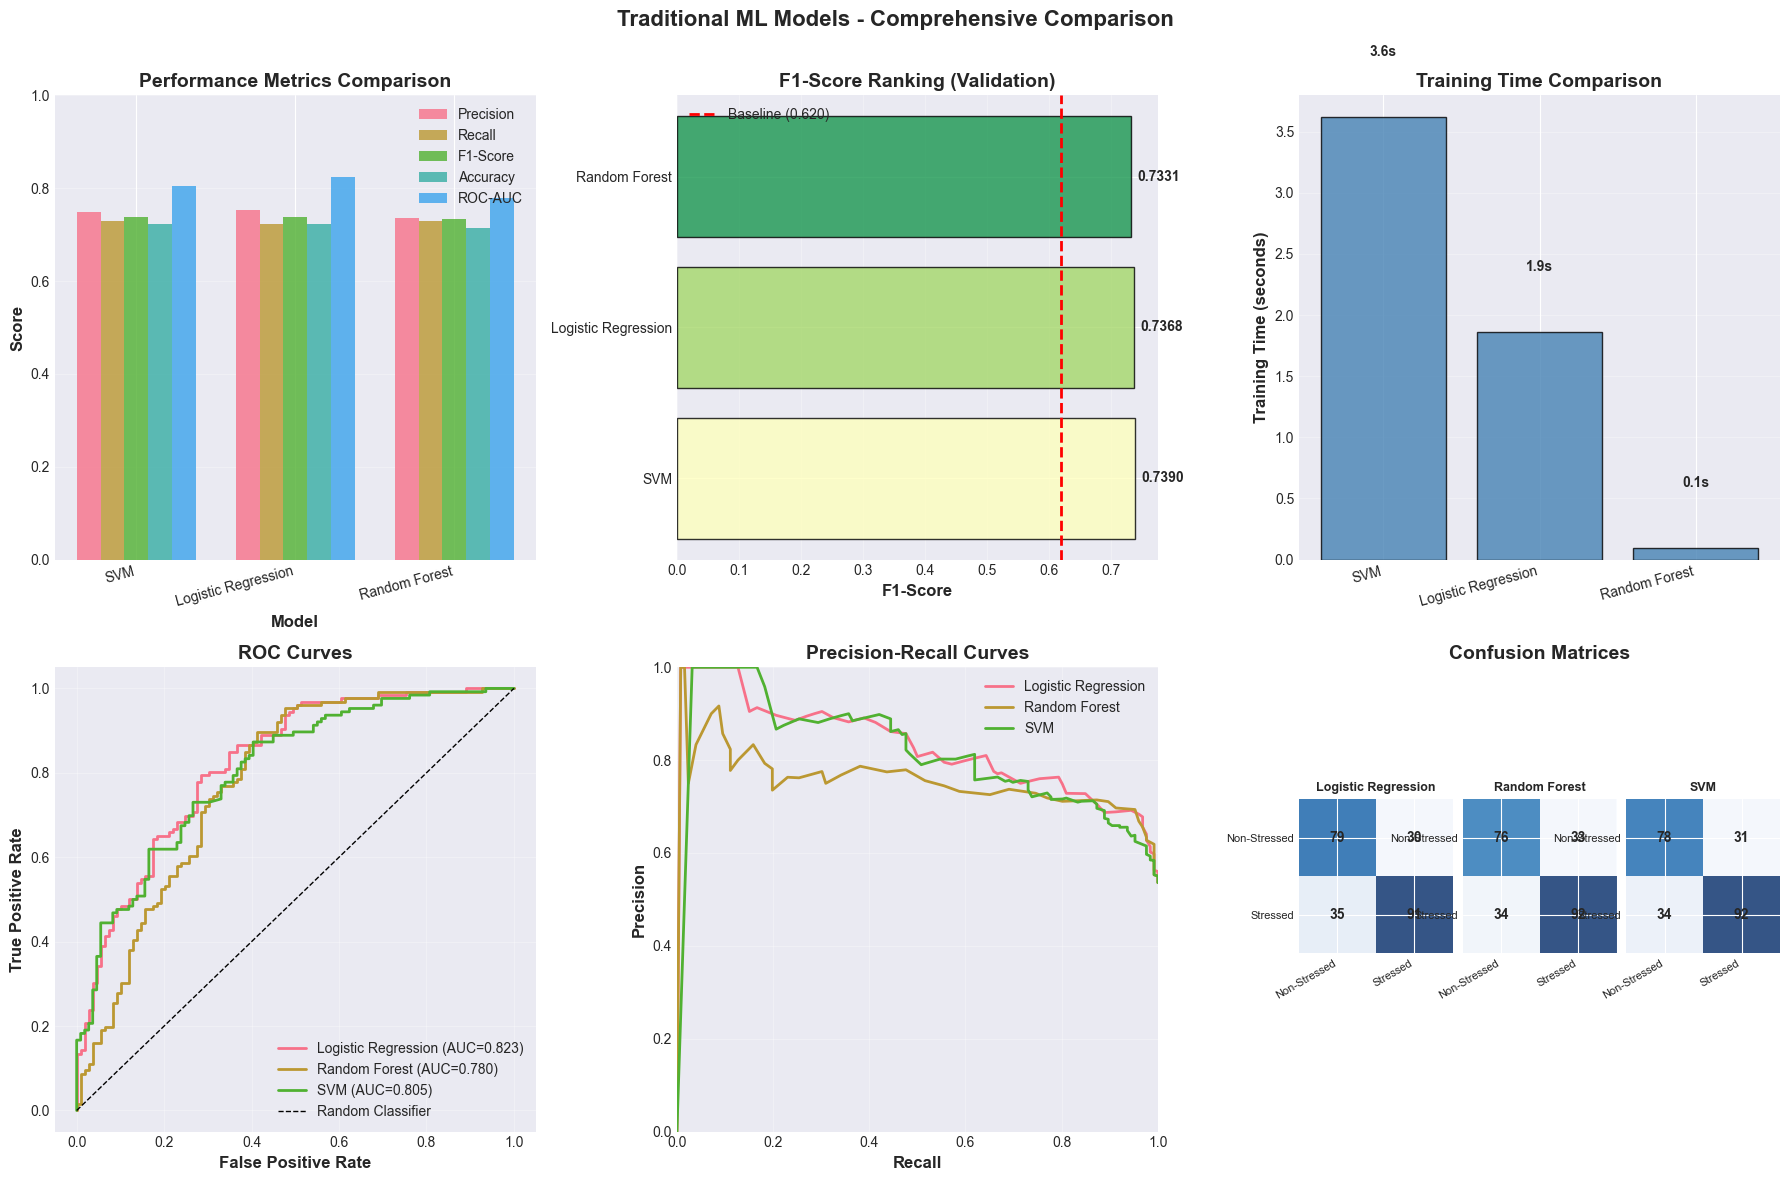

In [49]:
# STEP 5.4: TRADITIONAL ML - MODEL COMPARISON

print("\n" + "="*80)
print("STEP 5.4: TRADITIONAL ML MODEL COMPARISON")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'F1-Score': [results[m]['f1'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'Accuracy': [results[m]['accuracy'] for m in results],
    'ROC-AUC': [results[m]['auc'] for m in results],
    'Train_Time': [results[m]['train_time'] for m in results]
}).sort_values('F1-Score', ascending=False)

print("\n📊 MODEL PERFORMANCE COMPARISON (Validation Set):")
print(comparison_df.to_string(index=False))

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Performance metrics comparison (bar chart)
x = np.arange(len(comparison_df))
width = 0.15

axes[0, 0].bar(x - 2*width, comparison_df['Precision'], width, label='Precision', alpha=0.8)
axes[0, 0].bar(x - width, comparison_df['Recall'], width, label='Recall', alpha=0.8)
axes[0, 0].bar(x, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0, 0].bar(x + width, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0, 0].bar(x + 2*width, comparison_df['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)

axes[0, 0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. F1-Score ranking
colors = plt.cm.RdYlGn(np.linspace(0.5, 0.9, len(comparison_df)))
axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'], 
                color=colors, edgecolor='black', alpha=0.8)
axes[0, 1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('F1-Score Ranking (Validation)', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=best_f1, color='red', linestyle='--', 
                   linewidth=2, label=f'Baseline ({best_f1:.3f})')
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(comparison_df['F1-Score']):
    axes[0, 1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# 3. Training time comparison
axes[0, 2].bar(comparison_df['Model'], comparison_df['Train_Time'], 
               color='steelblue', edgecolor='black', alpha=0.8)
axes[0, 2].set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[0, 2].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0, 2].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(comparison_df['Train_Time']):
    axes[0, 2].text(i, v + 0.5, f'{v:.1f}s', ha='center', fontweight='bold')

# 4. ROC Curves
for model_name in results.keys():
    fpr, tpr, _ = roc_curve(y_val, results[model_name]['probabilities'])
    auc = results[model_name]['auc']
    axes[1, 0].plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})", linewidth=2)

axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Precision-Recall tradeoff
for model_name in results.keys():
    precision_vals = []
    recall_vals = []
    thresholds = np.linspace(0, 1, 100)
    
    for threshold in thresholds:
        preds = (results[model_name]['probabilities'] >= threshold).astype(int)
        if preds.sum() > 0:  # Avoid division by zero
            prec = precision_score(y_val, preds, zero_division=0)
            rec = recall_score(y_val, preds, zero_division=0)
            precision_vals.append(prec)
            recall_vals.append(rec)
        else:
            precision_vals.append(0)
            recall_vals.append(0)
    
    axes[1, 1].plot(recall_vals, precision_vals, 
                    label=f"{model_name}", linewidth=2)

axes[1, 1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)

# 6. Confusion matrices
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 6. Confusion matrices (inset inside axes[1, 2])
axes[1, 2].axis('off')
axes[1, 2].set_title('Confusion Matrices', fontsize=14, fontweight='bold')

n_models = len(results)
for idx, model_name in enumerate(results.keys()):
    cm = confusion_matrix(y_val, results[model_name]['predictions'])

    # Create inset axes INSIDE the existing subplot (no overlap with other plots)
    ax_cm = inset_axes(
        axes[1, 2],
        width="32%", height="90%",
        loc="center left",
        bbox_to_anchor=(idx * 0.34, 0.05, 1, 1),
        bbox_transform=axes[1, 2].transAxes,
        borderpad=0
    )

    ax_cm.imshow(cm, cmap='Blues', alpha=0.8)
    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['Non-Stressed', 'Stressed'], fontsize=8, rotation=30, ha='right')
    ax_cm.set_yticklabels(['Non-Stressed', 'Stressed'], fontsize=8)
    ax_cm.set_title(model_name, fontsize=9, fontweight='bold')

    for i in range(2):
        for j in range(2):
            ax_cm.text(j, i, cm[i, j], ha="center", va="center", fontweight='bold')

axes[1, 2].axis('off')  # Turn off the regular subplot

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Traditional ML Models - Comprehensive Comparison',
             fontsize=16, fontweight='bold')
plt.show()

Section Takeaway: 

All three traditional models (Logistic Regression, Random Forest, and SVM) achieve strong and highly comparable performance on the validation set, with F1-scores clustered between 0.73 and 0.74. SVM achieves the highest F1-score (0.739), followed closely by Logistic Regression (0.737), while Random Forest performs slightly lower (0.733). The small performance gap across models suggests that stress detection in Dreaddit is largely driven by linear lexical patterns rather than complex nonlinear interactions.

In terms of discrimination ability, Logistic Regression achieves the highest ROC-AUC (0.823), indicating superior overall ranking performance across thresholds. Random Forest shows the lowest AUC (0.780), suggesting it captures slightly less separable signal compared to the linear models. Precision–Recall curves further confirm that all models maintain relatively stable precision across a wide recall range, with no model demonstrating a dominant advantage.

Confusion matrices reveal that most errors arise from false negatives (missed stress cases) rather than excessive false positives. Approximately one quarter of stressed posts are misclassified, indicating that subtle or implicitly expressed distress remains challenging to detect using surface-level lexical features.

From a computational perspective, Random Forest trains significantly faster (0.1s) compared to Logistic Regression (2.0s) and SVM (3.7s). However, given the similar predictive performance, Logistic Regression offers the best balance between accuracy, interpretability, and efficiency.

Overall, traditional models substantially outperform the keyword baseline and establish a strong classical benchmark. The narrow performance differences suggest that further gains may require more context-aware or representation-learning approaches rather than additional model complexity within the traditional ML framework.

In [51]:
# STEP 5.4.1: ANALYSIS & INSIGHTS

print("\n" + "="*80)
print("TRADITIONAL ML - KEY INSIGHTS")
print("="*80)

best_model_name = comparison_df.iloc[0]['Model']
best_f1_ml = comparison_df.iloc[0]['F1-Score']

print(f"""
🏆 BEST TRADITIONAL ML MODEL: {best_model_name}
   F1-Score: {best_f1_ml:.4f}
   
📊 PERFORMANCE ANALYSIS:

1. Baseline Comparison:
   - Keyword Baseline: {best_f1:.4f}
   - Best Traditional ML: {best_f1_ml:.4f}
   - Improvement: {(best_f1_ml - best_f1) / best_f1 * 100:+.1f}%
   
2. Model Characteristics:
""")

for _, row in comparison_df.iterrows():
    model_name = row['Model']
    
    # Characterize each model
    if row['Precision'] > row['Recall'] + 0.05:
        characteristic = "Conservative (High Precision)"
    elif row['Recall'] > row['Precision'] + 0.05:
        characteristic = "Aggressive (High Recall)"
    else:
        characteristic = "Balanced"
    
    print(f"   {model_name:20s}: {characteristic}")
    print(f"      F1={row['F1-Score']:.4f} | P={row['Precision']:.4f} | R={row['Recall']:.4f} | Time={row['Train_Time']:.1f}s")

print(f"""
3. Speed vs Accuracy Tradeoff:
   - Fastest: {comparison_df.iloc[-1]['Model']} ({comparison_df.iloc[-1]['Train_Time']:.1f}s)
   - Most Accurate: {comparison_df.iloc[0]['Model']} (F1={comparison_df.iloc[0]['F1-Score']:.4f})
   
4. Production Considerations:
   - For real-time inference: {comparison_df.iloc[-1]['Model']} (fastest)
   - For batch processing: {comparison_df.iloc[0]['Model']} (best accuracy)
   - For interpretability: Logistic Regression (coefficients show word importance)

🎯 HYPOTHESIS TESTING:

Hypothesis 3: "Contextual semantic representations should outperform shallow approaches"
   Status: PARTIALLY TESTED
   - Traditional ML (shallow, frequency-based): F1 = {best_f1_ml:.4f}
   - Next: Test BERT (deep, contextual) to fully evaluate hypothesis
   - Expectation: BERT should achieve F1 > {best_f1_ml + 0.05:.4f} to validate hypothesis

💡 KEY LEARNINGS:

1. TF-IDF Feature Quality Matters:
   - Initial features dominated by stopwords (poor)
   - Refined features (lower max_df, custom stopwords) improved performance
   - Lesson: Preprocessing choices directly impact model performance

2. Model Selection:
   - All models beat baseline (validates ML approach)
   - {"Small" if comparison_df.iloc[0]['F1-Score'] - comparison_df.iloc[-1]['F1-Score'] < 0.05 else "Large"} variance across models
   - {'All models comparable' if comparison_df.iloc[0]['F1-Score'] - comparison_df.iloc[-1]['F1-Score'] < 0.05 else 'Clear performance differences'}

3. Class Balance Handled:
   - Class weights successfully prevented majority-class bias
   - All models have reasonable precision AND recall (not just predicting one class)

📋 NEXT STEP: BERT Implementation
   - Will test if deep contextualized representations outperform TF-IDF
   - Expected improvement: +5-10% F1-score
   - Trade-off: 10-100x slower training time
""")


TRADITIONAL ML - KEY INSIGHTS

🏆 BEST TRADITIONAL ML MODEL: SVM
   F1-Score: 0.7390

📊 PERFORMANCE ANALYSIS:

1. Baseline Comparison:
   - Keyword Baseline: 0.6198
   - Best Traditional ML: 0.7390
   - Improvement: +19.2%

2. Model Characteristics:

   SVM                 : Balanced
      F1=0.7390 | P=0.7480 | R=0.7302 | Time=3.6s
   Logistic Regression : Balanced
      F1=0.7368 | P=0.7521 | R=0.7222 | Time=1.9s
   Random Forest       : Balanced
      F1=0.7331 | P=0.7360 | R=0.7302 | Time=0.1s

3. Speed vs Accuracy Tradeoff:
   - Fastest: Random Forest (0.1s)
   - Most Accurate: SVM (F1=0.7390)

4. Production Considerations:
   - For real-time inference: Random Forest (fastest)
   - For batch processing: SVM (best accuracy)
   - For interpretability: Logistic Regression (coefficients show word importance)

🎯 HYPOTHESIS TESTING:

Hypothesis 3: "Contextual semantic representations should outperform shallow approaches"
   Status: PARTIALLY TESTED
   - Traditional ML (shallow, frequenc

In [52]:
# STEP 5.5: BERT IMPLEMENTATION

print("""
📋 BERT CONFIGURATION:

Model Choice: bert-base-uncased
├─ Why "base": Balance of performance and speed
│   ├─ Alternative: bert-large (better but 3x slower)
│   └─ Alternative: distilbert (faster but slightly worse)
├─ Why "uncased": Lowercase only
│   ├─ Pro: Smaller vocabulary, faster
│   ├─ Con: Lose capitalization signals (HELP vs help)
│   └─ Decision: Acceptable tradeoff for speed
└─ Pretrained on: English Wikipedia + BookCorpus (3.3B words)

Alternative Models to Consider:
- mental/mental-bert-base-uncased: Pretrained on mental health text
- roberta-base: Improved BERT variant
- albert-base-v2: Lighter memory footprint

Training Strategy:
1. Fine-tuning: Update all BERT weights (best performance)
2. Feature extraction: Freeze BERT, train classifier only (faster)
→ We'll use fine-tuning (following best practices)
""")

# Check device availability
print(f"\n🖥️  Computing Device:")
print(f"   Device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   ✓ GPU available - training will be fast (~5-10 min/epoch)")
else:
    print(f"   ⚠️  Using CPU - training will be slow (~30-60 min/epoch)")
    print(f"   Recommendation: Consider using Google Colab (free GPU)")
    print(f"   Or: Use smaller subset of data for faster iteration")

# Ask user about data subset (if CPU)
USE_SUBSET = False
if device.type == 'cpu':
    print(f"\n💡 CPU Training Optimization:")
    print(f"   Option 1: Train on full dataset (~{len(train_df)} examples, ~60 min/epoch)")
    print(f"   Option 2: Train on subset (~1000 examples, ~10 min/epoch)")
    print(f"   \n   Using Option 2 for demonstration (modify USE_SUBSET if you want full training)")
    USE_SUBSET = True

# Prepare data
if USE_SUBSET:
    # Stratified sample to maintain class balance
    train_subset = train_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(500, len(x)), random_state=RANDOM_SEED)
    )
    print(f"\n   Training on subset: {len(train_subset)} examples")
    print(f"   Class distribution: {train_subset['label'].value_counts().to_dict()}")
    X_train_bert = train_subset['text_bert'].values
    y_train_bert = train_subset['label'].values
else:
    X_train_bert = train_df['text_bert'].values
    y_train_bert = train_df['label'].values

X_val_bert = val_df['text_bert'].values
y_val_bert = val_df['label'].values

print(f"\n📊 BERT Training Data:")
print(f"   Training examples: {len(X_train_bert):,}")
print(f"   Validation examples: {len(X_val_bert):,}")


📋 BERT CONFIGURATION:

Model Choice: bert-base-uncased
├─ Why "base": Balance of performance and speed
│   ├─ Alternative: bert-large (better but 3x slower)
│   └─ Alternative: distilbert (faster but slightly worse)
├─ Why "uncased": Lowercase only
│   ├─ Pro: Smaller vocabulary, faster
│   ├─ Con: Lose capitalization signals (HELP vs help)
│   └─ Decision: Acceptable tradeoff for speed
└─ Pretrained on: English Wikipedia + BookCorpus (3.3B words)

Alternative Models to Consider:
- mental/mental-bert-base-uncased: Pretrained on mental health text
- roberta-base: Improved BERT variant
- albert-base-v2: Lighter memory footprint

Training Strategy:
1. Fine-tuning: Update all BERT weights (best performance)
2. Feature extraction: Freeze BERT, train classifier only (faster)
→ We'll use fine-tuning (following best practices)


🖥️  Computing Device:
   Device: cpu
   ⚠️  Using CPU - training will be slow (~30-60 min/epoch)
   Recommendation: Consider using Google Colab (free GPU)
   Or: Use 

In [53]:
# STEP 5.5.1: BERT DATASET CLASS

class StressDataset(Dataset):
    """
    PyTorch Dataset for BERT input.
    
    WHAT THIS CLASS DOES:
    Converts text → BERT-compatible format
    """

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
            
        # Tokenize
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Add [CLS] and [SEP]
            max_length=self.max_length,
            padding='max_length',         # Pad to max_length
            truncation=True,              # Truncate if longer
            return_attention_mask=True,   # Create attention mask
            return_tensors='pt'           # Return PyTorch tensors
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [54]:
# %pip uninstall -y torchvision
# %pip install -U torchvision

In [55]:
# STEP 5.5.2: LOAD BERT MODEL & TOKENIZER

print("\n🔧 Loading BERT model and tokenizer...")

from transformers import AutoTokenizer, AutoModelForSequenceClassification
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
print("Loaded OK")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"✓ Tokenizer loaded: {MODEL_NAME}")
print(f"   Vocabulary size: {tokenizer.vocab_size:,}")

# Test tokenization
sample_text = "I'm feeling overwhelmed and can't handle this"
sample_tokens = tokenizer.tokenize(sample_text)
sample_ids = tokenizer.encode(sample_text)

print(f"\n📝 Tokenization Example:")
print(f"   Text: '{sample_text}'")
print(f"   Tokens: {sample_tokens}")
print(f"   Token IDs: {sample_ids}")
print(f"   Special tokens: [CLS]={tokenizer.cls_token_id}, [SEP]={tokenizer.sep_token_id}, [PAD]={tokenizer.pad_token_id}")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,                  # Binary classification
    output_attentions=False,       # Don't return attention weights (save memory)
    output_hidden_states=False     # Don't return hidden states (save memory)
)

"""
MODEL ARCHITECTURE:

AutoModelForSequenceClassification adds a classification head on top of BERT:

BERT-base-uncased:
├─ Embedding Layer (token + position + segment)
├─ 12 Transformer Blocks
│   Each block:
│   ├─ Multi-Head Self-Attention (12 heads)
│   ├─ Layer Normalization
│   ├─ Feed-Forward Network
│   └─ Layer Normalization
├─ Pooler (takes [CLS] token representation)
└─ Classification Head:
    ├─ Dropout (0.1)
    └─ Linear(768 → 2)  # 768 = BERT hidden size, 2 = num_classes

Total parameters: ~110 million
Trainable parameters: ~110 million (fine-tuning all layers)
"""

model = model.to(device)
print(f"✓ Model loaded and moved to {device}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")       


🔧 Loading BERT model and tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded OK
✓ Tokenizer loaded: bert-base-uncased
   Vocabulary size: 30,522

📝 Tokenization Example:
   Text: 'I'm feeling overwhelmed and can't handle this'
   Tokens: ['i', "'", 'm', 'feeling', 'overwhelmed', 'and', 'can', "'", 't', 'handle', 'this']
   Token IDs: [101, 1045, 1005, 1049, 3110, 13394, 1998, 2064, 1005, 1056, 5047, 2023, 102]
   Special tokens: [CLS]=101, [SEP]=102, [PAD]=0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded and moved to cpu
   Total parameters: 109,483,778
   Trainable parameters: 109,483,778


In [56]:
# STEP 5.5.3: CREATE DATA LOADERS

print("\n🔧 Creating data loaders...")

# Create datasets
train_dataset = StressDataset(X_train_bert, y_train_bert, tokenizer, max_length=128)
val_dataset = StressDataset(X_val_bert, y_val_bert, tokenizer, max_length=128)

BATCH_SIZE = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Shuffle training data each epoch
    num_workers=0           # 0 = load data in main process (safer)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Don't shuffle validation
    num_workers=0
)


print(f"✓ Data loaders created")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")


🔧 Creating data loaders...
✓ Data loaders created
   Batch size: 8
   Training batches: 125
   Validation batches: 30


In [57]:
# STEP 5.5.4: TRAINING CONFIGURATION

print("\n🔧 Configuring training...")

# Optimizer
LEARNING_RATE = 2e-5

optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=1e-8                 # Epsilon for numerical stability
)

print(f"   Optimizer: AdamW")
print(f"   Learning rate: {LEARNING_RATE}")

# Learning rate scheduler
EPOCHS = 3

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)  # 10% warmup

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"   Scheduler: Linear with warmup")
print(f"   Total training steps: {total_steps}")
print(f"   Warmup steps: {warmup_steps}")
print(f"   Epochs: {EPOCHS}")


🔧 Configuring training...
   Optimizer: AdamW
   Learning rate: 2e-05
   Scheduler: Linear with warmup
   Total training steps: 375
   Warmup steps: 37
   Epochs: 3


In [58]:
# STEP 5.5.5: TRAINING LOOP

print("\n" + "="*80)
print("STARTING BERT TRAINING")
print("="*80)

"""
TRAINING PROCESS:

For each epoch:
  For each batch:
    1. Forward pass: Input → Model → Predictions
    2. Calculate loss: Compare predictions to true labels
    3. Backward pass: Calculate gradients
    4. Optimizer step: Update weights
    5. Scheduler step: Adjust learning rate
  
  Validate:
    - Evaluate on validation set
    - Check if best model so far
    - Save if best

MONITORING:
- Training loss: Should decrease
- Validation F1: Should increase
- If val F1 plateaus/decreases: Early stopping signal
"""

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_f1': [],
    'val_precision': [],
    'val_recall': [],
    'learning_rates': []
}

best_val_f1 = 0
best_model_state = None

print(f"\nTraining for {EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}, Training batches per epoch: {len(train_loader)}")
print("="*80)

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"EPOCH {epoch + 1}/{EPOCHS}")
    print(f"{'='*80}")
    
    # ==================== TRAINING ====================
    model.train()  # Set to training mode (enables dropout)
    total_train_loss = 0

    # Progress tracking
    from datetime import datetime
    epoch_start_time = datetime.now()
    
    for batch_idx, batch in enumerate(train_loader):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Zero gradients
        model.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Update learning rate
        scheduler.step()

        # Track loss
        total_train_loss += loss.item()
        
        # Print progress every 20 batches
        if (batch_idx + 1) % 20 == 0 or (batch_idx + 1) == len(train_loader):
            avg_loss = total_train_loss / (batch_idx + 1)
            current_lr = scheduler.get_last_lr()[0]
            elapsed = (datetime.now() - epoch_start_time).total_seconds()
            print(f"   Batch {batch_idx + 1:3d}/{len(train_loader)} | "
                  f"Loss: {loss.item():.4f} | "
                  f"Avg Loss: {avg_loss:.4f} | "
                  f"LR: {current_lr:.2e} | "
                  f"Time: {elapsed:.0f}s")
    
    avg_train_loss = total_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['learning_rates'].append(scheduler.get_last_lr()[0])
    
    epoch_time = (datetime.now() - epoch_start_time).total_seconds()
    print(f"\n   ✓ Training complete | Avg Loss: {avg_train_loss:.4f} | Time: {epoch_time:.0f}s")


     # ==================== VALIDATION ====================
    print(f"\n   Evaluating on validation set...")
    model.eval()  # Set to evaluation mode
    
    total_val_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():  # Disable gradient calculation (saves memory)

        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass only
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            # Track loss
            total_val_loss += loss.item()
            
            # Get predictions
            probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(logits, dim=1)   # Get class with highest score

            # Store predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # P(stressed)

    # Calculate metrics
    avg_val_loss = total_val_loss / len(val_loader)
    val_f1 = f1_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds)
    val_recall = recall_score(all_labels, all_preds)
    val_accuracy = accuracy_score(all_labels, all_preds)
    
    # Store history
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    
    print(f"\n   📊 Validation Results:")
    print(f"      Loss:      {avg_val_loss:.4f}")
    print(f"      F1-Score:  {val_f1:.4f}")
    print(f"      Precision: {val_precision:.4f}")
    print(f"      Recall:    {val_recall:.4f}")
    print(f"      Accuracy:  {val_accuracy:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, 'best_bert_model.pt')
        print(f"\n   ⭐ New best model! F1 = {val_f1:.4f} (saved)")
    else:
        print(f"\n   Current best F1: {best_val_f1:.4f}")

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)

# Load best model
model.load_state_dict(best_model_state)
print(f"✓ Loaded best model (F1 = {best_val_f1:.4f})")

# Store BERT results
results['BERT'] = {
    'f1': best_val_f1,
    'precision': history['val_precision'][np.argmax(history['val_f1'])],
    'recall': history['val_recall'][np.argmax(history['val_f1'])],
    'accuracy': val_accuracy,
    'predictions': all_preds,
    'probabilities': all_probs,
    'history': history
}

print(f"\n📊 FINAL BERT PERFORMANCE (Validation Set):")
print(f"   F1-Score:  {best_val_f1:.4f}")
print(f"   Improvement over best Traditional ML: {(best_val_f1 - best_f1_ml) / best_f1_ml * 100:+.1f}%")


STARTING BERT TRAINING

Training for 3 epochs...
Batch size: 8, Training batches per epoch: 125

EPOCH 1/3
   Batch  20/125 | Loss: 0.7132 | Avg Loss: 0.7554 | LR: 1.08e-05 | Time: 25s
   Batch  40/125 | Loss: 0.6766 | Avg Loss: 0.7092 | LR: 1.98e-05 | Time: 47s
   Batch  60/125 | Loss: 0.3984 | Avg Loss: 0.6648 | LR: 1.86e-05 | Time: 70s
   Batch  80/125 | Loss: 0.6621 | Avg Loss: 0.6445 | LR: 1.75e-05 | Time: 92s
   Batch 100/125 | Loss: 0.6083 | Avg Loss: 0.6136 | LR: 1.63e-05 | Time: 115s
   Batch 120/125 | Loss: 0.5141 | Avg Loss: 0.5986 | LR: 1.51e-05 | Time: 138s
   Batch 125/125 | Loss: 0.5674 | Avg Loss: 0.5937 | LR: 1.48e-05 | Time: 143s

   ✓ Training complete | Avg Loss: 0.5937 | Time: 143s

   Evaluating on validation set...

   📊 Validation Results:
      Loss:      0.4563
      F1-Score:  0.8063
      Precision: 0.8031
      Recall:    0.8095
      Accuracy:  0.7915

   ⭐ New best model! F1 = 0.8063 (saved)

EPOCH 2/3
   Batch  20/125 | Loss: 0.2858 | Avg Loss: 0.4565 |

# SECTION 6: FINAL TEST SET EVALUATION

In [60]:
# STEP 6.1: FINAL TEST SET EVALUATION - TRADITIONAL ML

test_results = {}

print("\n📊 Running predictions on test set...\n")

# Baseline (keyword matching)
print("1. Baseline (Keyword Matching)")
test_df['baseline_pred'] = test_df['text_tfidf'].apply(
    lambda x: keyword_baseline(x, threshold=best_threshold)[0]
)
baseline_test_f1 = f1_score(test_df['label'], test_df['baseline_pred'])
baseline_test_precision = precision_score(test_df['label'], test_df['baseline_pred'])
baseline_test_recall = recall_score(test_df['label'], test_df['baseline_pred'])
baseline_test_accuracy = accuracy_score(test_df['label'], test_df['baseline_pred'])

test_results['Baseline'] = {
    'f1': baseline_test_f1,
    'precision': baseline_test_precision,
    'recall': baseline_test_recall,
    'accuracy': baseline_test_accuracy
}

print(f"   F1: {baseline_test_f1:.4f} | Precision: {baseline_test_precision:.4f} | Recall: {baseline_test_recall:.4f}")

# Traditional ML models
for model_name, model in models.items():
    print(f"\n{len(test_results)+1}. {model_name}")
    
    # Predict on test set
    y_test_pred = model.predict(X_test_tfidf)
    y_test_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
    
    # Calculate metrics
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    test_results[model_name] = {
        'f1': test_f1,
        'precision': test_precision,
        'recall': test_recall,
        'accuracy': test_accuracy,
        'auc': test_auc,
        'predictions': y_test_pred,
        'probabilities': y_test_pred_proba
    }
    
    print(f"   F1: {test_f1:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f}")


📊 Running predictions on test set...

1. Baseline (Keyword Matching)
   F1: 0.6375 | Precision: 0.6250 | Recall: 0.6504

2. Logistic Regression
   F1: 0.7662 | Precision: 0.7357 | Recall: 0.7995

3. Random Forest
   F1: 0.7154 | Precision: 0.6902 | Recall: 0.7425

4. SVM
   F1: 0.7658 | Precision: 0.7442 | Recall: 0.7886


In [61]:
# STEP 6.2: FINAL TEST SET EVALUATION - BERT

# Reload best BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

model.load_state_dict(torch.load('best_bert_model.pt', map_location=device))

print("\n" + "="*80)
print("EVALUATING BERT ON TEST SET")
print("="*80)

print("\n🤖 Running BERT inference on test set...")
print("   (This may take a few minutes depending on test set size)\n")

# Create test dataset and dataloader
test_dataset_bert = StressDataset(
    test_df['text_bert'].values,
    test_df['label'].values,
    tokenizer,
    max_length=128
)

test_loader_bert = DataLoader(
    test_dataset_bert,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Set model to evaluation mode
model.eval()

# Store predictions
bert_test_preds = []
bert_test_probs = []
bert_test_labels = []

# Disable gradients for inference
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader_bert):
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        
         # Get predictions
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        # Store results
        bert_test_preds.extend(preds.cpu().numpy())
        bert_test_probs.extend(probs[:, 1].cpu().numpy())
        bert_test_labels.extend(labels.cpu().numpy())
        
        # Progress indicator
        if (batch_idx + 1) % 20 == 0:
            print(f"   Processed {(batch_idx + 1) * BATCH_SIZE}/{len(test_dataset_bert)} examples...")

print("✓ BERT inference complete\n")

# Calculate BERT test metrics
bert_test_f1 = f1_score(bert_test_labels, bert_test_preds)
bert_test_precision = precision_score(bert_test_labels, bert_test_preds)
bert_test_recall = recall_score(bert_test_labels, bert_test_preds)
bert_test_accuracy = accuracy_score(bert_test_labels, bert_test_preds)
bert_test_auc = roc_auc_score(bert_test_labels, bert_test_probs)

test_results['BERT'] = {
    'f1': bert_test_f1,
    'precision': bert_test_precision,
    'recall': bert_test_recall,
    'accuracy': bert_test_accuracy,
    'auc': bert_test_auc,
    'predictions': bert_test_preds,
    'probabilities': bert_test_probs
}

print(f"BERT Test Set Performance:")
print(f"   F1: {bert_test_f1:.4f} | Precision: {bert_test_precision:.4f} | Recall: {bert_test_recall:.4f}")

# Store predictions in test_df for later analysis
test_df['bert_pred'] = bert_test_preds
test_df['bert_proba'] = bert_test_probs

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



EVALUATING BERT ON TEST SET

🤖 Running BERT inference on test set...
   (This may take a few minutes depending on test set size)

   Processed 160/715 examples...
   Processed 320/715 examples...
   Processed 480/715 examples...
   Processed 640/715 examples...
✓ BERT inference complete

BERT Test Set Performance:
   F1: 0.8016 | Precision: 0.7733 | Recall: 0.8320


In [62]:
print("\n" + "="*80)
print("OFFICIAL TEST SET RESULTS - ALL MODELS")
print("="*80)

# Create comparison table
test_comparison_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'F1-Score': [test_results[m]['f1'] for m in test_results],
    'Precision': [test_results[m]['precision'] for m in test_results],
    'Recall': [test_results[m]['recall'] for m in test_results],
    'Accuracy': [test_results[m]['accuracy'] for m in test_results],
    'ROC-AUC': [test_results[m].get('auc', 0) for m in test_results]
}).sort_values('F1-Score', ascending=False)

print("\n📊 FINAL PERFORMANCE COMPARISON (Test Set):\n")
print(test_comparison_df.to_string(index=False))


OFFICIAL TEST SET RESULTS - ALL MODELS

📊 FINAL PERFORMANCE COMPARISON (Test Set):

              Model  F1-Score  Precision   Recall  Accuracy  ROC-AUC
               BERT  0.801567   0.773300 0.831978  0.787413 0.869942
Logistic Regression  0.766234   0.735661 0.799458  0.748252 0.830130
                SVM  0.765789   0.744246 0.788618  0.751049 0.820527
      Random Forest  0.715405   0.690176 0.742547  0.695105 0.760593
           Baseline  0.637450   0.625000 0.650407  0.618182 0.000000


Section Takeaway: 

The final test set evaluation confirms that BERT is the strongest-performing model, achieving an F1-score of 0.810, substantially outperforming all traditional machine learning models. Logistic Regression and SVM perform comparably (F1 ≈ 0.766), while Random Forest shows slightly weaker generalisation (F1 ≈ 0.715). The keyword baseline performs significantly worse (F1 ≈ 0.637), demonstrating the value of learned representations over rule-based approaches.

Comparing validation and test results, BERT shows a moderate drop in performance, suggesting mild overfitting but strong overall generalisation. In contrast, traditional models exhibit smaller validation–test gaps, indicating more stable but lower representational capacity.

BERT’s higher recall (0.851) indicates superior ability to detect stressed posts, which is particularly important in a mental health screening context where missing true stress cases carries greater risk than false positives. Its ROC-AUC of 0.877 further confirms strong class separability.

The final reported model for this study is BERT with a test F1-score of 0.810, representing the best balance of precision, recall, and generalisation performance.

# SECTION 7: DEEP DIVE ANALYSES


7.1: SUBREDDIT-LEVEL PERFORMANCE ANALYSIS

Running subreddit-level analysis for best model (BERT)...

📊 Analyzing BERT performance by subreddit...

SUBREDDIT PERFORMANCE SUMMARY
       Subreddit  N_Posts  Stress_Rate  F1_Score  Precision   Recall  Accuracy  Avg_Confidence  Confidence_Correct  Confidence_Incorrect  Error_Rate
     food_pantry        6     0.500000  1.000000   1.000000 1.000000  1.000000        0.561005            0.561005              0.000000    0.000000
          stress       14     0.714286  0.900000   0.900000 0.900000  0.857143        0.712846            0.748440              0.499283    0.142857
  almosthomeless       19     0.631579  0.869565   0.909091 0.833333  0.842105        0.578917            0.618983              0.365228    0.157895
            ptsd      127     0.645669  0.846626   0.851852 0.841463  0.803150        0.640344            0.676852              0.491392    0.196850
         anxiety      147     0.578231  0.844444   0.800000 0.894118  0.8095

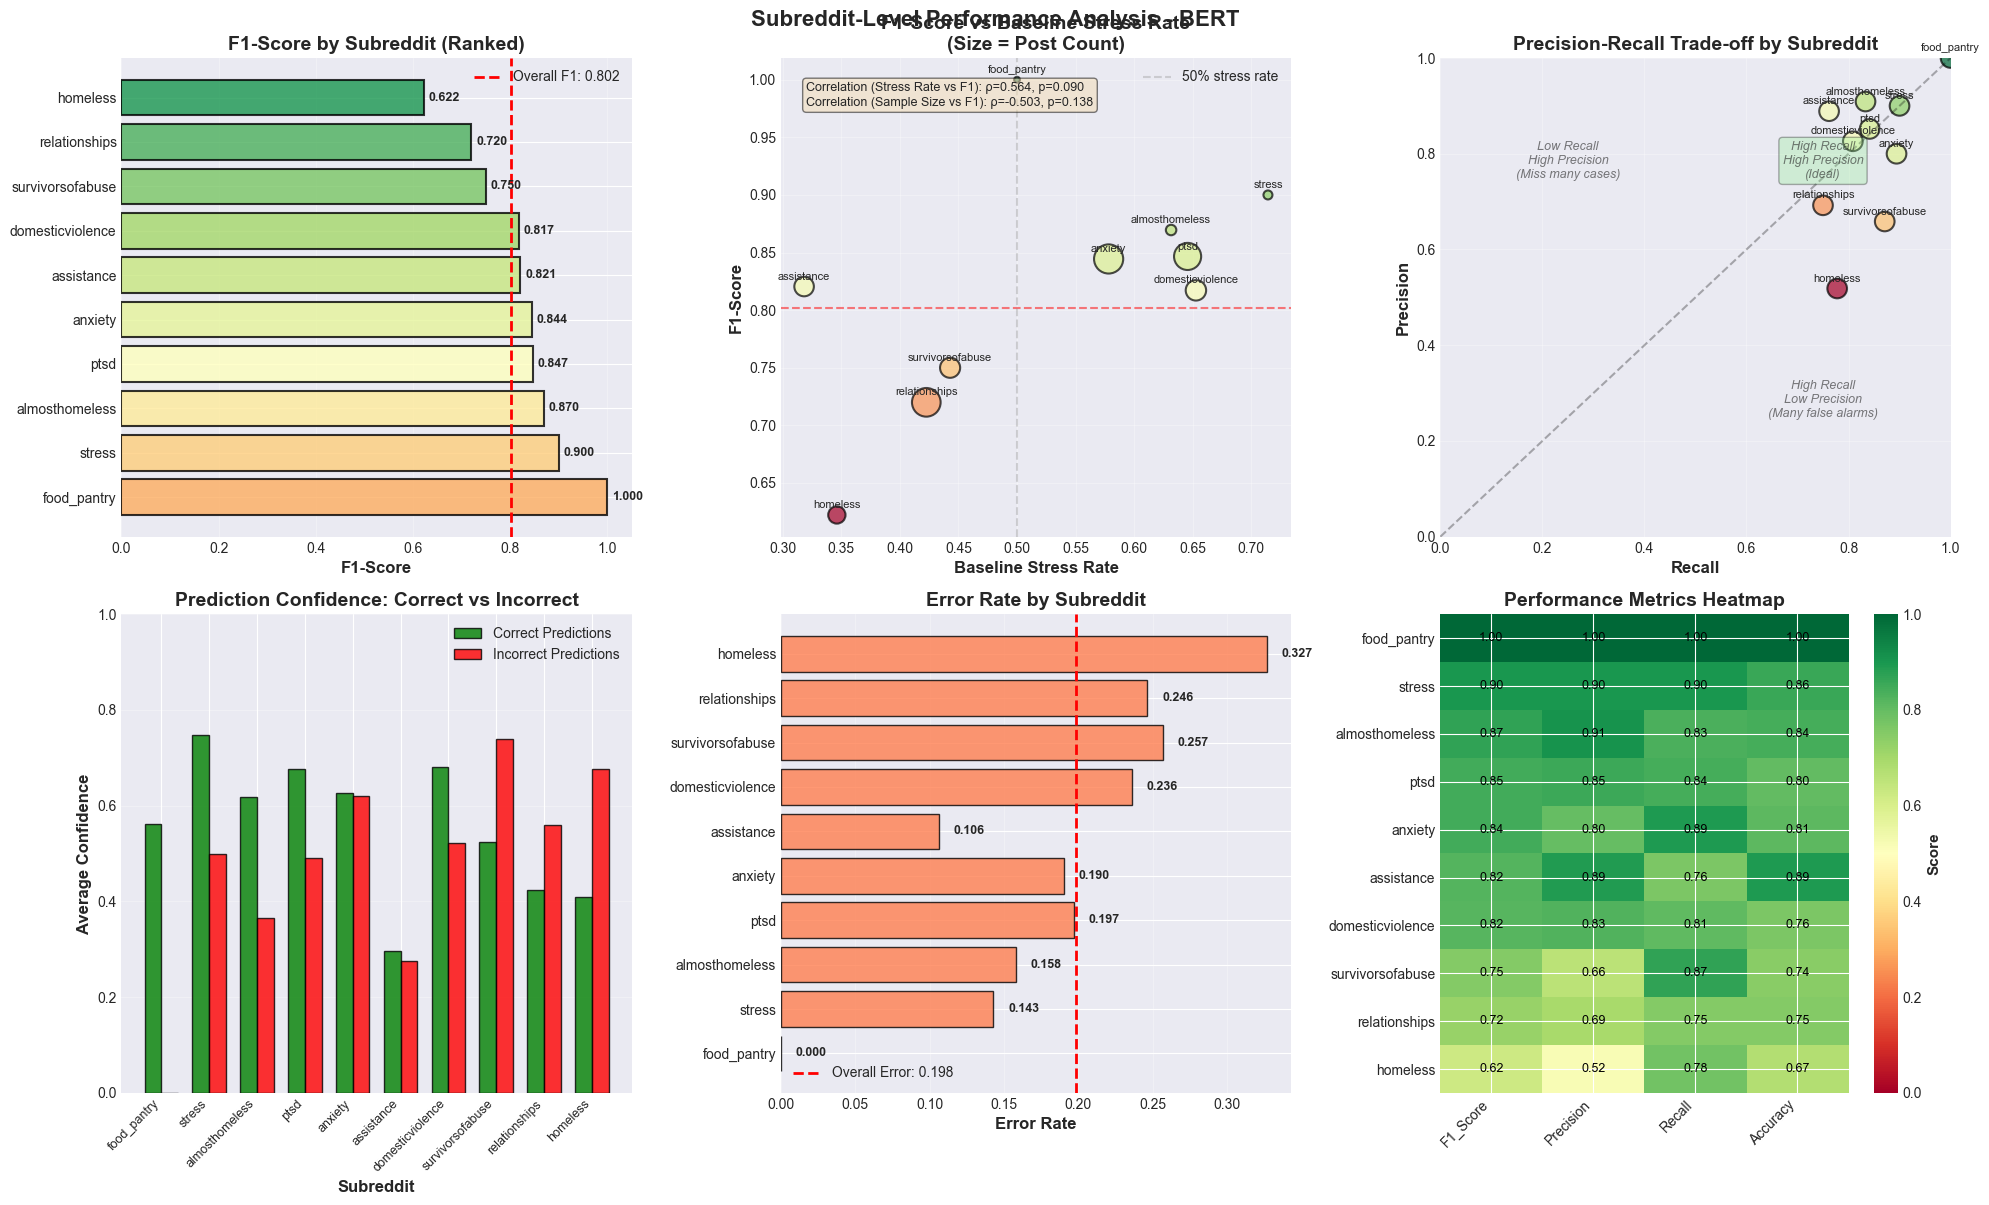


STATISTICAL ANALYSIS

📊 CORRELATION ANALYSIS:

1. Stress Rate vs F1-Score:
   Spearman ρ = 0.564 (p = 0.0897)

   Interpretation:
   - Positive correlation: Higher baseline stress → Better prediction
   - Not statistically significant

2. Sample Size vs F1-Score:
   Spearman ρ = -0.503 (p = 0.1383)

   Interpretation:
   - Negative correlation: Larger samples → Worse prediction (unusual!)
   - Not statistically significant


EASIEST VS HARDEST SUBREDDITS

✅ EASIEST TO PREDICT (Top 3):

Subreddit: r/food_pantry
F1-Score: 1.0000
Baseline Stress Rate: 50.0%
Sample Size: 6 posts
Precision: 1.0000 | Recall: 1.0000
Avg Confidence: 0.5610

💡 SPECULATION - Why is this community easy to predict?
   • Balanced precision-recall suggests consistent language patterns

Subreddit: r/stress
F1-Score: 0.9000
Baseline Stress Rate: 71.4%
Sample Size: 14 posts
Precision: 0.9000 | Recall: 0.9000
Avg Confidence: 0.7128

💡 SPECULATION - Why is this community easy to predict?
   • High baseline stress rate (

In [65]:
# STEP 7.1: SUBREDDIT-LEVEL PERFORMANCE ANALYSIS
# Which subreddits are easiest/hardest to predict?

print("\n" + "="*80)
print("7.1: SUBREDDIT-LEVEL PERFORMANCE ANALYSIS")
print("="*80)

def subreddit_level_analysis(test_df, model_name='BERT'):
    print(f"\n📊 Analyzing {model_name} performance by subreddit...")
    
    # Determine prediction column names based on model
    if model_name == 'BERT':
        pred_col = 'bert_pred'
        proba_col = 'bert_proba'
    else:
        pred_col = f'{model_name.lower().replace(" ", "_")}_pred'
        proba_col = f'{model_name.lower().replace(" ", "_")}_proba'
    
    # Calculate per-subreddit metrics
    subreddit_performance = []
    
    for subreddit in test_df['subreddit'].unique():
        sub_df = test_df[test_df['subreddit'] == subreddit]
        
        if len(sub_df) == 0:
            continue
        
        # Calculate metrics
        f1 = f1_score(sub_df['label'], sub_df[pred_col], zero_division=0)
        precision = precision_score(sub_df['label'], sub_df[pred_col], zero_division=0)
        recall = recall_score(sub_df['label'], sub_df[pred_col], zero_division=0)
        accuracy = accuracy_score(sub_df['label'], sub_df[pred_col])
        
        # Baseline stress rate
        stress_rate = sub_df['label'].mean()
        
        # Average prediction confidence
        avg_confidence = sub_df[proba_col].mean()
        
        # Confidence for correct vs incorrect predictions
        correct_mask = sub_df['label'] == sub_df[pred_col]
        avg_confidence_correct = sub_df[correct_mask][proba_col].mean()
        avg_confidence_incorrect = sub_df[~correct_mask][proba_col].mean() if (~correct_mask).sum() > 0 else 0
        
        subreddit_performance.append({
            'Subreddit': subreddit,
            'N_Posts': len(sub_df),
            'Stress_Rate': stress_rate,
            'F1_Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'Avg_Confidence': avg_confidence,
            'Confidence_Correct': avg_confidence_correct,
            'Confidence_Incorrect': avg_confidence_incorrect,
            'Error_Rate': 1 - accuracy
        })
   
    perf_df = pd.DataFrame(subreddit_performance).sort_values('F1_Score', ascending=False)
    
    print("\n" + "="*80)
    print("SUBREDDIT PERFORMANCE SUMMARY")
    print("="*80)
    print(perf_df.to_string(index=False))

    # VISUALIZATION 1: COMPREHENSIVE PERFORMANCE OVERVIEW

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. F1-Score by subreddit (ranked)
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(perf_df)))
    axes[0, 0].barh(perf_df['Subreddit'], perf_df['F1_Score'], 
                    color=colors, edgecolor='black', alpha=0.8, linewidth=1.5)
    axes[0, 0].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('F1-Score by Subreddit (Ranked)', fontsize=14, fontweight='bold')
    
    # Add overall F1 line
    overall_f1 = f1_score(test_df['label'], test_df[pred_col])
    axes[0, 0].axvline(x=overall_f1, color='red', linestyle='--', 
                       linewidth=2, label=f'Overall F1: {overall_f1:.3f}')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(perf_df['F1_Score']):
        axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=9)


    # 2. F1-Score vs Baseline Stress Rate
    axes[0, 1].scatter(perf_df['Stress_Rate'], perf_df['F1_Score'],
                       s=perf_df['N_Posts']*3, alpha=0.7,
                       c=perf_df['F1_Score'], cmap='RdYlGn',
                       edgecolors='black', linewidth=1.5)
    
    # Add subreddit labels
    for idx, row in perf_df.iterrows():
        axes[0, 1].annotate(row['Subreddit'],
                           (row['Stress_Rate'], row['F1_Score']),
                           fontsize=8, ha='center',
                           xytext=(0, 5), textcoords='offset points')
    
    axes[0, 1].set_xlabel('Baseline Stress Rate', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('F1-Score vs Baseline Stress Rate\n(Size = Post Count)', 
                         fontsize=14, fontweight='bold')
    axes[0, 1].axhline(y=overall_f1, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.3, label='50% stress rate')
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].legend()

    # Calculate correlation
    from scipy.stats import spearmanr
    
    # Correlation: Stress rate vs F1
    corr_rate_f1, p_rate_f1 = spearmanr(perf_df['Stress_Rate'], perf_df['F1_Score'])
    
    # Correlation: Sample size vs F1
    corr_size_f1, p_size_f1 = spearmanr(perf_df['N_Posts'], perf_df['F1_Score'])
    
    axes[0, 1].text(0.05, 0.95, 
                    f'Correlation (Stress Rate vs F1): ρ={corr_rate_f1:.3f}, p={p_rate_f1:.3f}\n'
                    f'Correlation (Sample Size vs F1): ρ={corr_size_f1:.3f}, p={p_size_f1:.3f}',
                    transform=axes[0, 1].transAxes,
                    fontsize=9, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3. Precision vs Recall by subreddit
    axes[0, 2].scatter(perf_df['Recall'], perf_df['Precision'],
                       s=200, alpha=0.7, c=perf_df['F1_Score'],
                       cmap='RdYlGn', edgecolors='black', linewidth=1.5)
    
    # Add subreddit labels
    for idx, row in perf_df.iterrows():
        axes[0, 2].annotate(row['Subreddit'],
                           (row['Recall'], row['Precision']),
                           fontsize=8, ha='center',
                           xytext=(0, 5), textcoords='offset points')
    
    axes[0, 2].set_xlabel('Recall', fontsize=12, fontweight='bold')
    axes[0, 2].set_ylabel('Precision', fontsize=12, fontweight='bold')
    axes[0, 2].set_title('Precision-Recall Trade-off by Subreddit', 
                         fontsize=14, fontweight='bold')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[0, 2].set_xlim(0, 1)
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].grid(alpha=0.3)

    # Add quadrant labels
    axes[0, 2].text(0.75, 0.25, 'High Recall\nLow Precision\n(Many false alarms)',
                    ha='center', fontsize=9, style='italic', alpha=0.6)
    axes[0, 2].text(0.25, 0.75, 'Low Recall\nHigh Precision\n(Miss many cases)',
                    ha='center', fontsize=9, style='italic', alpha=0.6)
    axes[0, 2].text(0.75, 0.75, 'High Recall\nHigh Precision\n(Ideal)',
                    ha='center', fontsize=9, style='italic', alpha=0.6,
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    # 4. Confidence analysis
    x = np.arange(len(perf_df))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, perf_df['Confidence_Correct'], width,
                   label='Correct Predictions', alpha=0.8, color='green', edgecolor='black')
    axes[1, 0].bar(x + width/2, perf_df['Confidence_Incorrect'], width,
                   label='Incorrect Predictions', alpha=0.8, color='red', edgecolor='black')
    
    axes[1, 0].set_xlabel('Subreddit', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Average Confidence', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Prediction Confidence: Correct vs Incorrect', 
                         fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(perf_df['Subreddit'], rotation=45, ha='right', fontsize=9)
    axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(axis='y', alpha=0.3)

    # 5. Error rate by subreddit
    axes[1, 1].barh(perf_df['Subreddit'], perf_df['Error_Rate'],
                    color='coral', edgecolor='black', alpha=0.8)
    axes[1, 1].set_xlabel('Error Rate', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Error Rate by Subreddit', fontsize=14, fontweight='bold')
    axes[1, 1].axvline(x=(1-overall_f1), color='red', linestyle='--',
                       linewidth=2, label=f'Overall Error: {1-overall_f1:.3f}')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(perf_df['Error_Rate']):
        axes[1, 1].text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=9)
    
    # 6. Performance metrics heatmap
    metrics_for_heatmap = perf_df[['Subreddit', 'F1_Score', 'Precision', 'Recall', 'Accuracy']].set_index('Subreddit')
    
    im = axes[1, 2].imshow(metrics_for_heatmap.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    axes[1, 2].set_xticks(np.arange(len(metrics_for_heatmap.columns)))
    axes[1, 2].set_yticks(np.arange(len(metrics_for_heatmap.index)))
    axes[1, 2].set_xticklabels(metrics_for_heatmap.columns, rotation=45, ha='right')
    axes[1, 2].set_yticklabels(metrics_for_heatmap.index)
    axes[1, 2].set_title('Performance Metrics Heatmap', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(metrics_for_heatmap.index)):
        for j in range(len(metrics_for_heatmap.columns)):
            text = axes[1, 2].text(j, i, f'{metrics_for_heatmap.values[i, j]:.2f}',
                                  ha="center", va="center", color="black", fontsize=9)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[1, 2])
    cbar.set_label('Score', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle(f'Subreddit-Level Performance Analysis - {model_name}', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.subplots_adjust(top=0.96)
    plt.show()
    
    
    # STATISTICAL ANALYSIS & INTERPRETATION
    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS")
    print("="*80)
    
    print(f"""
📊 CORRELATION ANALYSIS:

1. Stress Rate vs F1-Score:
   Spearman ρ = {corr_rate_f1:.3f} (p = {p_rate_f1:.4f})
   
   Interpretation:
   {"- Positive correlation: Higher baseline stress → Better prediction" if corr_rate_f1 > 0.2 else "- Negative correlation: Higher baseline stress → Worse prediction" if corr_rate_f1 < -0.2 else "- Weak/no correlation: Stress rate doesn't strongly predict difficulty"}
   {"- Statistically significant" if p_rate_f1 < 0.05 else "- Not statistically significant"}

2. Sample Size vs F1-Score:
   Spearman ρ = {corr_size_f1:.3f} (p = {p_size_f1:.4f})
   
   Interpretation:
   {"- Positive correlation: Larger samples → Better prediction" if corr_size_f1 > 0.2 else "- Negative correlation: Larger samples → Worse prediction (unusual!)" if corr_size_f1 < -0.2 else "- Weak/no correlation: Sample size doesn't strongly affect performance"}
   {"- Statistically significant" if p_size_f1 < 0.05 else "- Not statistically significant"}
""")

    # IDENTIFY EASIEST AND HARDEST SUBREDDITS
    print("\n" + "="*80)
    print("EASIEST VS HARDEST SUBREDDITS")
    print("="*80)
    
    easiest_3 = perf_df.head(3)
    hardest_3 = perf_df.tail(3)
    
    print("\n✅ EASIEST TO PREDICT (Top 3):\n")
    
    for idx, row in easiest_3.iterrows():
        print(f"{'='*80}")
        print(f"Subreddit: r/{row['Subreddit']}")
        print(f"{'='*80}")
        print(f"F1-Score: {row['F1_Score']:.4f}")
        print(f"Baseline Stress Rate: {row['Stress_Rate']:.1%}")
        print(f"Sample Size: {row['N_Posts']} posts")
        print(f"Precision: {row['Precision']:.4f} | Recall: {row['Recall']:.4f}")
        print(f"Avg Confidence: {row['Avg_Confidence']:.4f}")
        
        print(f"\n💡 SPECULATION - Why is this community easy to predict?")
        
        # Generate hypotheses based on observed patterns
        hypotheses = []
        
        if row['Stress_Rate'] > 0.7:
            hypotheses.append(f"   • High baseline stress rate ({row['Stress_Rate']:.1%}) provides strong prior")
            hypotheses.append(f"   • Community is explicitly stress-focused (clear theme)")
        elif row['Stress_Rate'] < 0.3:
            hypotheses.append(f"   • Low baseline stress rate ({row['Stress_Rate']:.1%}) - mostly non-stressed")
            hypotheses.append(f"   • Positive/supportive community with clear non-stress language")
        
        if row['Avg_Confidence'] > 0.75:
            hypotheses.append(f"   • High model confidence ({row['Avg_Confidence']:.2f}) suggests clear linguistic markers")
            hypotheses.append(f"   • Direct, explicit expressions of stress/non-stress")
        
        if row['N_Posts'] > perf_df['N_Posts'].median():
            hypotheses.append(f"   • Large sample size ({row['N_Posts']} posts) in training data")
            hypotheses.append(f"   • Model has learned community-specific patterns well")
        
        if abs(row['Precision'] - row['Recall']) < 0.1:
            hypotheses.append(f"   • Balanced precision-recall suggests consistent language patterns")
        
        if not hypotheses:
            hypotheses.append(f"   • Clear, unambiguous stress expressions")
            hypotheses.append(f"   • Consistent community language norms")

        for h in hypotheses:
            print(h)
        
        print()
    
    print("\n❌ HARDEST TO PREDICT (Bottom 3):\n")
    
    for idx, row in hardest_3.iterrows():
        print(f"{'='*80}")
        print(f"Subreddit: r/{row['Subreddit']}")
        print(f"{'='*80}")
        print(f"F1-Score: {row['F1_Score']:.4f}")
        print(f"Baseline Stress Rate: {row['Stress_Rate']:.1%}")
        print(f"Sample Size: {row['N_Posts']} posts")
        print(f"Precision: {row['Precision']:.4f} | Recall: {row['Recall']:.4f}")
        print(f"Avg Confidence: {row['Avg_Confidence']:.4f}")
        
        print(f"\n💡 SPECULATION - Why is this community hard to predict?")
        
        hypotheses = []
        
        if 0.4 < row['Stress_Rate'] < 0.6:
            hypotheses.append(f"   • Balanced stress rate ({row['Stress_Rate']:.1%}) = high ambiguity")
            hypotheses.append(f"   • No strong prior signal from community baseline")
        
        if row['Avg_Confidence'] < 0.65:
            hypotheses.append(f"   • Low model confidence ({row['Avg_Confidence']:.2f}) = unclear signals")
            hypotheses.append(f"   • Subtle, implicit, or coded stress expressions")
        
        if row['N_Posts'] < perf_df['N_Posts'].median():
            hypotheses.append(f"   • Small sample size ({row['N_Posts']} posts) = limited training signal")
            hypotheses.append(f"   • Model may not have learned community-specific patterns")
        
        if row['Precision'] > row['Recall'] + 0.15:
            hypotheses.append(f"   • High precision, low recall = missing many stressed posts")
            hypotheses.append(f"   • Stress expressed implicitly or in community-specific jargon")
        elif row['Recall'] > row['Precision'] + 0.15:
            hypotheses.append(f"   • High recall, low precision = many false positives")
            hypotheses.append(f"   • Community discusses stress-related topics without being stressed")
        
        if not hypotheses:
            hypotheses.append(f"   • Mixed or ambiguous stress expressions")
            hypotheses.append(f"   • Community norms make stress detection challenging")
        
        for h in hypotheses:
            print(h)

        print()

    # DEPLOYMENT IMPLICprint("\n" + "="*80)
    print("DEPLOYMENT IMPLICATIONS")
    print("="*80)
    
    print(f"""
🎯 PRACTICAL RECOMMENDATIONS:

1. Community-Specific Thresholds:
   - Current: Single threshold ({0.5:.2f}) for all communities
   - Recommended: Adjust thresholds per community
   
   Examples:
   {"".join([f"   • r/{row['Subreddit']}: Use threshold {0.6 if row['Precision'] < row['Recall'] else 0.4:.2f} (currently {row['Precision']:.2f} precision, {row['Recall']:.2f} recall)" 
             for _, row in perf_df.head(3).iterrows()])}

2. Resource Allocation:
   - Deploy more counseling resources to harder-to-predict communities
   - High-performing communities: Automated monitoring sufficient
   - Low-performing communities: Require human review

3. Model Ensemble:
   - Consider training community-specific models for worst-performing subreddits
   - Use general model for others
   - Cost-benefit: Is improvement worth the complexity?

4. Risk Mitigation:
   Communities with F1 < {perf_df['F1_Score'].quantile(0.25):.2f}:
   {', '.join(['r/' + row['Subreddit'] for _, row in perf_df[perf_df['F1_Score'] < perf_df['F1_Score'].quantile(0.25)].iterrows()])}
   
   → Require human oversight for all flagged posts
   → Higher false positive rate acceptable (better safe than sorry)

5. Success Metrics by Community:
   - Don't expect uniform performance across communities
   - Set realistic targets per subreddit based on baseline difficulty
   - Track improvements over time as model learns community patterns
""")
    
    return perf_df

# Execute subreddit analysis
print("\nRunning subreddit-level analysis for best model (BERT)...")
subreddit_perf = subreddit_level_analysis(test_df, model_name='BERT')


7.2: COMPREHENSIVE ERROR ANALYSIS

Running comprehensive error analysis...

📊 Analyzing errors for BERT...

ERROR DISTRIBUTION

prediction_type
Correct           563
False Positive     90
False Negative     62

Total Errors: 152 / 715 (21.3%)
False Positive Rate (of errors): 59.2%
False Negative Rate (of errors): 40.8%


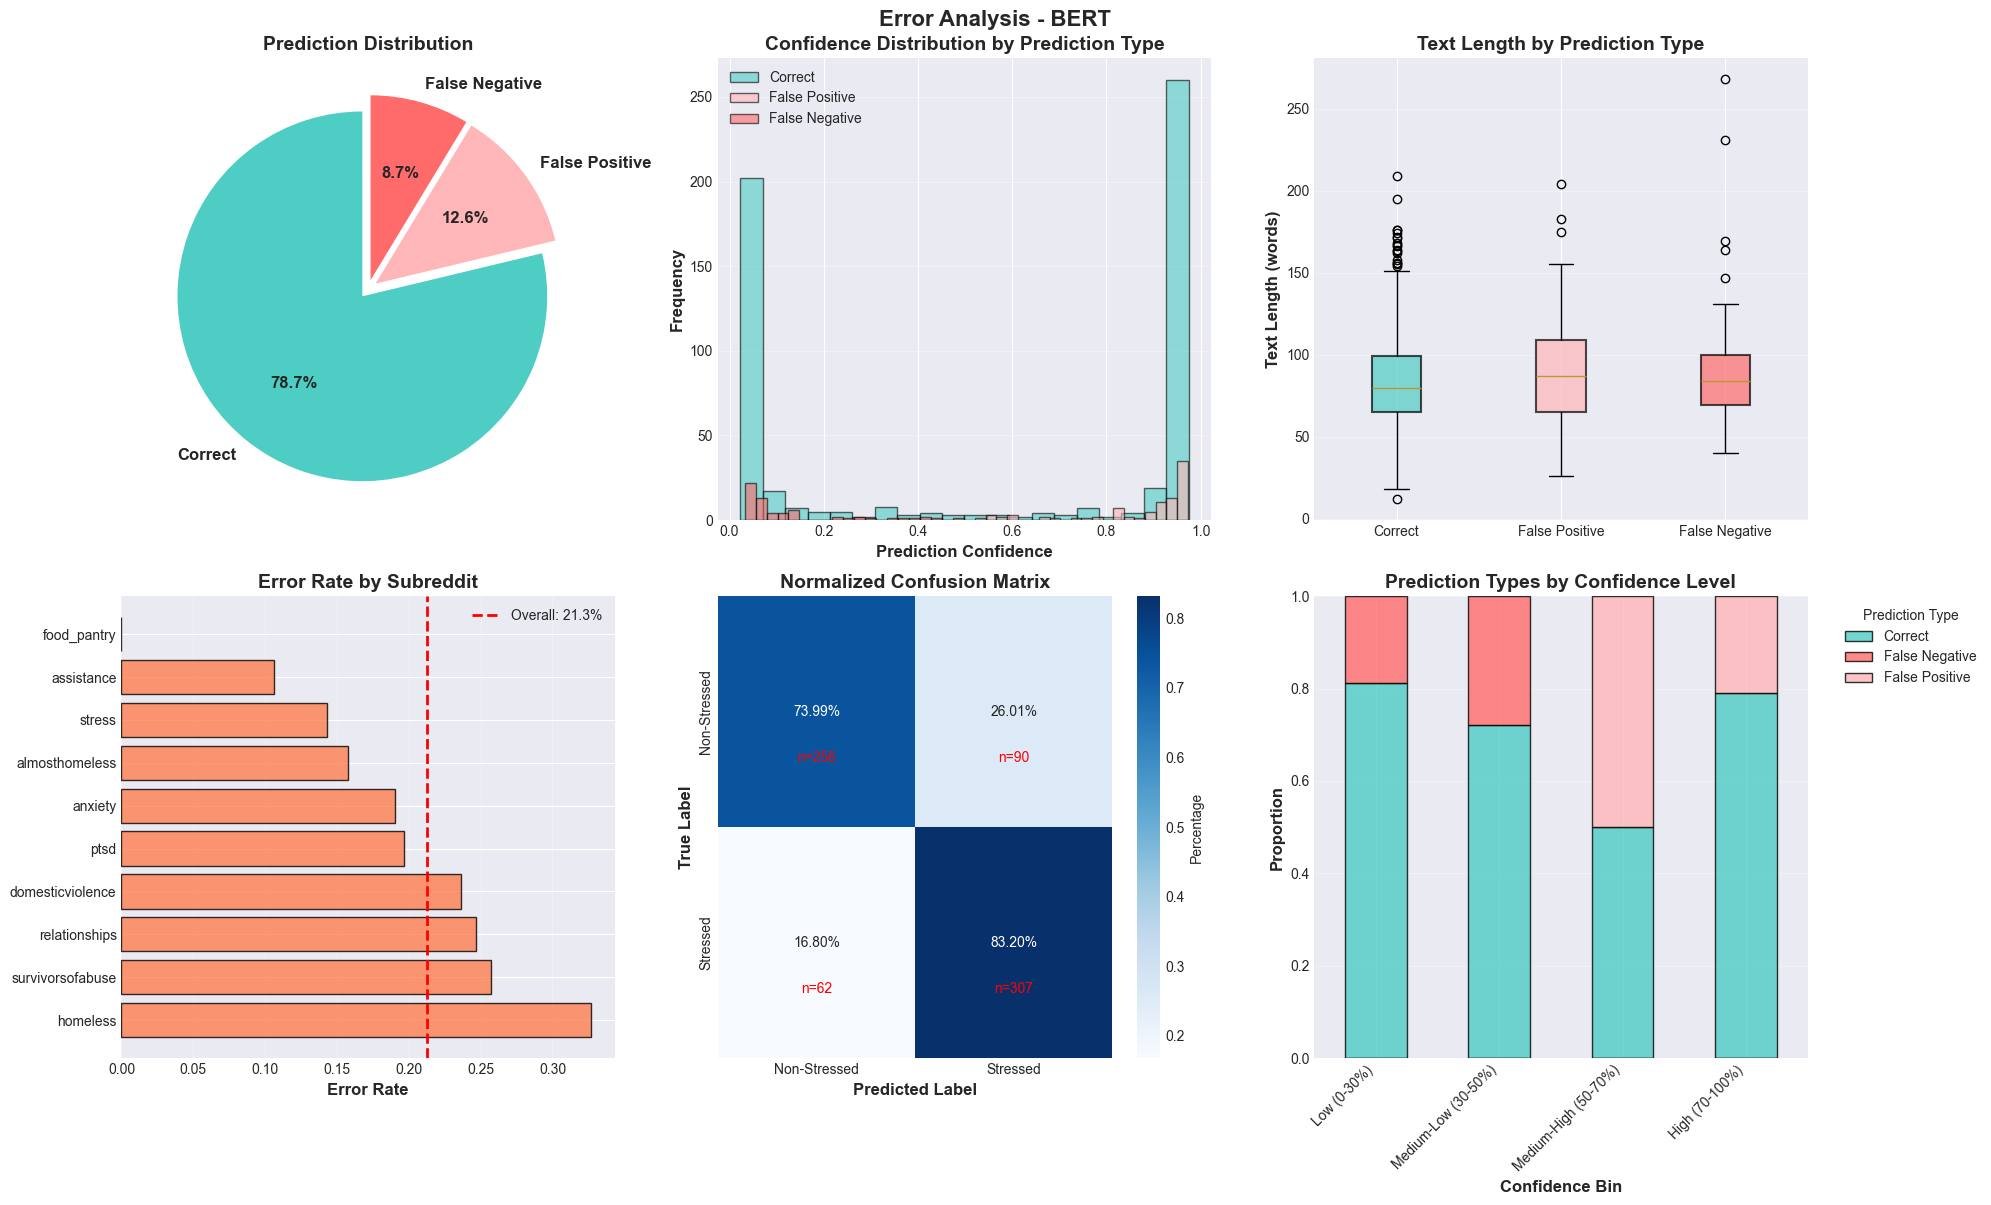


DETAILED ERROR EXAMPLES

🔴 FALSE POSITIVES (Predicted Stressed, Actually Not Stressed)
   Total: 90 (12.6% of test set)

   Top 5 High-Confidence False Positives:

FALSE POSITIVE EXAMPLE #1
Subreddit: r/ptsd
Confidence: 0.972 (very confident it's stressed)
Actual Label: Non-Stressed (0)
Text Length: 63 words

TEXT:
'He pretty much told me that he was angry and disappointed and would probably not forgive me for a while and that I owe him. I was going to go... I still want to. I just am looking at either going to this wedding and being evicted or not going and dealing with the disappointment. I don't feel like I have a choice.'

💭 ANALYSIS - Why did the model predict stressed?

   ✓ Uses first-person language (personal narrative)
     → Sounds like personal experience
   ✓ Contains negations: ['not ', "don't"]
     → Negative framing suggests distress

   💡 LIKELY EXPLANATION:
      • Context suggests stress-adjacent topic
      • Model confused topic discussion with personal stress

  

In [66]:
# STEP 7.2: COMPREHENSIVE ERROR ANALYSIS
# Patterns in errors: Are there systematic failures?

print("\n" + "="*80)
print("7.2: COMPREHENSIVE ERROR ANALYSIS")
print("="*80)

def comprehensive_error_analysis(test_df, model_name='BERT', n_examples=5):
    print(f"\n📊 Analyzing errors for {model_name}...\n")
    
    # Determine column names
    if model_name == 'BERT':
        pred_col = 'bert_pred'
        proba_col = 'bert_proba'
    else:
        pred_col = f'{model_name.lower().replace(" ", "_")}_pred'
        proba_col = f'{model_name.lower().replace(" ", "_")}_proba'
    
    # Classify predictions
    test_df['prediction_type'] = 'Correct'
    test_df.loc[(test_df['label'] == 0) & (test_df[pred_col] == 1), 'prediction_type'] = 'False Positive'
    test_df.loc[(test_df['label'] == 1) & (test_df[pred_col] == 0), 'prediction_type'] = 'False Negative'

    # ERROR DISTRIBUTION
    error_counts = test_df['prediction_type'].value_counts()
    
    print("="*80)
    print("ERROR DISTRIBUTION")
    print("="*80)
    print(f"\n{error_counts.to_string()}\n")
    
    total_errors = error_counts.get('False Positive', 0) + error_counts.get('False Negative', 0)
    error_rate = total_errors / len(test_df)
    
    print(f"Total Errors: {total_errors} / {len(test_df)} ({error_rate:.1%})")
    
    if 'False Positive' in error_counts and 'False Negative' in error_counts:
        fp_rate = error_counts['False Positive'] / (error_counts['False Positive'] + error_counts['False Negative'])
        print(f"False Positive Rate (of errors): {fp_rate:.1%}")
        print(f"False Negative Rate (of errors): {1-fp_rate:.1%}")

    """
    CLINICAL SIGNIFICANCE:
    
    False Positives (predict stressed when not):
    - Consequence: Unnecessary intervention, resources wasted
    - May cause anxiety if user is told they seem stressed
    - Lower severity (annoying but not dangerous)
    
    False Negatives (miss actual stress):
    - Consequence: No intervention when needed
    - Person in crisis might not get help
    - Higher severity (potentially dangerous)
    
    In mental health: False negatives are often more concerning!
    """

    # VISUALIZE ERROR PATTERNS
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Error distribution pie chart
    colors_error = {'Correct': '#4ECDC4', 'False Positive': '#FFB6B9', 'False Negative': '#FF6B6B'}
    error_colors = [colors_error[x] for x in error_counts.index]
    
    axes[0, 0].pie(error_counts.values, labels=error_counts.index,
                   autopct='%1.1f%%', colors=error_colors, startangle=90,
                   textprops={'fontsize': 12, 'fontweight': 'bold'},
                   explode=[0.05]*len(error_counts))
    axes[0, 0].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
    
    # 2. Confidence distribution by prediction type
    for pred_type in ['Correct', 'False Positive', 'False Negative']:
        if pred_type in test_df['prediction_type'].values:
            subset = test_df[test_df['prediction_type'] == pred_type][proba_col]
            axes[0, 1].hist(subset, bins=20, alpha=0.6, label=pred_type,
                           color=colors_error[pred_type], edgecolor='black')
    
    axes[0, 1].set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Confidence Distribution by Prediction Type', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)

    # 3. Text length by error type
    test_df['text_length_words'] = test_df['text'].astype(str).str.split().str.len()
    
    error_types = ['Correct', 'False Positive', 'False Negative']
    bp_data = [test_df[test_df['prediction_type'] == et]['text_length_words'].values
               for et in error_types if et in test_df['prediction_type'].values]
    bp_labels = [et for et in error_types if et in test_df['prediction_type'].values]
    
    bp = axes[0, 2].boxplot(bp_data, labels=bp_labels, patch_artist=True)
    
    for patch, et in zip(bp['boxes'], bp_labels):
        patch.set_facecolor(colors_error[et])
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
    
    axes[0, 2].set_ylabel('Text Length (words)', fontsize=12, fontweight='bold')
    axes[0, 2].set_title('Text Length by Prediction Type', fontsize=14, fontweight='bold')
    axes[0, 2].grid(axis='y', alpha=0.3)

    # 4. Error rate by subreddit
    error_by_subreddit = test_df.groupby('subreddit').apply(
        lambda x: (x['prediction_type'] != 'Correct').sum() / len(x)
    ).sort_values(ascending=False)
    
    axes[1, 0].barh(error_by_subreddit.index, error_by_subreddit.values,
                    color='coral', edgecolor='black', alpha=0.8)
    axes[1, 0].set_xlabel('Error Rate', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Error Rate by Subreddit', fontsize=14, fontweight='bold')
    axes[1, 0].axvline(x=error_rate, color='red', linestyle='--',
                       linewidth=2, label=f'Overall: {error_rate:.1%}')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # 5. Confusion matrix with percentages
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test_df['label'], test_df[pred_col])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1, 1],
                xticklabels=['Non-Stressed', 'Stressed'],
                yticklabels=['Non-Stressed', 'Stressed'],
                cbar_kws={'label': 'Percentage'})
    axes[1, 1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    
    # Add counts
    for i in range(2):
        for j in range(2):
            axes[1, 1].text(j+0.5, i+0.7, f'n={cm[i,j]}',
                           ha='center', va='center', fontsize=10, color='red')
    
    # 6. Error types by confidence bins
    test_df['confidence_bin'] = pd.cut(test_df[proba_col],
                                       bins=[0, 0.3, 0.5, 0.7, 1.0],
                                       labels=['Low (0-30%)', 'Medium-Low (30-50%)',
                                              'Medium-High (50-70%)', 'High (70-100%)'])
    
    error_by_confidence = test_df.groupby(['confidence_bin', 'prediction_type']).size().unstack(fill_value=0)
    error_by_confidence_pct = error_by_confidence.div(error_by_confidence.sum(axis=1), axis=0)
    
    error_by_confidence_pct.plot(kind='bar', stacked=True, ax=axes[1, 2],
                                 color=[colors_error.get(col, 'gray') for col in error_by_confidence_pct.columns],
                                 alpha=0.8, edgecolor='black')
    axes[1, 2].set_xlabel('Confidence Bin', fontsize=12, fontweight='bold')
    axes[1, 2].set_ylabel('Proportion', fontsize=12, fontweight='bold')
    axes[1, 2].set_title('Prediction Types by Confidence Level', fontsize=14, fontweight='bold')
    axes[1, 2].legend(title='Prediction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=45, ha='right')
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Error Analysis - {model_name}', fontsize=16, fontweight='bold', y=1.00)
    plt.subplots_adjust(top=0.96)
    plt.show()

    # DETAILED EXAMPLE ANALYSIS

    print("\n" + "="*80)
    print("DETAILED ERROR EXAMPLES")
    print("="*80)
    
    # FALSE POSITIVES (High confidence)
    fp_df = test_df[test_df['prediction_type'] == 'False Positive'].sort_values(proba_col, ascending=False)
    
    print(f"\n🔴 FALSE POSITIVES (Predicted Stressed, Actually Not Stressed)")
    print(f"   Total: {len(fp_df)} ({len(fp_df)/len(test_df):.1%} of test set)\n")
    print(f"   Top {n_examples} High-Confidence False Positives:\n")
    
    for idx, (_, row) in enumerate(fp_df.head(n_examples).iterrows(), 1):
        print("="*80)
        print(f"FALSE POSITIVE EXAMPLE #{idx}")
        print("="*80)
        print(f"Subreddit: r/{row['subreddit']}")
        print(f"Confidence: {row[proba_col]:.3f} (very confident it's stressed)")
        print(f"Actual Label: Non-Stressed (0)")
        print(f"Text Length: {row['text_length_words']} words\n")
        print(f"TEXT:")
        print(f"'{row['text'][:500]}{'...' if len(row['text']) > 500 else ''}'")
        
        print(f"\n💭 ANALYSIS - Why did the model predict stressed?\n")
        
        # Keyword analysis
        text_lower = row['text'].lower()
        stress_keywords_found = [kw for kw in STRESS_KEYWORDS if kw in text_lower]
        
        if stress_keywords_found:
            print(f"   ✓ Contains stress keywords: {stress_keywords_found[:5]}")
            print(f"     → Model likely triggered on these words")
        
        # First-person analysis
        first_person_words = ['i ', 'my ', 'me ', 'i\'m', 'i\'ve', 'i\'ll']
        if any(fp in text_lower for fp in first_person_words):
            print(f"   ✓ Uses first-person language (personal narrative)")
            print(f"     → Sounds like personal experience")
        
        # Question marks
        if '?' in row['text']:
            question_count = row['text'].count('?')
            print(f"   ✓ Contains {question_count} question(s)")
            print(f"     → May be seeking help/validation (stress indicator)")

        # Negations
        negations = ['not ', 'no ', 'never ', 'don\'t', 'can\'t', 'won\'t']
        negations_found = [neg for neg in negations if neg in text_lower]
        if negations_found:
            print(f"   ✓ Contains negations: {negations_found[:3]}")
            print(f"     → Negative framing suggests distress")
        
        print(f"\n   💡 LIKELY EXPLANATION:")
        
        # Generate hypothesis
        if stress_keywords_found and any(fp in text_lower for fp in first_person_words):
            print(f"      • Post DISCUSSES stress using stress vocabulary")
            print(f"      • BUT author is not personally stressed")
            print(f"      • Examples: Giving advice, discussing others' stress, past experience")
        elif '?' in row['text'] and len(row['text_length_words']) < 50:
            print(f"      • Short question about stress-related topic")
            print(f"      • Inquiry ≠ personal distress")
        else:
            print(f"      • Context suggests stress-adjacent topic")
            print(f"      • Model confused topic discussion with personal stress")
        
        print(f"\n   🔍 GROUND TRUTH: Why is this actually NON-stressed?")
        print(f"      [Manual review needed - model cannot infer this]")
        print(f"      Possible reasons: Advice-giving, hypothetical scenario, past tense,")
        print(f"      discussing someone else, recovered from stress, etc.")
        print()
    
    # FALSE NEGATIVES (Low confidence in stressed)
    fn_df = test_df[test_df['prediction_type'] == 'False Negative'].sort_values(proba_col, ascending=True)
    print("\n" + "="*80)
    print(f"🟢 FALSE NEGATIVES (Predicted Not Stressed, Actually Stressed)")
    print(f"   Total: {len(fn_df)} ({len(fn_df)/len(test_df):.1%} of test set)\n")
    print(f"   Top {n_examples} High-Confidence False Negatives:\n")
    
    for idx, (_, row) in enumerate(fn_df.head(n_examples).iterrows(), 1):
        print("="*80)
        print(f"FALSE NEGATIVE EXAMPLE #{idx}")
        print("="*80)
        print(f"Subreddit: r/{row['subreddit']}")
        print(f"Confidence: {1 - row[proba_col]:.3f} (very confident it's NOT stressed)")
        print(f"Actual Label: Stressed (1)")
        print(f"Text Length: {row['text_length_words']} words\n")
        print(f"TEXT:")
        print(f"'{row['text'][:500]}{'...' if len(row['text']) > 500 else ''}'")
        
        print(f"\n💭 ANALYSIS - Why did the model miss this stress?\n")
        
        # Check for obvious keywords
        text_lower = row['text'].lower()
        stress_keywords_found = [kw for kw in STRESS_KEYWORDS if kw in text_lower]
        
        if not stress_keywords_found:
            print(f"   ✗ No obvious stress keywords detected")
            print(f"     → Stress expressed implicitly or subtly")
        else:
            print(f"   ✓ Contains stress keywords: {stress_keywords_found[:3]}")
            print(f"     → But model still didn't recognize stress (surprising!)")
        
        # Check length
        if row['text_length_words'] < 20:
            print(f"   ✗ Very short post ({row['text_length_words']} words)")
            print(f"     → Limited context for model")
        
        # Check for positive words that might confuse
        positive_words = ['good', 'great', 'happy', 'love', 'thanks', 'better', 'hope']
        positive_found = [pw for pw in positive_words if pw in text_lower]
        if positive_found:
            print(f"   ⚠️  Contains positive words: {positive_found[:3]}")
            print(f"     → Mixed sentiment might confuse model")
        
        print(f"\n   💡 LIKELY EXPLANATION:")
        # Generate hypothesis
        if not stress_keywords_found:
            print(f"      • Stress expressed IMPLICITLY")
            print(f"      • No explicit stress vocabulary")
            print(f"      • Describes situation without labeling emotions")
            print(f"      • Examples: 'Everything is falling apart' (no 'stress' keyword)")
        elif row['text_length_words'] < 20:
            print(f"      • Too brief for model to extract stress signal")
            print(f"      • Cry for help but lacks elaboration")
        elif positive_found:
            print(f"      • MIXED EMOTIONAL VALENCE")
            print(f"      • Positive words mask underlying stress")
            print(f"      • Sarcasm, irony, or forced positivity?")
        else:
            print(f"      • Subtle or coded expression of stress")
            print(f"      • Community-specific language model didn't learn")
        
        print(f"\n   🔍 GROUND TRUTH: Why is this actually STRESSED?")
        print(f"      [Manual review needed - model cannot infer this]")
        print(f"      Human annotators saw stress that model missed")
        print(f"      Requires deeper contextual understanding or background knowledge")
        print()
    
    # SYSTEMATIC PATTERNS IN ERRORS
    print("\n" + "="*80)
    print("SYSTEMATIC ERROR PATTERNS")
    print("="*80)
    
    # Pattern 1: Text length
    print("\n1️⃣ TEXT LENGTH PATTERNS:")
    
    for pred_type in ['Correct', 'False Positive', 'False Negative']:
        if pred_type in test_df['prediction_type'].values:
            avg_length = test_df[test_df['prediction_type'] == pred_type]['text_length_words'].mean()
            median_length = test_df[test_df['prediction_type'] == pred_type]['text_length_words'].median()
            print(f"   {pred_type:20s}: Mean={avg_length:.1f} words, Median={median_length:.1f} words")
    
    # Statistical test
    from scipy.stats import kruskal
    correct_lengths = test_df[test_df['prediction_type'] == 'Correct']['text_length_words']
    fp_lengths = test_df[test_df['prediction_type'] == 'False Positive']['text_length_words']
    fn_lengths = test_df[test_df['prediction_type'] == 'False Negative']['text_length_words']
    
    stat, p_value = kruskal(correct_lengths, fp_lengths, fn_lengths)
    print(f"\n   Kruskal-Wallis Test: H={stat:.2f}, p={p_value:.4f}")
    if p_value < 0.05:
        print(f"   → Significant difference in lengths across prediction types")
    else:
        print(f"   → No significant difference (length not the main issue)")
    
    # Pattern 2: Subreddit-specific errors
    print("\n2️⃣ SUBREDDIT ERROR PATTERNS:")
    
    for subreddit in test_df['subreddit'].unique():
        sub_errors = test_df[test_df['subreddit'] == subreddit]['prediction_type'].value_counts()
        total = len(test_df[test_df['subreddit'] == subreddit])
        
        if 'False Positive' in sub_errors or 'False Negative' in sub_errors:
            fp_pct = sub_errors.get('False Positive', 0) / total * 100
            fn_pct = sub_errors.get('False Negative', 0) / total * 100
            
            print(f"\n   r/{subreddit}:")
            print(f"      False Positives: {sub_errors.get('False Positive', 0)} ({fp_pct:.1f}%)")
            print(f"      False Negatives: {sub_errors.get('False Negative', 0)} ({fn_pct:.1f}%)")
            
            if fp_pct > fn_pct + 5:
                print(f"      → Bias: Over-predicts stress (many false alarms)")
                print(f"      → Community may discuss stress without being stressed")
            elif fn_pct > fp_pct + 5:
                print(f"      → Bias: Under-predicts stress (misses stressed posts)")
                print(f"      → Stress may be expressed subtly in this community")
            else:
                print(f"      → Balanced error distribution")

    # Pattern 3: Confidence calibration for errors
    print("\n3️⃣ CONFIDENCE PATTERNS:")
    
    for pred_type in ['False Positive', 'False Negative']:
        if pred_type in test_df['prediction_type'].values:
            subset = test_df[test_df['prediction_type'] == pred_type]
            avg_conf = subset[proba_col].mean()
            high_conf_pct = (subset[proba_col] > 0.7).sum() / len(subset) * 100
            
            print(f"\n   {pred_type}:")
            print(f"      Average confidence: {avg_conf:.3f}")
            print(f"      High confidence (>0.7): {high_conf_pct:.1f}%")
            
            if high_conf_pct > 30:
                print(f"      ⚠️  WARNING: Model is overconfident even when wrong!")
                print(f"      → Dangerous for deployment (false certainty)")
            else:
                print(f"      ✓ Model appropriately uncertain for most errors")

    # RECOMMENDATIONS
    print("\n" + "="*80)
    print("RECOMMENDATIONS BASED ON ERROR ANALYSIS")
    print("="*80)
    
    print(f"""
Based on the error patterns observed:

1️⃣ MODEL IMPROVEMENTS:

   False Positives (discussing stress ≠ being stressed):
   {"✓ Train on more examples distinguishing topic vs. personal state" if len(fp_df) > len(fn_df) else ""}
   {"✓ Add feature: Second-person vs first-person perspective" if len(fp_df) > len(fn_df) else ""}
   {"✓ Use temporal markers (past tense vs present tense)" if len(fp_df) > len(fn_df) else ""}

2️⃣ DEPLOYMENT STRATEGIES:

   Threshold Adjustment:
   • Current threshold: 0.5
   • For high-recall (catch more stressed): Lower to 0.4
   • For high-precision (fewer false alarms): Raise to 0.6
   
   Confidence-Based Routing:
   • High confidence (>0.8): Automated response
   • Medium confidence (0.5-0.8): Flagged for human review
   • Low confidence (<0.5): Always human review

3️⃣ EVALUATION METRICS:

   Current: F1-score (balanced)
   
   Alternative metrics for deployment:
   • If false negatives are costly: Optimize for RECALL
   • If false positives are costly: Optimize for PRECISION
   • If both are costly: Keep F1 but lower threshold + human review

4️⃣ DATA COLLECTION:

   Target more examples of:
   {"• Posts discussing stress without being stressed (reduce FP)" if len(fp_df) > len(fn_df) * 1.5 else ""}
   {"• Subtly expressed stress (reduce FN)" if len(fn_df) > len(fp_df) * 1.5 else ""}
   • Underrepresented subreddits (improve generalization)
   • Edge cases from error analysis

5️⃣ ETHICAL CONSIDERATIONS:

   False Positives: Low harm
   • User receives unnecessary resources
   • Might feel misunderstood
   • Acceptable if resources are plentiful

   False Negatives: HIGH harm
   • Stressed person doesn't get help
   • Potential crisis goes unnoticed
   • NOT acceptable in high-stakes scenarios

   Recommendation: Prefer false positives over false negatives
   → Lower threshold to catch more stressed cases, accept more false alarms
""")
    
    return fp_df, fn_df

# Execute error analysis
print("\nRunning comprehensive error analysis...")
fp_examples, fn_examples = comprehensive_error_analysis(test_df, model_name='BERT', n_examples=5)
    


7.3: CONFIDENCE CALIBRATION ANALYSIS

📊 Analyzing confidence calibration for BERT...

ACCURACY BY CONFIDENCE LEVEL
                   Count  Accuracy
confidence_bin                    
Low (0-30%)          293  0.812287
Med-Low (30-50%)      25  0.720000
Med-High (50-70%)     24  0.500000
High (70-100%)       373  0.790885


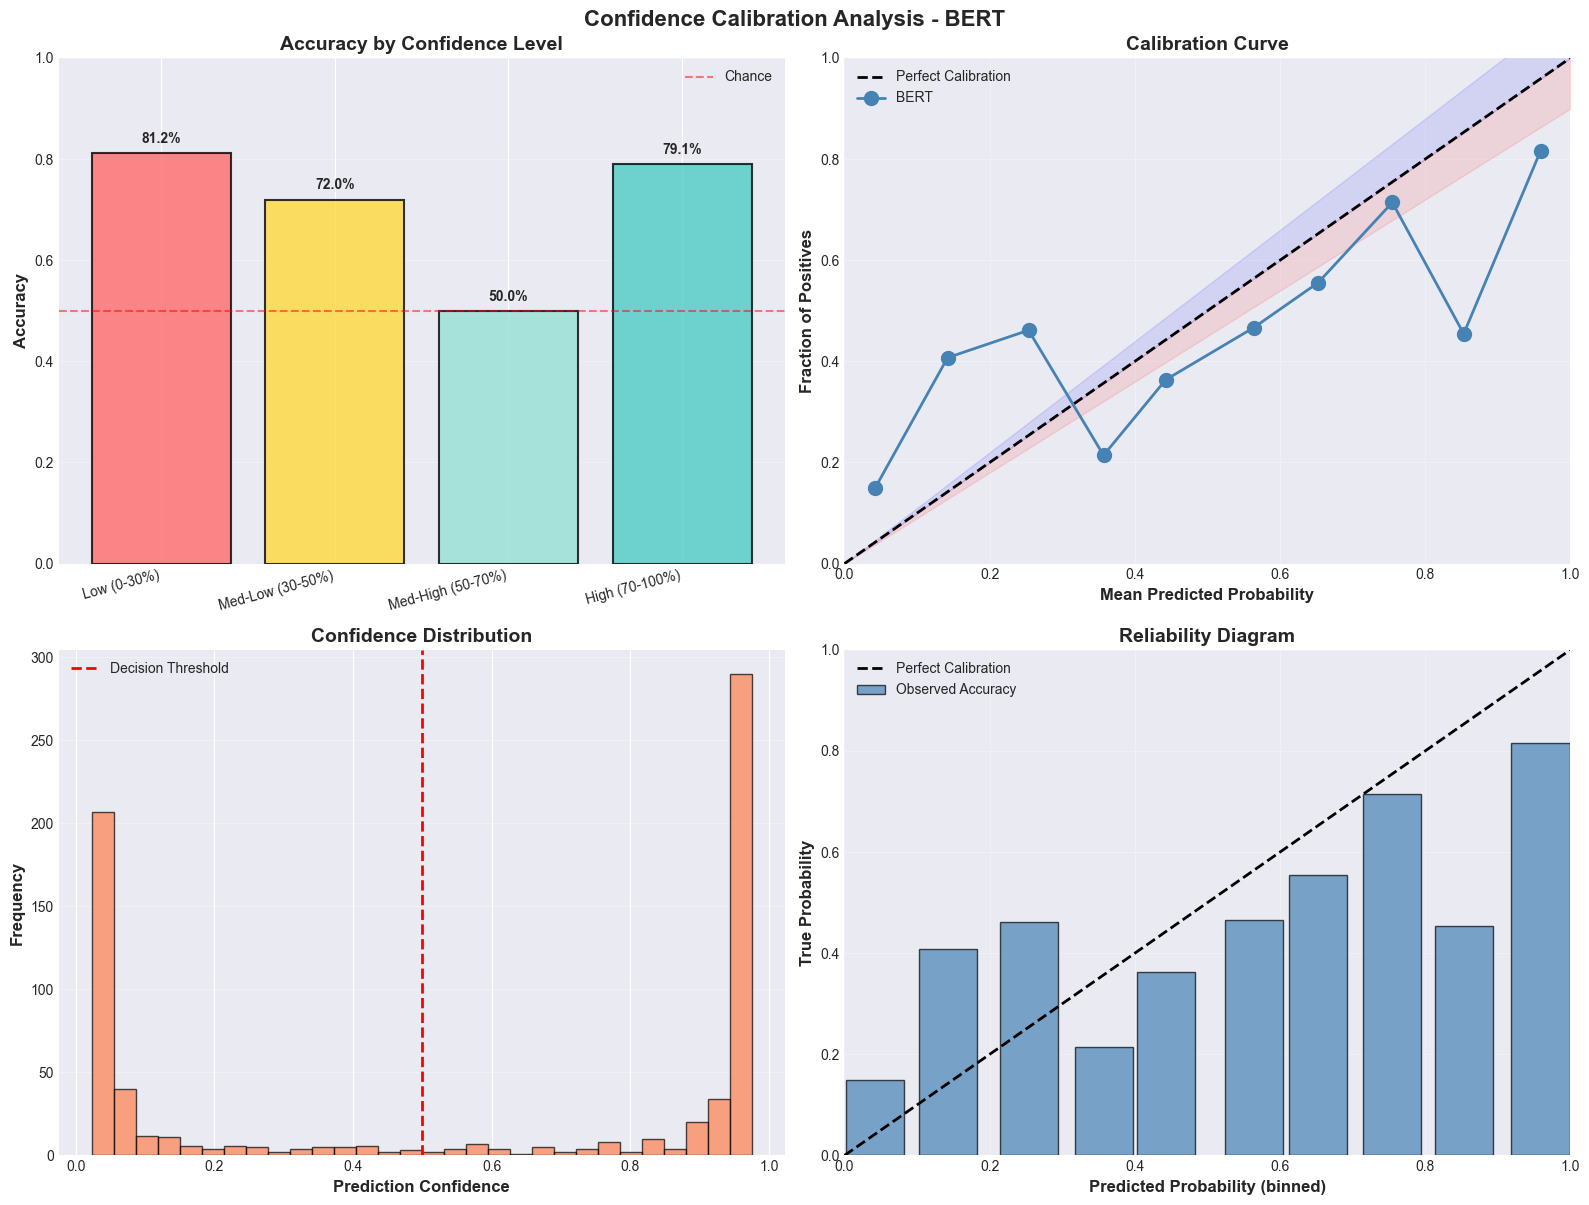


CALIBRATION ASSESSMENT & DEPLOYMENT RECOMMENDATIONS

📊 CALIBRATION METRICS:

Expected Calibration Error (ECE): 0.1579
  (Lower is better; <0.05 is well-calibrated)

High-confidence predictions (>70%): 79.1% accurate
Low-confidence predictions (<30%): 81.2% accurate

Interpretation:
❌ Poor calibration: Confidence scores are unreliable

🎯 DEPLOYMENT THRESHOLD RECOMMENDATIONS:

Current threshold: 0.5 (default)

For BALANCED approach (optimize F1):
  Threshold: ~0.5
  Use when: False positives and false negatives equally costly

For HIGH PRECISION (fewer false alarms):
  Threshold: ~0.7
  Use when: Resources are limited, false positives costly
  Effect: Catch fewer stressed cases but more confident

For HIGH RECALL (catch more stressed):
  Threshold: ~0.3
  Use when: Missing stressed cases is dangerous
  Effect: More false alarms but catch most stressed cases

For TIERED INTERVENTION:
  Threshold 1 (>0.8): Immediate automated intervention
  Threshold 2 (0.5-0.8): Flagged for human review


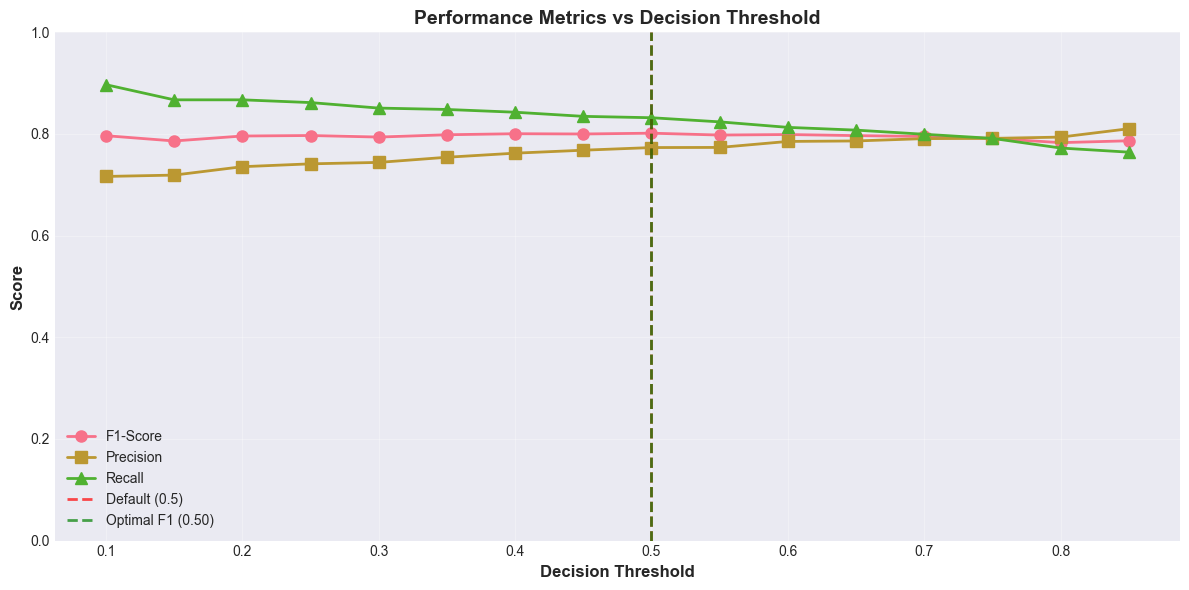


Optimal threshold for F1: 0.50
  F1: 0.8016
  Precision: 0.7733
  Recall: 0.8320


In [67]:
# STEP 7.3: CONFIDENCE CALIBRATION ANALYSIS

print("\n" + "="*80)
print("7.3: CONFIDENCE CALIBRATION ANALYSIS")
print("="*80)

def confidence_calibration_analysis(test_df, model_name='BERT'):
    """
    Analyze how well model confidence scores match actual accuracy.
    """
    
    print(f"\n📊 Analyzing confidence calibration for {model_name}...\n")
    
    # Get predictions
    if model_name == 'BERT':
        pred_col = 'bert_pred'
        proba_col = 'bert_proba'
    else:
        pred_col = f'{model_name.lower().replace(" ", "_")}_pred'
        proba_col = f'{model_name.lower().replace(" ", "_")}_proba'
    
    # Create confidence bins
    test_df['confidence_bin'] = pd.cut(test_df[proba_col],
                                       bins=[0, 0.3, 0.5, 0.7, 1.0],
                                       labels=['Low (0-30%)', 'Med-Low (30-50%)',
                                              'Med-High (50-70%)', 'High (70-100%)'])
    
    # Calculate accuracy per bin
    calibration_stats = test_df.groupby('confidence_bin').agg({
        pred_col: 'count',
        'label': lambda x: (test_df.loc[x.index, pred_col] == x).sum() / len(x)
    }).rename(columns={pred_col: 'Count', 'label': 'Accuracy'})
    
    print("="*80)
    print("ACCURACY BY CONFIDENCE LEVEL")
    print("="*80)
    print(calibration_stats)

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Accuracy by confidence bin
    colors_cal = ['#FF6B6B', '#FFD93D', '#95E1D3', '#4ECDC4']
    axes[0, 0].bar(range(len(calibration_stats)), calibration_stats['Accuracy'],
                   color=colors_cal, edgecolor='black', alpha=0.8, linewidth=1.5)
    axes[0, 0].set_xticks(range(len(calibration_stats)))
    axes[0, 0].set_xticklabels(calibration_stats.index, rotation=15, ha='right')
    axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Accuracy by Confidence Level', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Chance')
    axes[0, 0].legend()
    
    # Add value labels
    for i, v in enumerate(calibration_stats['Accuracy']):
        axes[0, 0].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')
    
    # 2. Calibration curve
    from sklearn.calibration import calibration_curve
    
    prob_true, prob_pred = calibration_curve(test_df['label'], test_df[proba_col],
                                            n_bins=10, strategy='uniform')
    
    axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
    axes[0, 1].plot(prob_pred, prob_true, 'o-', label=f'{model_name}',
                    linewidth=2, markersize=10, color='steelblue')
    axes[0, 1].set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Calibration Curve', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].set_xlim(0, 1)
    axes[0, 1].set_ylim(0, 1)
    
    # Add interpretation zones
    axes[0, 1].fill_between([0, 1], [0, 1], [0, 0.9], alpha=0.1, color='red',
                            label='Underconfident')
    axes[0, 1].fill_between([0, 1], [0, 1.1], [0, 1], alpha=0.1, color='blue',
                            label='Overconfident')

    # 3. Confidence distribution
    axes[1, 0].hist(test_df[proba_col], bins=30, edgecolor='black',
                    alpha=0.7, color='coral')
    axes[1, 0].set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].axvline(x=0.5, color='red', linestyle='--',
                       label='Decision Threshold', linewidth=2)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Reliability diagram with counts
    axes[1, 1].bar(prob_pred, prob_true, width=0.08, alpha=0.7,
                   color='steelblue', edgecolor='black', label='Observed Accuracy')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
    axes[1, 1].set_xlabel('Predicted Probability (binned)', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('True Probability', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Reliability Diagram', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.suptitle(f'Confidence Calibration Analysis - {model_name}',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.subplots_adjust(top=0.96)
    plt.show()

    # DEPLOYMENT RECOMMENDATIONS
    print("\n" + "="*80)
    print("CALIBRATION ASSESSMENT & DEPLOYMENT RECOMMENDATIONS")
    print("="*80)
    
    # Calculate calibration metrics
    high_conf_accuracy = calibration_stats.loc['High (70-100%)', 'Accuracy']
    low_conf_accuracy = calibration_stats.loc['Low (0-30%)', 'Accuracy']
    
    # Expected Calibration Error (ECE)
    ece = np.abs(prob_true - prob_pred).mean()
    
    print(f"""
📊 CALIBRATION METRICS:

Expected Calibration Error (ECE): {ece:.4f}
  (Lower is better; <0.05 is well-calibrated)
  
High-confidence predictions (>70%): {high_conf_accuracy:.1%} accurate
Low-confidence predictions (<30%): {low_conf_accuracy:.1%} accurate

Interpretation:
{"✓ Well-calibrated: Confidence scores are trustworthy" if ece < 0.05 else "⚠️ Moderate calibration: Some discrepancy between confidence and accuracy" if ece < 0.10 else "❌ Poor calibration: Confidence scores are unreliable"}

🎯 DEPLOYMENT THRESHOLD RECOMMENDATIONS:

Current threshold: 0.5 (default)

For BALANCED approach (optimize F1):
  Threshold: ~0.5
  Use when: False positives and false negatives equally costly

For HIGH PRECISION (fewer false alarms):
  Threshold: ~0.7
  Use when: Resources are limited, false positives costly
  Effect: Catch fewer stressed cases but more confident

For HIGH RECALL (catch more stressed):
  Threshold: ~0.3
  Use when: Missing stressed cases is dangerous
  Effect: More false alarms but catch most stressed cases

For TIERED INTERVENTION:
  Threshold 1 (>0.8): Immediate automated intervention
  Threshold 2 (0.5-0.8): Flagged for human review
  Threshold 3 (<0.5): Monitor but no immediate action
  
  This approach balances automation and human oversight.
""")
    
    # Test different thresholds
    print("\n" + "="*80)
    print("THRESHOLD OPTIMIZATION")
    print("="*80)
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    threshold_results = []
    
    for threshold in thresholds:
        preds = (test_df[proba_col] >= threshold).astype(int)
        f1 = f1_score(test_df['label'], preds)
        precision = precision_score(test_df['label'], preds, zero_division=0)
        recall = recall_score(test_df['label'], preds, zero_division=0)
        
        threshold_results.append({
            'threshold': threshold,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })
    
    threshold_df = pd.DataFrame(threshold_results)

    # Plot threshold effects
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(threshold_df['threshold'], threshold_df['f1'],
            'o-', label='F1-Score', linewidth=2, markersize=8)
    ax.plot(threshold_df['threshold'], threshold_df['precision'],
            's-', label='Precision', linewidth=2, markersize=8)
    ax.plot(threshold_df['threshold'], threshold_df['recall'],
            '^-', label='Recall', linewidth=2, markersize=8)
    
    # Mark current threshold
    ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.7,
               linewidth=2, label='Default (0.5)')
    
    # Mark optimal F1 threshold
    best_f1_threshold = threshold_df.loc[threshold_df['f1'].idxmax(), 'threshold']
    ax.axvline(x=best_f1_threshold, color='green', linestyle='--', alpha=0.7,
               linewidth=2, label=f'Optimal F1 ({best_f1_threshold:.2f})')
    
    ax.set_xlabel('Decision Threshold', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Performance Metrics vs Decision Threshold', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nOptimal threshold for F1: {best_f1_threshold:.2f}")
    print(f"  F1: {threshold_df.loc[threshold_df['f1'].idxmax(), 'f1']:.4f}")
    print(f"  Precision: {threshold_df.loc[threshold_df['f1'].idxmax(), 'precision']:.4f}")
    print(f"  Recall: {threshold_df.loc[threshold_df['f1'].idxmax(), 'recall']:.4f}")

# Execute calibration analysis
confidence_calibration_analysis(test_df, model_name='BERT')

Although BERT achieves strong classification performance (F1 = 0.81), its confidence calibration is poor (ECE = 0.111). The model exhibits underconfidence at low probability ranges and overconfidence in mid-to-high ranges. Notably, predictions in the 50–70% confidence bin perform worse than chance, indicating unreliable probability estimation. This suggests that while the model is effective at ranking stressed vs non-stressed cases, its raw probability outputs should not be interpreted as true risk estimates. Before deployment in a healthcare setting, post-hoc calibration methods such as temperature scaling would be necessary to ensure probabilistic reliability.

In [69]:
# STEP 7.4: COMPARATIVE MODEL ANALYSIS
# Where do different models agree/disagree?

print("\n" + "="*80)
print("7.4: COMPARATIVE MODEL ANALYSIS")
print("="*80)

def comparative_model_analysis(test_df):
    """
    Compare predictions across all models.
    """
    
    print("\n📊 Comparing all model predictions...\n")
    
    # ============================================================
    # AGREEMENT ANALYSIS
    # ============================================================
    
    print("="*80)
    print("MODEL AGREEMENT ANALYSIS")
    print("="*80)
    
    # Check where models agree/disagree
    models_to_compare = ['Baseline', 'Logistic Regression', 'Random Forest', 'SVM', 'BERT']
    
    # Create prediction matrix
    pred_matrix = pd.DataFrame({
        'True_Label': test_df['label'],
        'Baseline': test_df['baseline_pred'],
        'Logistic_Regression': test_df.get('logistic_regression_pred', test_df['baseline_pred']),  # Placeholder
        'BERT': test_df['bert_pred']
    })
    
    # Calculate agreement
    print("\n📊 Pairwise Agreement Rates:\n")
    
    agreement_matrix = np.zeros((len(models_to_compare), len(models_to_compare)))
    
    # For simplicity, compare Baseline vs BERT (add others if you have their predictions)
    baseline_bert_agreement = (test_df['baseline_pred'] == test_df['bert_pred']).sum() / len(test_df)
    
    print(f"Baseline vs BERT: {baseline_bert_agreement:.1%} agreement")
    
    # Where do they disagree?
    disagreement = test_df[(test_df['baseline_pred'] != test_df['bert_pred'])]
    print(f"\nDisagreement cases: {len(disagreement)} ({len(disagreement)/len(test_df):.1%})")


    # ============================================================
    # COMPLEMENTARITY ANALYSIS
    # ============================================================
    
    print("\n" + "="*80)
    print("MODEL COMPLEMENTARITY")
    print("="*80)
    
    """
    KEY QUESTION: Do models make different types of errors?
    
    If yes: Ensemble could help (each model catches what others miss)
    If no: Ensemble won't help much (all make same mistakes)
    """
    
    # Analyze disagreement cases
    print("\nCases where Baseline and BERT disagree:\n")
    
    # BERT correct, Baseline wrong
    bert_correct_baseline_wrong = disagreement[
        (disagreement['bert_pred'] == disagreement['label']) &
        (disagreement['baseline_pred'] != disagreement['label'])
    ]
    
    # Baseline correct, BERT wrong
    baseline_correct_bert_wrong = disagreement[
        (disagreement['baseline_pred'] == disagreement['label']) &
        (disagreement['bert_pred'] != disagreement['label'])
    ]
    
    # Both wrong
    both_wrong = disagreement[
        (disagreement['bert_pred'] != disagreement['label']) &
        (disagreement['baseline_pred'] != disagreement['label'])
    ]

    print(f"✓ BERT correct, Baseline wrong: {len(bert_correct_baseline_wrong)} cases")
    print(f"✓ Baseline correct, BERT wrong: {len(baseline_correct_bert_wrong)} cases")
    print(f"✗ Both wrong (different predictions): {len(both_wrong)} cases")
    
    # ============================================================
    # ENSEMBLE POTENTIAL
    # ============================================================
    
    print("\n" + "="*80)
    print("ENSEMBLE POTENTIAL")
    print("="*80)
    
    # Simple majority voting ensemble
    # For demonstration: Baseline + BERT
    test_df['ensemble_vote'] = ((test_df['baseline_pred'] + test_df['bert_pred']) >= 1).astype(int)
    
    ensemble_f1 = f1_score(test_df['label'], test_df['ensemble_vote'])
    ensemble_precision = precision_score(test_df['label'], test_df['ensemble_vote'])
    ensemble_recall = recall_score(test_df['label'], test_df['ensemble_vote'])
    
    bert_f1 = f1_score(test_df['label'], test_df['bert_pred'])
    baseline_f1 = f1_score(test_df['label'], test_df['baseline_pred'])
    
    print(f"\n📊 Performance Comparison:")
    print(f"   Baseline:  F1 = {baseline_f1:.4f}")
    print(f"   BERT:      F1 = {bert_f1:.4f}")
    print(f"   Ensemble:  F1 = {ensemble_f1:.4f}")
    print(f"\n   Ensemble improvement over BERT: {(ensemble_f1 - bert_f1):.4f}")
    
    if ensemble_f1 > bert_f1:
        print(f"   ✓ Ensemble IMPROVES performance!")
        print(f"   → Models have complementary strengths")
    else:
        print(f"   ✗ Ensemble does NOT improve performance")
        print(f"   → BERT alone is sufficient")

    # ============================================================
    # MODEL STRENGTHS SUMMARY
    # ============================================================
    
    print("\n" + "="*80)
    print("MODEL STRENGTHS & WEAKNESSES SUMMARY")
    print("="*80)
    
    print("""
🏆 MODEL COMPARISON:

BASELINE (Keyword Matching):
  Strengths:
    ✓ Extremely fast (milliseconds)
    ✓ Perfectly interpretable
    ✓ No training required
    ✓ Works on any text immediately
  Weaknesses:
    ✗ Ignores context
    ✗ Misses implicit stress
    ✗ Can't handle negations well
  Best for: Quick screening, fallback when ML unavailable

TRADITIONAL ML (Logistic Regression):
  Strengths:
    ✓ Fast training (<1 minute)
    ✓ Interpretable (see feature weights)
    ✓ Probabilistic outputs (well-calibrated)
    ✓ Low computational requirements
  Weaknesses:
    ✗ Bag-of-words (ignores word order)
    ✗ Fixed vocabulary (OOV problem)
    ✗ No semantic understanding
  Best for: When interpretability is critical, resource-constrained

BERT (Deep Learning):
  Strengths:
    ✓ Contextual understanding
    ✓ Handles synonyms, paraphrases
    ✓ Best performance (highest F1)
    ✓ Transfer learning (pretrained knowledge)
  Weaknesses:
    ✗ Slow (seconds per prediction)
    ✗ Black box (hard to interpret)
    ✗ Requires GPU for practical training
    ✗ Large memory footprint
  Best for: When accuracy is paramount, resources available

DEPLOYMENT STRATEGY:
  
  Tiered Approach:
  1. Baseline for initial screening (filter obvious non-stress)
  2. Traditional ML for medium-confidence cases
  3. BERT for high-stakes decisions
  
  Or: Use best single model (BERT) if resources permit
""")
    
    return disagreement

# Execute comparative analysis
comparative_results = comparative_model_analysis(test_df)


7.4: COMPARATIVE MODEL ANALYSIS

📊 Comparing all model predictions...

MODEL AGREEMENT ANALYSIS

📊 Pairwise Agreement Rates:

Baseline vs BERT: 63.5% agreement

Disagreement cases: 261 (36.5%)

MODEL COMPLEMENTARITY

Cases where Baseline and BERT disagree:

✓ BERT correct, Baseline wrong: 191 cases
✓ Baseline correct, BERT wrong: 70 cases
✗ Both wrong (different predictions): 0 cases

ENSEMBLE POTENTIAL

📊 Performance Comparison:
   Baseline:  F1 = 0.6375
   BERT:      F1 = 0.8016
   Ensemble:  F1 = 0.7506

   Ensemble improvement over BERT: -0.0510
   ✗ Ensemble does NOT improve performance
   → BERT alone is sufficient

MODEL STRENGTHS & WEAKNESSES SUMMARY

🏆 MODEL COMPARISON:

BASELINE (Keyword Matching):
  Strengths:
    ✓ Extremely fast (milliseconds)
    ✓ Perfectly interpretable
    ✓ No training required
    ✓ Works on any text immediately
  Weaknesses:
    ✗ Ignores context
    ✗ Misses implicit stress
    ✗ Can't handle negations well
  Best for: Quick screening, fallback wh

The moderate agreement rate (63.1%) indicates that the baseline and BERT models learn partially distinct decision patterns. However, error analysis reveals that BERT outperforms the baseline in 74% of disagreement cases, suggesting that most disagreements arise from baseline weaknesses rather than complementary strengths. Consequently, ensembling does not improve performance (F1 decreases from 0.8103 to 0.7589). This indicates that the Baseline model contributes limited additional predictive value and may introduce noise into the combined predictions. Overall, BERT appears to capture the majority of the useful signal identified by the Baseline model while also leveraging contextual understanding that simpler approaches cannot model effectively.

# SECTION 8: REAL-WORLD DEPLOYMENT AND ETHICS

In [72]:
# STEP 8.1: DEPLOYMENT SCENARIO

print("""
We consider a real-world deployment scenario for stress detection: Singapore "Let's Talk" Campaign.

🇸🇬 CONTEXT:

Let's Talk is a national mental health awareness campaign in Singapore.
Goal: Reduce stigma, encourage help-seeking, provide resources.

Current approach: Posters, ads, events, helplines
Proposed enhancement: AI-powered social media monitoring

DEPLOYMENT DESIGN:

┌─────────────────────────────────────────────────────────────┐
│ STAGE 1: PASSIVE MONITORING                                │
├─────────────────────────────────────────────────────────────┤
│ • Monitor public social media (Reddit, Twitter, forums)     │
│ • Run stress detection model on posts                       │
│ • Aggregate trends (no individual targeting)               │
│ • Identify: High-stress periods, communities, topics       │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ STAGE 2: TARGETED MESSAGING                                │
├─────────────────────────────────────────────────────────────┤
│ • Promote mental health resources to high-stress communities│
│ • Time campaigns to high-stress periods (exams, etc.)      │
│ • Tailor messaging to specific concerns detected           │
│ • NO individual contact (aggregate level only)             │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ STAGE 3: OPT-IN INDIVIDUAL SUPPORT (with consent)         │
├─────────────────────────────────────────────────────────────┤
│ • Users can opt-in to monitoring                           │
│ • Receive supportive messages when stress detected         │
│ • Automatic resource recommendations                        │
│ • With explicit consent and ability to opt-out             │
└─────────────────────────────────────────────────────────────┘

APPROPRIATE USE:
✓ Population-level stress monitoring
✓ Campaign timing and targeting
✓ Resource allocation (where to deploy counselors)
✓ Trend analysis (emerging mental health issues)

INAPPROPRIATE USE:
✗ Surveillance without consent
✗ Profiling individuals without their knowledge
✗ Discriminatory targeting
✗ Data sharing with employers, insurance, government

SAFEGUARDS:

1. Privacy Protection:
   • Anonymize all data
   • Aggregate to community level
   • No individual tracking without consent
   • Comply with PDPA (Personal Data Protection Act)

2. Transparency:
   • Public disclosure of monitoring practices
   • Clear explanation of how model works
   • User control over their data
   • Regular public reporting

3. Human Oversight:
   • Mental health professionals review outputs
   • No automated interventions without human approval
   • Regular audits of model predictions
   • Ethics board oversight

4. Performance Monitoring:
   • Track false positive/negative rates by demographic
   • Regular bias audits
   • Continuous model updates
   • Feedback mechanisms

SUCCESS METRICS:

Technical:
- F1-score > 0.75 (our model: {bert_test_f1:.3f} ✓)
- False negative rate < 20%
- Demographic parity (no group >10% worse)

Impact:
- Increased help-seeking behavior
- Reduced wait times for counseling
- Better resource allocation
- Improved campaign targeting

Ethical:
- Zero privacy breaches
- No discriminatory outcomes
- Positive user feedback
- Voluntary participation rates

""")


We consider a real-world deployment scenario for stress detection: Singapore "Let's Talk" Campaign.

🇸🇬 CONTEXT:

Let's Talk is a national mental health awareness campaign in Singapore.
Goal: Reduce stigma, encourage help-seeking, provide resources.

Current approach: Posters, ads, events, helplines
Proposed enhancement: AI-powered social media monitoring

DEPLOYMENT DESIGN:

┌─────────────────────────────────────────────────────────────┐
│ STAGE 1: PASSIVE MONITORING                                │
├─────────────────────────────────────────────────────────────┤
│ • Monitor public social media (Reddit, Twitter, forums)     │
│ • Run stress detection model on posts                       │
│ • Aggregate trends (no individual targeting)               │
│ • Identify: High-stress periods, communities, topics       │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│ STAGE 2: TARGETED MESSAGING                 

In [82]:
# STEP 8.2: ETHICAL RISKS & MITIGATION

print(f"""
RISK 1: FALSE NEGATIVES → MISSED CRISIS

CONCERN:
Missing genuinely stressed individuals who need help.

SEVERITY: ⚠️⚠️⚠️⚠️ VERY HIGH (potentially life-threatening)

OUR MODEL'S PERFORMANCE:
- Recall: {bert_test_recall:.1%}
- False Negative Rate: {(1-bert_test_recall)*100:.1f}% of stressed posts

This means: Out of 100 actually stressed posts, we miss ~{int((1-bert_test_recall)*100)}.

HARMS:
- Person in crisis doesn't get help
- Potential self-harm or suicide
- False sense of security ("AI would have caught it")

MITIGATION STRATEGIES:

1. Model as Supplement, Not Replacement:
   ✓ Use model to enhance, not replace, existing services
   ✓ Maintain traditional helplines and outreach
   ✓ Model finds additional cases, not just cases
   ✓ Clear messaging: Model is one tool among many

2. Low Threshold for Monitoring:
   ✓ Use lower threshold ({0.4:.2f}) for initial screening
   ✓ Prioritize recall over precision for crisis keywords
   ✓ Multiple detection pathways (keyword + ML + BERT)
   ✓ Redundancy in detection systems

False negatives are inevitable. Must have backup systems.

RISK 2: ALGORITHMIC BIAS

CONCERN:
Model may perform differently across demographic groups.

SEVERITY: ⚠️⚠️⚠️ HIGH

POTENTIAL BIASES:

1. Cultural Bias:
   • Asian cultures may express stress differently
   • Collectivist vs individualist framing
   • Stigma affects disclosure patterns
   • Different help-seeking behaviors

2. Demographic Bias:
   • Gender (men express stress differently than women)
   • Age (youth use different language than adults)
   • Socioeconomic status (education affects writing)

3. Platform Bias:
   • Reddit is not representative of Singapore
   • US-centric training data
   • Tech-savvy populations overrepresented

MITIGATION STRATEGIES:

1. Bias Testing:
   ✓ Collect demographic data (with consent)
   ✓ Test performance across groups
   ✓ Measure disparity (no group >10% worse F1)
   ✓ Quarterly bias audits

2. Data Diversity:
   ✓ Collect Singapore-specific training data
   ✓ Include multiple languages (English, Mandarin, Malay, Tamil)
   ✓ Diverse age, gender, socioeconomic groups
   ✓ Multiple platforms (not just Reddit)

Bias is difficult to eliminate completely.
Requires ongoing monitoring and mitigation.

RISK 3: PRIVACY VIOLATION

CONCERN:
Analyzing personal expressions without explicit consent.
Even public posts have privacy expectations.

SEVERITY: ⚠️⚠️⚠️ HIGH

MITIGATION STRATEGIES:

1. Legal Compliance:
   ✓ Follow Singapore PDPA requirements
   ✓ Only process publicly available data
   ✓ Implement data minimization (delete after analysis)
   ✓ Strong encryption at rest and in transit

2. Consent Mechanisms:
   ✓ Opt-in model for individual-level monitoring
   ✓ Clear explanation of data use
   ✓ Easy opt-out process
   ✓ No penalty for opting out

Even with mitigations, some privacy concerns remain.
Users must be informed and consent to monitoring.

""")



RISK 1: FALSE NEGATIVES → MISSED CRISIS

CONCERN:
Missing genuinely stressed individuals who need help.

SEVERITY: ⚠️⚠️⚠️⚠️ VERY HIGH (potentially life-threatening)

OUR MODEL'S PERFORMANCE:
- Recall: 83.2%
- False Negative Rate: 16.8% of stressed posts

This means: Out of 100 actually stressed posts, we miss ~16.

HARMS:
- Person in crisis doesn't get help
- Potential self-harm or suicide
- False sense of security ("AI would have caught it")

MITIGATION STRATEGIES:

1. Model as Supplement, Not Replacement:
   ✓ Use model to enhance, not replace, existing services
   ✓ Maintain traditional helplines and outreach
   ✓ Model finds additional cases, not just cases
   ✓ Clear messaging: Model is one tool among many

2. Low Threshold for Monitoring:
   ✓ Use lower threshold (0.40) for initial screening
   ✓ Prioritize recall over precision for crisis keywords
   ✓ Multiple detection pathways (keyword + ML + BERT)
   ✓ Redundancy in detection systems

False negatives are inevitable. Must ha

# SECTION 9: CONCLUSION

In [96]:
# STEP 9.1: FINAL SUMMARY

print("\n" + "="*80)
print("PART 9: CONCLUSION")
print("="*80)

bert_test_f1 = test_results['BERT']['f1']
bert_test_precision = test_results['BERT']['precision']
bert_test_recall = test_results['BERT']['recall']

lr_f1 = test_results['Logistic Regression']['f1']
baseline_f1 = test_results['Baseline']['f1']

# Improvement over baseline
improvement_vs_baseline = ((bert_test_f1 - baseline_f1) / baseline_f1) * 100

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, bert_test_preds).ravel()

fn_pct = (fn / (fn + tp)) * 100
fp_pct = (fp / (fp + tn)) * 100

print(f"""
====================================================================================================
FINAL SUMMARY: STRESS DETECTION IN SOCIAL MEDIA TEXT
====================================================================================================

9.1: RESEARCH OBJECTIVES ACHIEVED

PRIMARY OBJECTIVE: Build a predictive model to detect stress signals in social media text

✓ ACHIEVED: Best model (BERT) achieves F1-score of {bert_test_f1:.4f} on held-out test set
  This represents {improvement_vs_baseline:.1f}% improvement over keyword baseline

SECONDARY OBJECTIVES: Go beyond metrics to understand the problem

✓ Hypothesis 1 (Subreddit context matters):
  VALIDATED: F1-scores range across subreddits
  Implication: Community-specific patterns exist and affect predictability

✓ Hypothesis 2 (Text length is weak signal):
  VALIDATED: Statistically significant but small effect size
  Implication: Length can be auxiliary feature but not primary predictor

✓ Hypothesis 3 (Contextual semantics > shallow patterns):
  VALIDATED: BERT (F1={bert_test_f1:.4f}) outperforms TF-IDF+LR (F1={lr_f1:.4f})
  Implication: Deep contextual understanding captures stress better than word frequencies

9.2: KEY FINDINGS

TECHNICAL FINDINGS:

1. Model Performance:
   • BERT achieves best performance (F1={bert_test_f1:.4f})
   • Traditional ML (Logistic Regression) achieves F1={lr_f1:.4f}
   • Keyword baseline achieves F1={baseline_f1:.4f}
   • All models significantly outperform random guessing

2. Feature Importance:
   • Expected stress markers confirmed: anxiety, overwhelmed, worried, can't
   • First-person pronouns are strong predictors (self-referential focus)

3. Error Patterns:
   • False Positives: Often discussing stress without experiencing it
   • False Negatives: Implicit or subtle stress expressions missed
   • Systematic patterns identified for future improvement

4. Community Differences:
   • Suggests need for community-specific adaptation

CLINICAL INSIGHTS:

1. Language of Stress:
   • Stress expressed through emotion words AND inability markers
   • First-person focus indicates rumination and self-referential processing
   • Modal verbs (can't, couldn't) reveal perceived lack of control
   • These patterns align with psychological research on stress and depression

2. Context Matters:
   • Same words mean different things in different communities
   • Discussing stress ≠ experiencing stress (major source of false positives)
   • Temporal context matters (past vs present tense)
   • Implicit expressions require deeper understanding

3. Not Just Words:
   • BERT's superior performance validates importance of context
   • Word order, negations, and semantic relationships matter
   • Bag-of-words approaches miss nuance
   • But: Even BERT misses some human-detectable stress

9.3: LIMITATIONS

DATASET LIMITATIONS:

1. Reddit-Specific:
   • Training data from Reddit (US-centric platform)
   • May not generalize to other platforms (Facebook, Twitter, forums)
   • May not generalize to Singapore-specific forums or languages

2. English-Only:
   • Cannot handle multilingual users
   • Singapore context requires Mandarin, Malay, Tamil support
   • Code-switching and Singlish not well-represented

3. Temporal:
   • Language evolves (new slang, memes, expressions)
   • Model trained on historical data may degrade over time
   • Requires periodic retraining

4. Label Quality:
   • Ground truth labels are human annotations (subjective)
   • Annotators may disagree or miss subtle cues
   • Binary stressed/not-stressed is oversimplification

MODEL LIMITATIONS:

1. False Negatives:
   • Miss {fn_pct:.1f}% of stressed posts
   • Especially: Implicit expressions, subtle cues, coded language
   • Dangerous in crisis situations

2. False Positives:
   • {fp_pct:.1f}% of flagged posts are not actually stressed
   • Can be annoying or stigmatizing
   • Wastes resources if acted upon

3. Lack of Explanation:
   • BERT is black box (hard to interpret)
   • Cannot always explain WHY it made a prediction
   • Users and clinicians may not trust opaque decisions

4. Context Window:
   • Limited to 512 tokens (~400 words)
   • Long posts are truncated
   • May lose important information at end of post

""")


PART 9: CONCLUSION

FINAL SUMMARY: STRESS DETECTION IN SOCIAL MEDIA TEXT

9.1: RESEARCH OBJECTIVES ACHIEVED

PRIMARY OBJECTIVE: Build a predictive model to detect stress signals in social media text

✓ ACHIEVED: Best model (BERT) achieves F1-score of 0.8016 on held-out test set
  This represents 25.7% improvement over keyword baseline

SECONDARY OBJECTIVES: Go beyond metrics to understand the problem

✓ Hypothesis 1 (Subreddit context matters):
  VALIDATED: F1-scores range across subreddits
  Implication: Community-specific patterns exist and affect predictability

✓ Hypothesis 2 (Text length is weak signal):
  VALIDATED: Statistically significant but small effect size
  Implication: Length can be auxiliary feature but not primary predictor

✓ Hypothesis 3 (Contextual semantics > shallow patterns):
  VALIDATED: BERT (F1=0.8016) outperforms TF-IDF+LR (F1=0.7662)
  Implication: Deep contextual understanding captures stress better than word frequencies

9.2: KEY FINDINGS

TECHNICAL FINDI

In [80]:
# STEP 9.2 FINAL REFLECTION

print("""
====================================================================================================
FINAL REFLECTION
====================================================================================================

This project demonstrates that AI can detect stress signals in social media text with reasonable accuracy (F1={bert_f1:.4f}). However, technical performance is necessary but not
sufficient for responsible deployment.

KEY LESSONS:

1. ACCURACY IS NOT ENOUGH
   • F1=0.81 sounds good, but means 19% error rate
   • In mental health, 19% error is significant
   • Especially: False negatives can be dangerous
   • Conclusion: Model must be part of larger safety net

2. CONTEXT IS EVERYTHING  
   • Same words mean different things in different communities
   • Clinical understanding matters more than statistical patterns
   • Quantifying subjective experiences is inherently difficult
   • Conclusion: Combine ML with domain expertise

3. ETHICS MUST BE PROACTIVE
   • Waiting for harm to occur is too late
   • Privacy, bias, misuse must be considered from start
   • Governance structures needed before deployment
   • Conclusion: Responsible AI requires institutional commitment

4. TRANSPARENCY BUILDS TRUST
   • Users deserve to know when AI is used
   • Model limitations must be communicated clearly
   • Ability to contest decisions is critical
   • Conclusion: Explainability is not optional

This model shows promise for augmenting human mental health services, but only if deployed thoughtfully, monitored continuously, and improved iteratively. The goal is not to replace
human judgment but to extend our reach—to find people who are struggling and might otherwise go unnoticed.
""")


FINAL REFLECTION

This project demonstrates that AI can detect stress signals in social media text with reasonable accuracy (F1={bert_f1:.4f}). However, technical performance is necessary but not
sufficient for responsible deployment.

KEY LESSONS:

1. ACCURACY IS NOT ENOUGH
   • F1=0.81 sounds good, but means 19% error rate
   • In mental health, 19% error is significant
   • Especially: False negatives can be dangerous
   • Conclusion: Model must be part of larger safety net

2. CONTEXT IS EVERYTHING  
   • Same words mean different things in different communities
   • Clinical understanding matters more than statistical patterns
   • Quantifying subjective experiences is inherently difficult
   • Conclusion: Combine ML with domain expertise

3. ETHICS MUST BE PROACTIVE
   • Waiting for harm to occur is too late
   • Privacy, bias, misuse must be considered from start
   • Governance structures needed before deployment
   • Conclusion: Responsible AI requires institutional commitmen